In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertConfig, BertForSequenceClassification, BertTokenizer
from datasets import load_dataset
from tqdm import tqdm
from copy import deepcopy
import torch.nn.functional as F



class FeatureHook:
    """Intercepte les activations d'une couche specifique."""
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        # Pour les transformers, output peut etre un tuple
        if isinstance(output, tuple):
            self.features = output[0]
        else:
            self.features = output

    def close(self):
        self.hook.remove()


class DitherSentiment:
    def __init__(self, model_id="prajjwal1/bert-tiny", device="cuda"):
        self.device = device
        self.model_id = model_id
        
        # Chargement du modele (bert-tiny: 4.4M params, ~15x plus rapide que DistilBERT)
        # self.model = AutoModelForSequenceClassification.from_pretrained(
        #     model_id, num_labels=2, use_safetensors=True
        # ).to(device)

        config = BertConfig.from_pretrained(model_id, num_labels=2)
        self.model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device)
        self.tokenizer=BertTokenizer.from_pretrained(model_id)
        # self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        
        # Configuration par defaut
        self.config = {
            # "layer_name": "classifier.weight",  # Couche de classification
             "layer_name": "bert.encoder.layer.1.output.dense.weight",
            "hook_layer":  "bert.encoder.layer.1.output.dense",

            "watermark_len": 64,
            "lr": 5e-5,  # Learning rate plus eleve pour petit modele
            "lambda_wat": 1.0,
            "epochs": 30 , # Plus d'epochs car modele non-pretrained sur sentiment
            "alpha": 10.0,  # Parametre STDM
            "beta": 0.1,
        }
        
        self.saved_keys = {}
        
    def list_layers(self):
        """Affiche les couches disponibles pour le watermarking."""
        print("Couches disponibles:")
        for name, param in self.model.named_parameters():
            print(f"  {name}: {param.shape}")

    def _get_target_layer(self, model, layer_name=None):
        """Recupere la couche cible pour le hook."""

        for name, module in model.named_modules():
            if name == layer_name:
                return module
        raise ValueError(f"Couche {layer_name} introuvable.")



    def _get_target_weights(self, model):
        """Recupere le tenseur des poids de la couche cible."""
        for name, param in model.named_parameters():
            if name == self.config["layer_name"]:
                return param
        raise ValueError(f"Parametre {self.config['layer_name']} introuvable.")




    @staticmethod
    def _theta(x, alpha_, beta_):
        """Fonction theta de STDM."""
        numerator = torch.exp(alpha_ * torch.sin(torch.tensor(beta_) * x))
        denominator = 1 + torch.exp(alpha_ * torch.sin(torch.tensor(beta_) * x))
        return numerator / denominator


    
    def embed(self, train_dataloader, eval_dataloader=None):
        """
        Incorpore la marque Dither pendant le finetuning.
        """
        print(f"--- Demarrage Embedding Ditheer ({self.config['layer_name']}) ---")
        
        watermarked_model = self.model
        watermarked_model.train()
        
        # 1. Generation des Cles (Matrice A et Watermark binaire)
        target_weights = self._get_target_weights(watermarked_model)
        

        with torch.no_grad():
            w_flat_dim = torch.flatten(target_weights.mean(dim=0)).shape[0]
        
        print(f"Dimension vecteur poids : {w_flat_dim} | Watermark : {self.config['watermark_len']} bits")
        
        matrix_a = torch.randn(w_flat_dim, self.config["watermark_len"]).to(self.device)
        matrix_a = F.normalize(matrix_a, p=2, dim=0)

        watermark_target = torch.randint(0, 2, (self.config["watermark_len"],)).float().to(self.device)
        
        # 2. Optimiseur
        optimizer = torch.optim.AdamW(watermarked_model.parameters(), lr=self.config["lr"])

        ce_loss = nn.CrossEntropyLoss()
        bce_loss = nn.BCELoss()

        alpha_ = self.config["alpha"]
        beta_ = self.config["beta"]
        
        # 3. Boucle d'entrainement
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{self.config['epochs']}")
            total_loss = 0
            correct = 0
            total = 0
            
            for batch in pbar:
                input_ids = batch["input_ids"].to(self.device)  #tokennized textes (numbers)
                attention_mask = batch["attention_mask"].to(self.device) #which tokens to pay attention to (1 for real tokens, 0 for padding)
                labels = batch["labels"].to(self.device) #correct answer for each sentence ( 0 = negative, 1 = positive)
                
                optimizer.zero_grad()
                
                # A. Forward pass (Task Loss)
                outputs = watermarked_model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                l_main = ce_loss(logits, labels)
                
                # B. Watermark Loss (Regularization)
                current_weights = self._get_target_weights(watermarked_model)
                w_flat = torch.flatten(current_weights.mean(dim=0))
                
                pred_wm_prob = self._theta(w_flat @ matrix_a, alpha_, beta_)
                l_wat = bce_loss(pred_wm_prob, watermark_target)
                
                # Loss Totale
                l_total = l_main + self.config["lambda_wat"] * l_wat
                
                l_total.backward()
                optimizer.step()
                
                # Metrics
                total_loss += l_main.item()
                preds = torch.argmax(logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                ber = self._compute_ber(pred_wm_prob, watermark_target)
                acc = 100. * correct / total
                pbar.set_postfix(L_Main=f"{l_main.item():.3f}", L_Wat=f"{l_wat.item():.3f}", 
                                BER=f"{ber:.2f}", Acc=f"{acc:.1f}%")
            
            # Evaluation en fin d'epoch
            if eval_dataloader:
                eval_acc = self.evaluate(watermarked_model, eval_dataloader)
                print(f"Epoch {epoch+1} | Eval Accuracy: {eval_acc:.2f}%")
        
        # Sauvegarde des cles
        self.saved_keys = {
            "matrix_a": matrix_a,
            "watermark_target": watermark_target,
            "watermarked_model": watermarked_model,
            "alpha": alpha_,
            "beta": beta_,
        }
        
        final_ber = self._compute_ber(pred_wm_prob, watermark_target)
        print(f"\n--- Embedding termine | BER final: {final_ber:.2f} ---")
        return watermarked_model
    
    def evaluate(self, model, dataloader):
        """Evalue la precision du modele."""
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        model.train()
        return 100. * correct / total
    
    def extract(self, suspect_model=None):
        """
        Extrait la marque d'un modele suspect.
        """
        if suspect_model is None:
            suspect_model = self.saved_keys["watermarked_model"]
        
        matrix_a = self.saved_keys["matrix_a"]
        alpha_= self.saved_keys["alpha"]
        beta_= self.saved_keys["beta"]
        watermark_target = self.saved_keys["watermark_target"]
        
        # 1. Recuperation des poids
        try:
            target_weights = self._get_target_weights(suspect_model)
        except ValueError:
            print("Couche cible introuvable dans le modele suspect.")
            return 1.0, None
        
        # 2. Projection
        with torch.no_grad():
            w_flat = torch.flatten(target_weights.mean(dim=0))
            pred_wm_prob =  self._theta(w_flat @ matrix_a, alpha_, beta_)
            ber = self._compute_ber(pred_wm_prob, watermark_target)
        
        print(f"BER Extrait : {ber:.2f}")
        return ber, pred_wm_prob
    
    @staticmethod
    def _compute_ber(pred, target):
        return ((pred > 0.5).float() != target).float().mean().item()

print("Classe DitherSentiment chargee (bert-tiny: 4.4M params)")

/home/latim/PycharmProjects/WatDNN/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classe DitherSentiment chargee (bert-tiny: 4.4M params)


In [2]:
# --- Chargement des donnees SST-2 ---

# Charger le dataset SST-2 (sentiment binaire)
dataset = load_dataset("glue", "sst2")

# Initialiser le watermarker (charge le modele bert-tiny)
dither = DitherSentiment(device="cuda" if torch.cuda.is_available() else "cpu")

# Afficher les couches disponibles
dither.list_layers()

# Tokenization
def tokenize_function(examples):
    return dither.tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True) #converts raw text sentences into input_ids and attention_mask
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# DataLoaders (batch_size=64 possible grace au petit modele)
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=64, shuffle=True)
eval_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=64)

print(f"\nTrain samples: {len(tokenized_dataset['train'])}")
print(f"Eval samples: {len(tokenized_dataset['validation'])}")

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2631.48it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNor

Couches disponibles:
  bert.embeddings.word_embeddings.weight: torch.Size([30522, 128])
  bert.embeddings.position_embeddings.weight: torch.Size([512, 128])
  bert.embeddings.token_type_embeddings.weight: torch.Size([2, 128])
  bert.embeddings.LayerNorm.weight: torch.Size([128])
  bert.embeddings.LayerNorm.bias: torch.Size([128])
  bert.encoder.layer.0.attention.self.query.weight: torch.Size([128, 128])
  bert.encoder.layer.0.attention.self.query.bias: torch.Size([128])
  bert.encoder.layer.0.attention.self.key.weight: torch.Size([128, 128])
  bert.encoder.layer.0.attention.self.key.bias: torch.Size([128])
  bert.encoder.layer.0.attention.self.value.weight: torch.Size([128, 128])
  bert.encoder.layer.0.attention.self.value.bias: torch.Size([128])
  bert.encoder.layer.0.attention.output.dense.weight: torch.Size([128, 128])
  bert.encoder.layer.0.attention.output.dense.bias: torch.Size([128])
  bert.encoder.layer.0.attention.output.LayerNorm.weight: torch.Size([128])
  bert.encoder.layer

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1821/1821 [00:00<00:00, 33819.34 examples/s]


Train samples: 67349
Eval samples: 872


In [3]:

# Lancer l'embedding
watermarked_model = dither.embed(train_dataloader, eval_dataloader)

--- Demarrage Embedding Ditheer (bert.encoder.layer.1.output.dense.weight) ---
Dimension vecteur poids : 512 | Watermark : 64 bits


Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 217.97it/s, Acc=79.5%, BER=0.03, L_Main=0.300, L_Wat=0.685]


Epoch 1 | Eval Accuracy: 80.05%


Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 222.62it/s, Acc=88.4%, BER=0.03, L_Main=0.156, L_Wat=0.680]


Epoch 2 | Eval Accuracy: 83.14%


Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 216.15it/s, Acc=90.7%, BER=0.03, L_Main=0.241, L_Wat=0.674]


Epoch 3 | Eval Accuracy: 82.68%


Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 208.73it/s, Acc=92.2%, BER=0.02, L_Main=0.170, L_Wat=0.669]


Epoch 4 | Eval Accuracy: 82.45%


Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 216.99it/s, Acc=93.3%, BER=0.02, L_Main=0.136, L_Wat=0.664]


Epoch 5 | Eval Accuracy: 82.00%


Epoch 6/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 202.85it/s, Acc=93.9%, BER=0.02, L_Main=0.502, L_Wat=0.659]


Epoch 6 | Eval Accuracy: 81.88%


Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.56it/s, Acc=94.4%, BER=0.02, L_Main=0.068, L_Wat=0.654]


Epoch 7 | Eval Accuracy: 81.08%


Epoch 8/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 144.21it/s, Acc=95.0%, BER=0.02, L_Main=0.206, L_Wat=0.650]


Epoch 8 | Eval Accuracy: 81.54%


Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 194.82it/s, Acc=95.4%, BER=0.02, L_Main=0.212, L_Wat=0.645]


Epoch 9 | Eval Accuracy: 80.73%


Epoch 10/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 220.26it/s, Acc=95.8%, BER=0.00, L_Main=0.043, L_Wat=0.641]


Epoch 10 | Eval Accuracy: 80.73%


Epoch 11/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 206.15it/s, Acc=96.1%, BER=0.00, L_Main=0.050, L_Wat=0.636]


Epoch 11 | Eval Accuracy: 79.36%


Epoch 12/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 215.05it/s, Acc=96.4%, BER=0.00, L_Main=0.217, L_Wat=0.632]


Epoch 12 | Eval Accuracy: 80.28%


Epoch 13/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 218.19it/s, Acc=96.7%, BER=0.00, L_Main=0.056, L_Wat=0.627]


Epoch 13 | Eval Accuracy: 79.70%


Epoch 14/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 217.77it/s, Acc=97.0%, BER=0.00, L_Main=0.007, L_Wat=0.623]


Epoch 14 | Eval Accuracy: 79.93%


Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 208.38it/s, Acc=97.2%, BER=0.00, L_Main=0.330, L_Wat=0.618]


Epoch 15 | Eval Accuracy: 80.62%


Epoch 16/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 209.67it/s, Acc=97.4%, BER=0.00, L_Main=0.046, L_Wat=0.614]


Epoch 16 | Eval Accuracy: 79.59%


Epoch 17/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 202.30it/s, Acc=97.5%, BER=0.00, L_Main=0.010, L_Wat=0.610]


Epoch 17 | Eval Accuracy: 79.70%


Epoch 18/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 201.89it/s, Acc=97.6%, BER=0.00, L_Main=0.091, L_Wat=0.605]


Epoch 18 | Eval Accuracy: 79.36%


Epoch 19/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.45it/s, Acc=97.9%, BER=0.00, L_Main=0.011, L_Wat=0.601]


Epoch 19 | Eval Accuracy: 79.82%


Epoch 20/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 211.11it/s, Acc=97.9%, BER=0.00, L_Main=0.004, L_Wat=0.596]


Epoch 20 | Eval Accuracy: 79.36%


Epoch 21/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 221.01it/s, Acc=98.0%, BER=0.00, L_Main=0.020, L_Wat=0.591]


Epoch 21 | Eval Accuracy: 79.13%


Epoch 22/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.47it/s, Acc=98.1%, BER=0.00, L_Main=0.007, L_Wat=0.587]


Epoch 22 | Eval Accuracy: 79.01%


Epoch 23/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 199.38it/s, Acc=98.2%, BER=0.00, L_Main=0.119, L_Wat=0.582]


Epoch 23 | Eval Accuracy: 78.33%


Epoch 24/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 208.86it/s, Acc=98.4%, BER=0.00, L_Main=0.056, L_Wat=0.577]


Epoch 24 | Eval Accuracy: 78.10%


Epoch 25/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 204.96it/s, Acc=98.4%, BER=0.00, L_Main=0.004, L_Wat=0.573]


Epoch 25 | Eval Accuracy: 79.01%


Epoch 26/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 222.50it/s, Acc=98.4%, BER=0.00, L_Main=0.017, L_Wat=0.568]


Epoch 26 | Eval Accuracy: 78.44%


Epoch 27/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 214.41it/s, Acc=98.6%, BER=0.00, L_Main=0.007, L_Wat=0.563]


Epoch 27 | Eval Accuracy: 78.44%


Epoch 28/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 210.79it/s, Acc=98.6%, BER=0.00, L_Main=0.000, L_Wat=0.559]


Epoch 28 | Eval Accuracy: 78.56%


Epoch 29/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 207.70it/s, Acc=98.6%, BER=0.00, L_Main=0.023, L_Wat=0.554]


Epoch 29 | Eval Accuracy: 77.29%


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.20it/s, Acc=98.8%, BER=0.00, L_Main=0.000, L_Wat=0.549]


Epoch 30 | Eval Accuracy: 77.75%

--- Embedding termine | BER final: 0.00 ---


In [4]:
# --- Test d'Extraction ---

print("=" * 50)
print("TEST D'EXTRACTION")
print("=" * 50)

# Extraction sur le modele watermarke
print("\n1. Extraction sur le modele watermarke:")
ber_watermarked, _ = dither.extract(watermarked_model)

# Extraction sur un modele vierge (non-watermarke)
print("\n2. Extraction sur un modele vierge (devrait avoir BER ~0.5):")
model_id= "prajjwal1/bert-tiny"
config = BertConfig.from_pretrained(model_id, num_labels=2)
fresh_model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device="cuda" if torch.cuda.is_available() else "cpu")
tokenizer=BertTokenizer.from_pretrained(model_id)

ber_fresh, _ = dither.extract(fresh_model)

print(f"\nResume:")
print(f"  - BER modele watermarke: {ber_watermarked:.2f} (attendu: ~0.0)")
print(f"  - BER modele vierge: {ber_fresh:.2f} (attendu: ~0.5)")

TEST D'EXTRACTION

1. Extraction sur le modele watermarke:
BER Extrait : 0.00

2. Extraction sur un modele vierge (devrait avoir BER ~0.5):


Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1928.94it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNor

BER Extrait : 0.61

Resume:
  - BER modele watermarke: 0.00 (attendu: ~0.0)
  - BER modele vierge: 0.61 (attendu: ~0.5)


In [5]:
# --- Fonction de Distillation (Attaque) ---

def run_distillation_attack(dither_obj, train_dataloader, eval_dataloader, epochs=5, lr=5e-5):
    """
    Tente de transferer la fonctionnalite du modele watermarke vers un modele vierge.
    Verifie si la marque (basee sur les poids) survit.
    """
    device = dither_obj.device
    
    # 1. Teacher (Gele)
    teacher_model = dither_obj.saved_keys["watermarked_model"]
    teacher_model.eval()
    for p in teacher_model.parameters():
        p.requires_grad = False
    
    # 2. Student (Vierge - Meme architecture)
    config = BertConfig.from_pretrained(model_id, num_labels=2)
    print("\n--- Initialisation du Student ---")
    student_model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device)
    student_model.train()
    
    # Verification initiale
    teacher_ber, _ = dither_obj.extract(teacher_model)
    student_ber, _ = dither_obj.extract(student_model)
    print(f"[Check] BER Teacher: {teacher_ber:.2f}")
    print(f"[Check] BER Student (Avant): {student_ber:.2f}")
    
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=lr)
    history = {"loss": [], "ber": [], "acc": []}
    
    print(f"\n--- Distillation ({epochs} epochs) ---")
    feature_criterion = nn.MSELoss()
    for epoch in range(epochs):
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0
        
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            optimizer.zero_grad()

            teacher_layer = dither._get_target_layer(teacher_model, dither.config["hook_layer"])
            hook = FeatureHook(teacher_layer)
            
            # Output Matching (Soft Labels)
            with torch.no_grad():
                teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits
                teacher_probs = F.softmax(teacher_logits / 2.0, dim=-1)  # Temperature=2
                t_features = hook.features
            hook.close()

            student_layer = dither._get_target_layer(student_model, dither.config["hook_layer"])
            hook = FeatureHook(student_layer)
            student_logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
            student_log_probs = F.log_softmax(student_logits / 2.0, dim=-1)
            s_features = hook.features
            hook.close()


            loss_feat = feature_criterion(s_features.mean(dim=[0, 1]), t_features.mean(dim=[0, 1])) + feature_criterion(s_features.var(dim=[0, 1]), t_features.var(dim=[0, 1]))


            # KL Divergence Loss
            loss_kl = F.kl_div(student_log_probs, teacher_probs, reduction="batchmean") * (2.0 ** 2)
            loss= loss_kl +loss_feat
            # loss=loss_kl
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix(Loss=f"{loss.item():.4f}")
        
        # Evaluation
        avg_loss = running_loss / len(train_dataloader)
        history["loss"].append(avg_loss)
        
        current_ber, pred_wm_prob = dither_obj.extract(student_model)
        history["ber"].append(current_ber)
        
        eval_acc = dither_obj.evaluate(student_model, eval_dataloader)
        history["acc"].append(eval_acc)
        
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | BER: {current_ber:.2f} | Acc: {eval_acc:.1f}% err_wat: {nn.BCELoss()(pred_wm_prob, dither_obj.saved_keys["watermark_target"]).item()}")
        if current_ber ==0:
            break
    
    return student_model, history

In [6]:
# --- Lancer l'attaque par distillation ---

student_model, attack_history = run_distillation_attack(
    dither,
    train_dataloader, 
    eval_dataloader,
    epochs= 1000, # Plus d'epochs possible car modele rapide
)


--- Initialisation du Student ---


Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2553.35it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNor

BER Extrait : 0.00
BER Extrait : 0.61
[Check] BER Teacher: 0.00
[Check] BER Student (Avant): 0.61

--- Distillation (1000 epochs) ---


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.57it/s, Loss=0.8084]


BER Extrait : 0.55
Epoch 1 | Loss: 1.4728 | BER: 0.55 | Acc: 81.7% err_wat: 0.6932340860366821


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 199.09it/s, Loss=0.5556]


BER Extrait : 0.53
Epoch 2 | Loss: 0.8683 | BER: 0.53 | Acc: 82.9% err_wat: 0.6932158470153809


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 193.15it/s, Loss=0.4320]


BER Extrait : 0.55
Epoch 3 | Loss: 0.6671 | BER: 0.55 | Acc: 82.8% err_wat: 0.693202555179596


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 198.48it/s, Loss=0.3695]


BER Extrait : 0.55
Epoch 4 | Loss: 0.5562 | BER: 0.55 | Acc: 81.9% err_wat: 0.6931782960891724


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.87it/s, Loss=0.2318]


BER Extrait : 0.53
Epoch 5 | Loss: 0.4770 | BER: 0.53 | Acc: 81.4% err_wat: 0.693155825138092


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.13it/s, Loss=0.2249]


BER Extrait : 0.52
Epoch 6 | Loss: 0.4187 | BER: 0.52 | Acc: 81.4% err_wat: 0.6931387782096863


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 200.24it/s, Loss=0.4662]


BER Extrait : 0.52
Epoch 7 | Loss: 0.3691 | BER: 0.52 | Acc: 81.7% err_wat: 0.6931028366088867


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 192.08it/s, Loss=0.5030]


BER Extrait : 0.52
Epoch 8 | Loss: 0.3259 | BER: 0.52 | Acc: 80.8% err_wat: 0.6930844783782959


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.41it/s, Loss=0.5826]


BER Extrait : 0.52
Epoch 9 | Loss: 0.2903 | BER: 0.52 | Acc: 81.3% err_wat: 0.6930699348449707


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 194.34it/s, Loss=0.1744]


BER Extrait : 0.50
Epoch 10 | Loss: 0.2586 | BER: 0.50 | Acc: 81.3% err_wat: 0.6930443048477173


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 194.78it/s, Loss=0.1823]


BER Extrait : 0.50
Epoch 11 | Loss: 0.2336 | BER: 0.50 | Acc: 81.5% err_wat: 0.69301837682724


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 197.71it/s, Loss=0.1559]


BER Extrait : 0.48
Epoch 12 | Loss: 0.2122 | BER: 0.48 | Acc: 81.7% err_wat: 0.6929904818534851


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.94it/s, Loss=0.7809]


BER Extrait : 0.48
Epoch 13 | Loss: 0.1915 | BER: 0.48 | Acc: 81.7% err_wat: 0.6929635405540466


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.93it/s, Loss=0.4275]


BER Extrait : 0.47
Epoch 14 | Loss: 0.1724 | BER: 0.47 | Acc: 81.1% err_wat: 0.6929391026496887


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.73it/s, Loss=0.2821]


BER Extrait : 0.45
Epoch 15 | Loss: 0.1662 | BER: 0.45 | Acc: 80.2% err_wat: 0.6929218769073486


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 193.66it/s, Loss=0.1871]


BER Extrait : 0.42
Epoch 16 | Loss: 0.1499 | BER: 0.42 | Acc: 80.3% err_wat: 0.6928874850273132


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 193.50it/s, Loss=0.0522]


BER Extrait : 0.41
Epoch 17 | Loss: 0.1373 | BER: 0.41 | Acc: 80.2% err_wat: 0.6928635835647583


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 192.88it/s, Loss=0.5768]


BER Extrait : 0.39
Epoch 18 | Loss: 0.1296 | BER: 0.39 | Acc: 79.9% err_wat: 0.692825436592102


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 196.35it/s, Loss=0.3091]


BER Extrait : 0.38
Epoch 19 | Loss: 0.1228 | BER: 0.38 | Acc: 80.2% err_wat: 0.6927953958511353


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.06it/s, Loss=0.0838]


BER Extrait : 0.38
Epoch 20 | Loss: 0.1115 | BER: 0.38 | Acc: 80.2% err_wat: 0.6927527189254761


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 192.07it/s, Loss=0.0251]


BER Extrait : 0.38
Epoch 21 | Loss: 0.1095 | BER: 0.38 | Acc: 79.8% err_wat: 0.6927244067192078


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.19it/s, Loss=0.1083]


BER Extrait : 0.38
Epoch 22 | Loss: 0.0960 | BER: 0.38 | Acc: 80.4% err_wat: 0.6926920413970947


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.87it/s, Loss=0.0631]


BER Extrait : 0.38
Epoch 23 | Loss: 0.0952 | BER: 0.38 | Acc: 80.6% err_wat: 0.6926525831222534


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.28it/s, Loss=0.1035]


BER Extrait : 0.38
Epoch 24 | Loss: 0.0891 | BER: 0.38 | Acc: 80.6% err_wat: 0.6926255822181702


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 199.33it/s, Loss=0.1046]


BER Extrait : 0.38
Epoch 25 | Loss: 0.0860 | BER: 0.38 | Acc: 79.6% err_wat: 0.6925966739654541


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 204.35it/s, Loss=0.0473]


BER Extrait : 0.38
Epoch 26 | Loss: 0.0819 | BER: 0.38 | Acc: 79.4% err_wat: 0.6925437450408936


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 206.53it/s, Loss=0.0345]


BER Extrait : 0.38
Epoch 27 | Loss: 0.0767 | BER: 0.38 | Acc: 80.0% err_wat: 0.6925085783004761


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.64it/s, Loss=0.2455]


BER Extrait : 0.38
Epoch 28 | Loss: 0.0739 | BER: 0.38 | Acc: 80.7% err_wat: 0.6924600601196289


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.12it/s, Loss=0.2355]


BER Extrait : 0.38
Epoch 29 | Loss: 0.0712 | BER: 0.38 | Acc: 79.9% err_wat: 0.692428708076477


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 192.39it/s, Loss=0.0296]


BER Extrait : 0.34
Epoch 30 | Loss: 0.0648 | BER: 0.34 | Acc: 79.8% err_wat: 0.6923806667327881


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 196.98it/s, Loss=0.0348]


BER Extrait : 0.34
Epoch 31 | Loss: 0.0681 | BER: 0.34 | Acc: 79.9% err_wat: 0.6923357844352722


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.84it/s, Loss=0.0352]


BER Extrait : 0.34
Epoch 32 | Loss: 0.0639 | BER: 0.34 | Acc: 79.6% err_wat: 0.6923012137413025


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.61it/s, Loss=0.0320]


BER Extrait : 0.34
Epoch 33 | Loss: 0.0608 | BER: 0.34 | Acc: 80.2% err_wat: 0.6922620534896851


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.53it/s, Loss=0.0615]


BER Extrait : 0.34
Epoch 34 | Loss: 0.0605 | BER: 0.34 | Acc: 80.2% err_wat: 0.6922096014022827


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.30it/s, Loss=0.0314]


BER Extrait : 0.33
Epoch 35 | Loss: 0.0573 | BER: 0.33 | Acc: 79.4% err_wat: 0.6921646595001221


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.78it/s, Loss=0.0383]


BER Extrait : 0.33
Epoch 36 | Loss: 0.0530 | BER: 0.33 | Acc: 79.6% err_wat: 0.6921213865280151


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.07it/s, Loss=0.0222]


BER Extrait : 0.33
Epoch 37 | Loss: 0.0529 | BER: 0.33 | Acc: 80.4% err_wat: 0.6920773386955261


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.49it/s, Loss=0.0629]


BER Extrait : 0.33
Epoch 38 | Loss: 0.0539 | BER: 0.33 | Acc: 81.1% err_wat: 0.6920309066772461


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.78it/s, Loss=0.0320]


BER Extrait : 0.33
Epoch 39 | Loss: 0.0523 | BER: 0.33 | Acc: 80.3% err_wat: 0.6919941902160645


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.58it/s, Loss=0.0326]


BER Extrait : 0.33
Epoch 40 | Loss: 0.0495 | BER: 0.33 | Acc: 80.4% err_wat: 0.6919487118721008


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.54it/s, Loss=0.0567]


BER Extrait : 0.33
Epoch 41 | Loss: 0.0474 | BER: 0.33 | Acc: 79.8% err_wat: 0.6919158101081848


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.18it/s, Loss=0.1560]


BER Extrait : 0.31
Epoch 42 | Loss: 0.0472 | BER: 0.31 | Acc: 81.1% err_wat: 0.6918666958808899


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.66it/s, Loss=0.0480]


BER Extrait : 0.33
Epoch 43 | Loss: 0.0443 | BER: 0.33 | Acc: 80.6% err_wat: 0.691832423210144


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.65it/s, Loss=0.1851]


BER Extrait : 0.31
Epoch 44 | Loss: 0.0446 | BER: 0.31 | Acc: 79.7% err_wat: 0.6917901635169983


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.78it/s, Loss=0.0729]


BER Extrait : 0.31
Epoch 45 | Loss: 0.0442 | BER: 0.31 | Acc: 79.5% err_wat: 0.6917513608932495


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.13it/s, Loss=0.1211]


BER Extrait : 0.33
Epoch 46 | Loss: 0.0433 | BER: 0.33 | Acc: 80.5% err_wat: 0.691712498664856


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 194.73it/s, Loss=0.0885]


BER Extrait : 0.31
Epoch 47 | Loss: 0.0421 | BER: 0.31 | Acc: 79.2% err_wat: 0.6916688680648804


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.97it/s, Loss=0.0266]


BER Extrait : 0.30
Epoch 48 | Loss: 0.0396 | BER: 0.30 | Acc: 79.5% err_wat: 0.6916259527206421


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.15it/s, Loss=0.0710]


BER Extrait : 0.28
Epoch 49 | Loss: 0.0413 | BER: 0.28 | Acc: 80.3% err_wat: 0.6915779113769531


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.03it/s, Loss=0.0523]


BER Extrait : 0.27
Epoch 50 | Loss: 0.0389 | BER: 0.27 | Acc: 80.0% err_wat: 0.6915503740310669


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.06it/s, Loss=0.0354]


BER Extrait : 0.27
Epoch 51 | Loss: 0.0382 | BER: 0.27 | Acc: 79.9% err_wat: 0.691504955291748


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.17it/s, Loss=0.0454]


BER Extrait : 0.25
Epoch 52 | Loss: 0.0377 | BER: 0.25 | Acc: 79.9% err_wat: 0.6914591789245605


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.46it/s, Loss=0.0236]


BER Extrait : 0.27
Epoch 53 | Loss: 0.0365 | BER: 0.27 | Acc: 80.6% err_wat: 0.6914196014404297


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.33it/s, Loss=0.0247]


BER Extrait : 0.27
Epoch 54 | Loss: 0.0374 | BER: 0.27 | Acc: 79.7% err_wat: 0.6913894414901733


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.68it/s, Loss=0.0503]


BER Extrait : 0.25
Epoch 55 | Loss: 0.0375 | BER: 0.25 | Acc: 80.7% err_wat: 0.6913412809371948


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.29it/s, Loss=0.0285]


BER Extrait : 0.27
Epoch 56 | Loss: 0.0348 | BER: 0.27 | Acc: 80.0% err_wat: 0.691307783126831


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.07it/s, Loss=0.0569]


BER Extrait : 0.27
Epoch 57 | Loss: 0.0337 | BER: 0.27 | Acc: 79.9% err_wat: 0.6912755370140076


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.11it/s, Loss=0.0462]


BER Extrait : 0.27
Epoch 58 | Loss: 0.0341 | BER: 0.27 | Acc: 78.7% err_wat: 0.6912247538566589


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.15it/s, Loss=0.0215]


BER Extrait : 0.27
Epoch 59 | Loss: 0.0333 | BER: 0.27 | Acc: 79.6% err_wat: 0.6911880970001221


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.15it/s, Loss=0.0780]


BER Extrait : 0.25
Epoch 60 | Loss: 0.0319 | BER: 0.25 | Acc: 79.5% err_wat: 0.6911423206329346


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.17it/s, Loss=0.0434]


BER Extrait : 0.27
Epoch 61 | Loss: 0.0332 | BER: 0.27 | Acc: 79.9% err_wat: 0.6911037564277649


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.62it/s, Loss=0.0407]


BER Extrait : 0.27
Epoch 62 | Loss: 0.0331 | BER: 0.27 | Acc: 78.8% err_wat: 0.6910628080368042


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 192.99it/s, Loss=0.0447]


BER Extrait : 0.27
Epoch 63 | Loss: 0.0306 | BER: 0.27 | Acc: 79.9% err_wat: 0.6910263299942017


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.53it/s, Loss=0.0247]


BER Extrait : 0.27
Epoch 64 | Loss: 0.0314 | BER: 0.27 | Acc: 79.9% err_wat: 0.6909916400909424


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 192.20it/s, Loss=0.0147]


BER Extrait : 0.27
Epoch 65 | Loss: 0.0313 | BER: 0.27 | Acc: 79.9% err_wat: 0.6909489631652832


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.16it/s, Loss=0.0226]


BER Extrait : 0.25
Epoch 66 | Loss: 0.0302 | BER: 0.25 | Acc: 79.2% err_wat: 0.6909192204475403


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.72it/s, Loss=0.0819]


BER Extrait : 0.25
Epoch 67 | Loss: 0.0301 | BER: 0.25 | Acc: 79.8% err_wat: 0.6908805966377258


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.19it/s, Loss=0.1206]


BER Extrait : 0.25
Epoch 68 | Loss: 0.0291 | BER: 0.25 | Acc: 80.4% err_wat: 0.6908434629440308


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.29it/s, Loss=0.0264]


BER Extrait : 0.25
Epoch 69 | Loss: 0.0285 | BER: 0.25 | Acc: 79.8% err_wat: 0.6908023357391357


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 194.71it/s, Loss=0.0345]


BER Extrait : 0.25
Epoch 70 | Loss: 0.0278 | BER: 0.25 | Acc: 80.5% err_wat: 0.6907665729522705


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.75it/s, Loss=0.0252]


BER Extrait : 0.25
Epoch 71 | Loss: 0.0285 | BER: 0.25 | Acc: 79.9% err_wat: 0.6907219290733337


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.97it/s, Loss=0.0548]


BER Extrait : 0.25
Epoch 72 | Loss: 0.0290 | BER: 0.25 | Acc: 79.1% err_wat: 0.6906862258911133


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.39it/s, Loss=0.0387]


BER Extrait : 0.22
Epoch 73 | Loss: 0.0268 | BER: 0.22 | Acc: 79.4% err_wat: 0.6906617283821106


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.48it/s, Loss=0.0156]


BER Extrait : 0.22
Epoch 74 | Loss: 0.0271 | BER: 0.22 | Acc: 79.2% err_wat: 0.690619945526123


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.29it/s, Loss=0.0219]


BER Extrait : 0.22
Epoch 75 | Loss: 0.0273 | BER: 0.22 | Acc: 79.7% err_wat: 0.6905897259712219


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.92it/s, Loss=0.0256]


BER Extrait : 0.22
Epoch 76 | Loss: 0.0268 | BER: 0.22 | Acc: 78.8% err_wat: 0.6905559301376343


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.03it/s, Loss=0.0128]


BER Extrait : 0.22
Epoch 77 | Loss: 0.0260 | BER: 0.22 | Acc: 79.5% err_wat: 0.6905269622802734


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.05it/s, Loss=0.0134]


BER Extrait : 0.22
Epoch 78 | Loss: 0.0261 | BER: 0.22 | Acc: 78.8% err_wat: 0.6905030608177185


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.88it/s, Loss=0.0217]


BER Extrait : 0.22
Epoch 79 | Loss: 0.0259 | BER: 0.22 | Acc: 79.4% err_wat: 0.6904647946357727


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.46it/s, Loss=0.0263]


BER Extrait : 0.22
Epoch 80 | Loss: 0.0255 | BER: 0.22 | Acc: 79.6% err_wat: 0.6904271841049194


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.60it/s, Loss=0.0221]


BER Extrait : 0.22
Epoch 81 | Loss: 0.0248 | BER: 0.22 | Acc: 79.4% err_wat: 0.6903905868530273


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.53it/s, Loss=0.0247]


BER Extrait : 0.22
Epoch 82 | Loss: 0.0252 | BER: 0.22 | Acc: 80.3% err_wat: 0.6903623342514038


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.68it/s, Loss=0.0312]


BER Extrait : 0.20
Epoch 83 | Loss: 0.0252 | BER: 0.20 | Acc: 79.8% err_wat: 0.6903351545333862


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.37it/s, Loss=0.0190]


BER Extrait : 0.20
Epoch 84 | Loss: 0.0249 | BER: 0.20 | Acc: 78.6% err_wat: 0.6902991533279419


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.31it/s, Loss=0.0289]


BER Extrait : 0.20
Epoch 85 | Loss: 0.0239 | BER: 0.20 | Acc: 79.7% err_wat: 0.6902576684951782


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.94it/s, Loss=0.0375]


BER Extrait : 0.20
Epoch 86 | Loss: 0.0249 | BER: 0.20 | Acc: 79.4% err_wat: 0.6902220845222473


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.87it/s, Loss=0.1153]


BER Extrait : 0.20
Epoch 87 | Loss: 0.0233 | BER: 0.20 | Acc: 80.3% err_wat: 0.6901899576187134


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.38it/s, Loss=0.0257]


BER Extrait : 0.20
Epoch 88 | Loss: 0.0244 | BER: 0.20 | Acc: 79.2% err_wat: 0.6901565790176392


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.86it/s, Loss=0.0113]


BER Extrait : 0.20
Epoch 89 | Loss: 0.0233 | BER: 0.20 | Acc: 79.8% err_wat: 0.6901358366012573


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.59it/s, Loss=0.0530]


BER Extrait : 0.20
Epoch 90 | Loss: 0.0235 | BER: 0.20 | Acc: 78.4% err_wat: 0.6901045441627502


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.44it/s, Loss=0.0260]


BER Extrait : 0.20
Epoch 91 | Loss: 0.0228 | BER: 0.20 | Acc: 79.7% err_wat: 0.6900742650032043


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.14it/s, Loss=0.0238]


BER Extrait : 0.20
Epoch 92 | Loss: 0.0229 | BER: 0.20 | Acc: 80.0% err_wat: 0.6900455951690674


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.10it/s, Loss=0.0188]


BER Extrait : 0.20
Epoch 93 | Loss: 0.0231 | BER: 0.20 | Acc: 80.4% err_wat: 0.6900081038475037


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.43it/s, Loss=0.0201]


BER Extrait : 0.20
Epoch 94 | Loss: 0.0224 | BER: 0.20 | Acc: 80.2% err_wat: 0.6899861693382263


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.22it/s, Loss=0.0223]


BER Extrait : 0.20
Epoch 95 | Loss: 0.0217 | BER: 0.20 | Acc: 79.4% err_wat: 0.6899563074111938


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.06it/s, Loss=0.0180]


BER Extrait : 0.20
Epoch 96 | Loss: 0.0219 | BER: 0.20 | Acc: 79.9% err_wat: 0.6899288892745972


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.52it/s, Loss=0.0190]


BER Extrait : 0.20
Epoch 97 | Loss: 0.0214 | BER: 0.20 | Acc: 80.3% err_wat: 0.6899136304855347


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.06it/s, Loss=0.0378]


BER Extrait : 0.20
Epoch 98 | Loss: 0.0230 | BER: 0.20 | Acc: 79.5% err_wat: 0.6898866891860962


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.40it/s, Loss=0.0173]


BER Extrait : 0.20
Epoch 99 | Loss: 0.0224 | BER: 0.20 | Acc: 79.5% err_wat: 0.6898535490036011


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.52it/s, Loss=0.0196]


BER Extrait : 0.20
Epoch 100 | Loss: 0.0216 | BER: 0.20 | Acc: 79.6% err_wat: 0.6898170113563538


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.91it/s, Loss=0.0234]


BER Extrait : 0.20
Epoch 101 | Loss: 0.0200 | BER: 0.20 | Acc: 80.0% err_wat: 0.6897857189178467


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.64it/s, Loss=0.0244]


BER Extrait : 0.20
Epoch 102 | Loss: 0.0205 | BER: 0.20 | Acc: 79.9% err_wat: 0.689750075340271


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.61it/s, Loss=0.0358]


BER Extrait : 0.20
Epoch 103 | Loss: 0.0210 | BER: 0.20 | Acc: 80.6% err_wat: 0.6897168755531311


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.81it/s, Loss=0.0256]


BER Extrait : 0.20
Epoch 104 | Loss: 0.0210 | BER: 0.20 | Acc: 79.5% err_wat: 0.6896953582763672


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.23it/s, Loss=0.0244]


BER Extrait : 0.20
Epoch 105 | Loss: 0.0205 | BER: 0.20 | Acc: 79.7% err_wat: 0.6896730661392212


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.20it/s, Loss=0.0253]


BER Extrait : 0.20
Epoch 106 | Loss: 0.0196 | BER: 0.20 | Acc: 79.7% err_wat: 0.6896415948867798


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.38it/s, Loss=0.0162]


BER Extrait : 0.20
Epoch 107 | Loss: 0.0208 | BER: 0.20 | Acc: 78.7% err_wat: 0.6896246075630188


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.41it/s, Loss=0.0164]


BER Extrait : 0.20
Epoch 108 | Loss: 0.0197 | BER: 0.20 | Acc: 79.4% err_wat: 0.6895859241485596


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.01it/s, Loss=0.0345]


BER Extrait : 0.20
Epoch 109 | Loss: 0.0198 | BER: 0.20 | Acc: 79.2% err_wat: 0.6895634531974792


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.54it/s, Loss=0.0091]


BER Extrait : 0.20
Epoch 110 | Loss: 0.0201 | BER: 0.20 | Acc: 79.0% err_wat: 0.6895368099212646


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.59it/s, Loss=0.0183]


BER Extrait : 0.20
Epoch 111 | Loss: 0.0190 | BER: 0.20 | Acc: 79.1% err_wat: 0.6895149946212769


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 156.21it/s, Loss=0.0177]


BER Extrait : 0.20
Epoch 112 | Loss: 0.0190 | BER: 0.20 | Acc: 79.1% err_wat: 0.689489483833313


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.65it/s, Loss=0.0271]


BER Extrait : 0.20
Epoch 113 | Loss: 0.0204 | BER: 0.20 | Acc: 78.6% err_wat: 0.6894633769989014


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.95it/s, Loss=0.0203]


BER Extrait : 0.20
Epoch 114 | Loss: 0.0196 | BER: 0.20 | Acc: 79.7% err_wat: 0.6894302368164062


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.79it/s, Loss=0.0175]


BER Extrait : 0.20
Epoch 115 | Loss: 0.0194 | BER: 0.20 | Acc: 79.7% err_wat: 0.6894003748893738


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.03it/s, Loss=0.0162]


BER Extrait : 0.20
Epoch 116 | Loss: 0.0191 | BER: 0.20 | Acc: 80.3% err_wat: 0.6893753409385681


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.05it/s, Loss=0.0828]


BER Extrait : 0.20
Epoch 117 | Loss: 0.0189 | BER: 0.20 | Acc: 79.4% err_wat: 0.6893423199653625


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.77it/s, Loss=0.0211]


BER Extrait : 0.20
Epoch 118 | Loss: 0.0187 | BER: 0.20 | Acc: 79.6% err_wat: 0.6893168091773987


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.02it/s, Loss=0.0240]


BER Extrait : 0.20
Epoch 119 | Loss: 0.0175 | BER: 0.20 | Acc: 79.5% err_wat: 0.6893000602722168


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.60it/s, Loss=0.0124]


BER Extrait : 0.20
Epoch 120 | Loss: 0.0179 | BER: 0.20 | Acc: 79.7% err_wat: 0.6892683506011963


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.72it/s, Loss=0.0079]


BER Extrait : 0.20
Epoch 121 | Loss: 0.0180 | BER: 0.20 | Acc: 80.2% err_wat: 0.6892485618591309


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.28it/s, Loss=0.0114]


BER Extrait : 0.20
Epoch 122 | Loss: 0.0174 | BER: 0.20 | Acc: 79.5% err_wat: 0.6892167329788208


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.02it/s, Loss=0.0411]


BER Extrait : 0.20
Epoch 123 | Loss: 0.0171 | BER: 0.20 | Acc: 80.0% err_wat: 0.6892001628875732


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.23it/s, Loss=0.0278]


BER Extrait : 0.20
Epoch 124 | Loss: 0.0187 | BER: 0.20 | Acc: 79.6% err_wat: 0.6891776323318481


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.43it/s, Loss=0.0081]


BER Extrait : 0.20
Epoch 125 | Loss: 0.0179 | BER: 0.20 | Acc: 79.9% err_wat: 0.68914794921875


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 149.62it/s, Loss=0.1873]


BER Extrait : 0.20
Epoch 126 | Loss: 0.0184 | BER: 0.20 | Acc: 79.9% err_wat: 0.6891186237335205


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.70it/s, Loss=0.0244]


BER Extrait : 0.20
Epoch 127 | Loss: 0.0173 | BER: 0.20 | Acc: 79.5% err_wat: 0.6890990734100342


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.02it/s, Loss=0.0392]


BER Extrait : 0.19
Epoch 128 | Loss: 0.0175 | BER: 0.19 | Acc: 80.0% err_wat: 0.6890714168548584


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.92it/s, Loss=0.0233]


BER Extrait : 0.19
Epoch 129 | Loss: 0.0176 | BER: 0.19 | Acc: 79.1% err_wat: 0.6890476942062378


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.29it/s, Loss=0.0168]


BER Extrait : 0.19
Epoch 130 | Loss: 0.0186 | BER: 0.19 | Acc: 80.0% err_wat: 0.6890134811401367


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.56it/s, Loss=0.0116]


BER Extrait : 0.19
Epoch 131 | Loss: 0.0167 | BER: 0.19 | Acc: 78.8% err_wat: 0.6889992356300354


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.77it/s, Loss=0.0422]


BER Extrait : 0.19
Epoch 132 | Loss: 0.0167 | BER: 0.19 | Acc: 79.0% err_wat: 0.6889753937721252


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.84it/s, Loss=0.0307]


BER Extrait : 0.20
Epoch 133 | Loss: 0.0178 | BER: 0.20 | Acc: 79.6% err_wat: 0.688956081867218


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.76it/s, Loss=0.0262]


BER Extrait : 0.20
Epoch 134 | Loss: 0.0175 | BER: 0.20 | Acc: 78.7% err_wat: 0.6889241933822632


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.91it/s, Loss=0.0257]


BER Extrait : 0.20
Epoch 135 | Loss: 0.0173 | BER: 0.20 | Acc: 80.3% err_wat: 0.6889119148254395


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.42it/s, Loss=0.0116]


BER Extrait : 0.20
Epoch 136 | Loss: 0.0164 | BER: 0.20 | Acc: 80.6% err_wat: 0.6888880729675293


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.00it/s, Loss=0.0186]


BER Extrait : 0.19
Epoch 137 | Loss: 0.0176 | BER: 0.19 | Acc: 78.2% err_wat: 0.6888538599014282


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.13it/s, Loss=0.0240]


BER Extrait : 0.19
Epoch 138 | Loss: 0.0163 | BER: 0.19 | Acc: 79.7% err_wat: 0.6888424158096313


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.22it/s, Loss=0.0188]


BER Extrait : 0.19
Epoch 139 | Loss: 0.0164 | BER: 0.19 | Acc: 79.5% err_wat: 0.6888083219528198


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.12it/s, Loss=0.0162]


BER Extrait : 0.19
Epoch 140 | Loss: 0.0172 | BER: 0.19 | Acc: 79.5% err_wat: 0.6887885332107544


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.20it/s, Loss=0.0111]


BER Extrait : 0.20
Epoch 141 | Loss: 0.0174 | BER: 0.20 | Acc: 80.2% err_wat: 0.6887620687484741


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.56it/s, Loss=0.0077]


BER Extrait : 0.20
Epoch 142 | Loss: 0.0162 | BER: 0.20 | Acc: 80.4% err_wat: 0.6887425184249878


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.91it/s, Loss=0.0152]


BER Extrait : 0.20
Epoch 143 | Loss: 0.0169 | BER: 0.20 | Acc: 79.4% err_wat: 0.6887132525444031


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.44it/s, Loss=0.0151]


BER Extrait : 0.20
Epoch 144 | Loss: 0.0166 | BER: 0.20 | Acc: 80.2% err_wat: 0.6886993646621704


Epoch 145: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.73it/s, Loss=0.0445]


BER Extrait : 0.20
Epoch 145 | Loss: 0.0160 | BER: 0.20 | Acc: 79.9% err_wat: 0.6886798143386841


Epoch 146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.91it/s, Loss=0.1358]


BER Extrait : 0.20
Epoch 146 | Loss: 0.0168 | BER: 0.20 | Acc: 79.4% err_wat: 0.6886466145515442


Epoch 147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.36it/s, Loss=0.0214]


BER Extrait : 0.19
Epoch 147 | Loss: 0.0173 | BER: 0.19 | Acc: 80.0% err_wat: 0.688624382019043


Epoch 148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.78it/s, Loss=0.0243]


BER Extrait : 0.19
Epoch 148 | Loss: 0.0159 | BER: 0.19 | Acc: 80.2% err_wat: 0.6886074542999268


Epoch 149: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.38it/s, Loss=0.0282]


BER Extrait : 0.20
Epoch 149 | Loss: 0.0155 | BER: 0.20 | Acc: 79.5% err_wat: 0.6885771751403809


Epoch 150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.35it/s, Loss=0.0189]


BER Extrait : 0.20
Epoch 150 | Loss: 0.0153 | BER: 0.20 | Acc: 79.5% err_wat: 0.6885625123977661


Epoch 151: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.43it/s, Loss=0.0334]


BER Extrait : 0.20
Epoch 151 | Loss: 0.0157 | BER: 0.20 | Acc: 78.4% err_wat: 0.6885486841201782


Epoch 152: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.45it/s, Loss=0.0132]


BER Extrait : 0.22
Epoch 152 | Loss: 0.0152 | BER: 0.22 | Acc: 79.7% err_wat: 0.6885206699371338


Epoch 153: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.44it/s, Loss=0.0135]


BER Extrait : 0.22
Epoch 153 | Loss: 0.0162 | BER: 0.22 | Acc: 79.5% err_wat: 0.688507616519928


Epoch 154: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.52it/s, Loss=0.0161]


BER Extrait : 0.22
Epoch 154 | Loss: 0.0157 | BER: 0.22 | Acc: 79.1% err_wat: 0.688490629196167


Epoch 155: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.77it/s, Loss=0.0158]


BER Extrait : 0.20
Epoch 155 | Loss: 0.0151 | BER: 0.20 | Acc: 78.7% err_wat: 0.6884596347808838


Epoch 156: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.42it/s, Loss=0.0118]


BER Extrait : 0.20
Epoch 156 | Loss: 0.0150 | BER: 0.20 | Acc: 78.6% err_wat: 0.6884381771087646


Epoch 157: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.16it/s, Loss=0.0132]


BER Extrait : 0.20
Epoch 157 | Loss: 0.0162 | BER: 0.20 | Acc: 79.4% err_wat: 0.6884166598320007


Epoch 158: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.80it/s, Loss=0.0146]


BER Extrait : 0.20
Epoch 158 | Loss: 0.0151 | BER: 0.20 | Acc: 79.7% err_wat: 0.6883893013000488


Epoch 159: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.00it/s, Loss=0.0177]


BER Extrait : 0.20
Epoch 159 | Loss: 0.0151 | BER: 0.20 | Acc: 79.0% err_wat: 0.6883569955825806


Epoch 160: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.68it/s, Loss=0.0126]


BER Extrait : 0.20
Epoch 160 | Loss: 0.0152 | BER: 0.20 | Acc: 79.6% err_wat: 0.6883296966552734


Epoch 161: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.20it/s, Loss=0.0069]


BER Extrait : 0.22
Epoch 161 | Loss: 0.0152 | BER: 0.22 | Acc: 79.6% err_wat: 0.6883053779602051


Epoch 162: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.18it/s, Loss=0.0220]


BER Extrait : 0.22
Epoch 162 | Loss: 0.0148 | BER: 0.22 | Acc: 79.7% err_wat: 0.6882849931716919


Epoch 163: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.96it/s, Loss=0.0130]


BER Extrait : 0.20
Epoch 163 | Loss: 0.0134 | BER: 0.20 | Acc: 78.9% err_wat: 0.6882660984992981


Epoch 164: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.50it/s, Loss=0.0238]


BER Extrait : 0.20
Epoch 164 | Loss: 0.0154 | BER: 0.20 | Acc: 79.1% err_wat: 0.6882384419441223


Epoch 165: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.62it/s, Loss=0.0314]


BER Extrait : 0.22
Epoch 165 | Loss: 0.0143 | BER: 0.22 | Acc: 79.5% err_wat: 0.6882332563400269


Epoch 166: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.52it/s, Loss=0.0167]


BER Extrait : 0.22
Epoch 166 | Loss: 0.0150 | BER: 0.22 | Acc: 79.6% err_wat: 0.6882075071334839


Epoch 167: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.18it/s, Loss=0.0099]


BER Extrait : 0.22
Epoch 167 | Loss: 0.0151 | BER: 0.22 | Acc: 79.1% err_wat: 0.6881871223449707


Epoch 168: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.38it/s, Loss=0.0107]


BER Extrait : 0.22
Epoch 168 | Loss: 0.0136 | BER: 0.22 | Acc: 79.9% err_wat: 0.6881617307662964


Epoch 169: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.25it/s, Loss=0.0190]


BER Extrait : 0.22
Epoch 169 | Loss: 0.0139 | BER: 0.22 | Acc: 79.4% err_wat: 0.688148558139801


Epoch 170: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.13it/s, Loss=0.0165]


BER Extrait : 0.22
Epoch 170 | Loss: 0.0151 | BER: 0.22 | Acc: 79.2% err_wat: 0.6881301403045654


Epoch 171: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.87it/s, Loss=0.0140]


BER Extrait : 0.22
Epoch 171 | Loss: 0.0142 | BER: 0.22 | Acc: 78.7% err_wat: 0.6881029605865479


Epoch 172: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.19it/s, Loss=0.0262]


BER Extrait : 0.22
Epoch 172 | Loss: 0.0145 | BER: 0.22 | Acc: 78.7% err_wat: 0.6880773305892944


Epoch 173: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.56it/s, Loss=0.0156]


BER Extrait : 0.22
Epoch 173 | Loss: 0.0146 | BER: 0.22 | Acc: 78.1% err_wat: 0.6880700588226318


Epoch 174: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.17it/s, Loss=0.0150]


BER Extrait : 0.22
Epoch 174 | Loss: 0.0138 | BER: 0.22 | Acc: 79.4% err_wat: 0.6880466938018799


Epoch 175: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.68it/s, Loss=0.0257]


BER Extrait : 0.22
Epoch 175 | Loss: 0.0149 | BER: 0.22 | Acc: 79.7% err_wat: 0.6880287528038025


Epoch 176: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.45it/s, Loss=0.0351]


BER Extrait : 0.22
Epoch 176 | Loss: 0.0146 | BER: 0.22 | Acc: 79.1% err_wat: 0.6880056262016296


Epoch 177: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.55it/s, Loss=0.0172]


BER Extrait : 0.22
Epoch 177 | Loss: 0.0131 | BER: 0.22 | Acc: 79.4% err_wat: 0.6879979372024536


Epoch 178: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.62it/s, Loss=0.0182]


BER Extrait : 0.22
Epoch 178 | Loss: 0.0142 | BER: 0.22 | Acc: 79.1% err_wat: 0.6879842281341553


Epoch 179: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.29it/s, Loss=0.0222]


BER Extrait : 0.22
Epoch 179 | Loss: 0.0142 | BER: 0.22 | Acc: 78.9% err_wat: 0.6879646182060242


Epoch 180: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.65it/s, Loss=0.0167]


BER Extrait : 0.22
Epoch 180 | Loss: 0.0141 | BER: 0.22 | Acc: 78.8% err_wat: 0.687946081161499


Epoch 181: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.11it/s, Loss=0.0123]


BER Extrait : 0.22
Epoch 181 | Loss: 0.0138 | BER: 0.22 | Acc: 78.3% err_wat: 0.6879315376281738


Epoch 182: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.47it/s, Loss=0.0093]


BER Extrait : 0.22
Epoch 182 | Loss: 0.0139 | BER: 0.22 | Acc: 79.1% err_wat: 0.6879101395606995


Epoch 183: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.89it/s, Loss=0.0140]


BER Extrait : 0.22
Epoch 183 | Loss: 0.0135 | BER: 0.22 | Acc: 78.4% err_wat: 0.6878807544708252


Epoch 184: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.53it/s, Loss=0.0127]


BER Extrait : 0.22
Epoch 184 | Loss: 0.0131 | BER: 0.22 | Acc: 78.8% err_wat: 0.6878582239151001


Epoch 185: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.63it/s, Loss=0.0161]


BER Extrait : 0.22
Epoch 185 | Loss: 0.0132 | BER: 0.22 | Acc: 78.9% err_wat: 0.6878460645675659


Epoch 186: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.14it/s, Loss=0.0158]


BER Extrait : 0.22
Epoch 186 | Loss: 0.0139 | BER: 0.22 | Acc: 79.1% err_wat: 0.6878334283828735


Epoch 187: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.08it/s, Loss=0.0213]


BER Extrait : 0.22
Epoch 187 | Loss: 0.0128 | BER: 0.22 | Acc: 79.0% err_wat: 0.6878124475479126


Epoch 188: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.53it/s, Loss=0.0134]


BER Extrait : 0.22
Epoch 188 | Loss: 0.0138 | BER: 0.22 | Acc: 79.2% err_wat: 0.6877927780151367


Epoch 189: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 151.84it/s, Loss=0.0151]


BER Extrait : 0.22
Epoch 189 | Loss: 0.0136 | BER: 0.22 | Acc: 78.8% err_wat: 0.6877732276916504


Epoch 190: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.82it/s, Loss=0.0187]


BER Extrait : 0.22
Epoch 190 | Loss: 0.0136 | BER: 0.22 | Acc: 79.2% err_wat: 0.6877671480178833


Epoch 191: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.56it/s, Loss=0.0176]


BER Extrait : 0.22
Epoch 191 | Loss: 0.0130 | BER: 0.22 | Acc: 79.2% err_wat: 0.6877518892288208


Epoch 192: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.82it/s, Loss=0.0144]


BER Extrait : 0.22
Epoch 192 | Loss: 0.0136 | BER: 0.22 | Acc: 78.2% err_wat: 0.6877227425575256


Epoch 193: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.97it/s, Loss=0.0574]


BER Extrait : 0.22
Epoch 193 | Loss: 0.0133 | BER: 0.22 | Acc: 79.1% err_wat: 0.6877054572105408


Epoch 194: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.12it/s, Loss=0.0138]


BER Extrait : 0.22
Epoch 194 | Loss: 0.0131 | BER: 0.22 | Acc: 78.9% err_wat: 0.6876826286315918


Epoch 195: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.24it/s, Loss=0.0184]


BER Extrait : 0.22
Epoch 195 | Loss: 0.0127 | BER: 0.22 | Acc: 78.4% err_wat: 0.6876652240753174


Epoch 196: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.08it/s, Loss=0.0103]


BER Extrait : 0.23
Epoch 196 | Loss: 0.0138 | BER: 0.23 | Acc: 78.3% err_wat: 0.687656044960022


Epoch 197: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.36it/s, Loss=0.0347]


BER Extrait : 0.23
Epoch 197 | Loss: 0.0125 | BER: 0.23 | Acc: 78.6% err_wat: 0.6876382231712341


Epoch 198: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.58it/s, Loss=0.0165]


BER Extrait : 0.22
Epoch 198 | Loss: 0.0137 | BER: 0.22 | Acc: 78.1% err_wat: 0.6876145005226135


Epoch 199: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.11it/s, Loss=0.0117]


BER Extrait : 0.22
Epoch 199 | Loss: 0.0125 | BER: 0.22 | Acc: 78.4% err_wat: 0.6875948905944824


Epoch 200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.08it/s, Loss=0.0116]


BER Extrait : 0.20
Epoch 200 | Loss: 0.0124 | BER: 0.20 | Acc: 78.2% err_wat: 0.6875791549682617


Epoch 201: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.01it/s, Loss=0.0210]


BER Extrait : 0.20
Epoch 201 | Loss: 0.0128 | BER: 0.20 | Acc: 78.1% err_wat: 0.6875588297843933


Epoch 202: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.27it/s, Loss=0.0121]


BER Extrait : 0.22
Epoch 202 | Loss: 0.0131 | BER: 0.22 | Acc: 78.2% err_wat: 0.6875432729721069


Epoch 203: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.90it/s, Loss=0.0172]


BER Extrait : 0.22
Epoch 203 | Loss: 0.0121 | BER: 0.22 | Acc: 78.6% err_wat: 0.6875241994857788


Epoch 204: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.83it/s, Loss=0.0223]


BER Extrait : 0.22
Epoch 204 | Loss: 0.0120 | BER: 0.22 | Acc: 77.9% err_wat: 0.6875006556510925


Epoch 205: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.64it/s, Loss=0.0171]


BER Extrait : 0.20
Epoch 205 | Loss: 0.0142 | BER: 0.20 | Acc: 78.6% err_wat: 0.6874803900718689


Epoch 206: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.23it/s, Loss=0.0121]


BER Extrait : 0.20
Epoch 206 | Loss: 0.0120 | BER: 0.20 | Acc: 78.9% err_wat: 0.6874716877937317


Epoch 207: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.93it/s, Loss=0.0156]


BER Extrait : 0.20
Epoch 207 | Loss: 0.0129 | BER: 0.20 | Acc: 78.2% err_wat: 0.6874439120292664


Epoch 208: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.75it/s, Loss=0.0127]


BER Extrait : 0.19
Epoch 208 | Loss: 0.0119 | BER: 0.19 | Acc: 78.4% err_wat: 0.6874316930770874


Epoch 209: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.64it/s, Loss=0.0153]


BER Extrait : 0.20
Epoch 209 | Loss: 0.0124 | BER: 0.20 | Acc: 78.8% err_wat: 0.6874121427536011


Epoch 210: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.74it/s, Loss=0.0118]


BER Extrait : 0.20
Epoch 210 | Loss: 0.0126 | BER: 0.20 | Acc: 78.3% err_wat: 0.6874045133590698


Epoch 211: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.12it/s, Loss=0.0088]


BER Extrait : 0.20
Epoch 211 | Loss: 0.0125 | BER: 0.20 | Acc: 77.8% err_wat: 0.6873838305473328


Epoch 212: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.00it/s, Loss=0.0259]


BER Extrait : 0.20
Epoch 212 | Loss: 0.0136 | BER: 0.20 | Acc: 78.3% err_wat: 0.6873779296875


Epoch 213: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.69it/s, Loss=0.0200]


BER Extrait : 0.20
Epoch 213 | Loss: 0.0127 | BER: 0.20 | Acc: 78.8% err_wat: 0.6873573660850525


Epoch 214: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.02it/s, Loss=0.0156]


BER Extrait : 0.20
Epoch 214 | Loss: 0.0123 | BER: 0.20 | Acc: 78.0% err_wat: 0.6873420476913452


Epoch 215: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.07it/s, Loss=0.0101]


BER Extrait : 0.20
Epoch 215 | Loss: 0.0123 | BER: 0.20 | Acc: 78.8% err_wat: 0.6873384118080139


Epoch 216: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.97it/s, Loss=0.0110]


BER Extrait : 0.20
Epoch 216 | Loss: 0.0120 | BER: 0.20 | Acc: 78.7% err_wat: 0.6873270869255066


Epoch 217: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.23it/s, Loss=0.0098]


BER Extrait : 0.20
Epoch 217 | Loss: 0.0123 | BER: 0.20 | Acc: 77.3% err_wat: 0.6872954368591309


Epoch 218: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 152.52it/s, Loss=0.0297]


BER Extrait : 0.20
Epoch 218 | Loss: 0.0112 | BER: 0.20 | Acc: 78.6% err_wat: 0.6872909665107727


Epoch 219: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.15it/s, Loss=0.0229]


BER Extrait : 0.20
Epoch 219 | Loss: 0.0118 | BER: 0.20 | Acc: 78.1% err_wat: 0.687275767326355


Epoch 220: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.30it/s, Loss=0.0159]


BER Extrait : 0.20
Epoch 220 | Loss: 0.0117 | BER: 0.20 | Acc: 78.1% err_wat: 0.6872603893280029


Epoch 221: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.19it/s, Loss=0.0131]


BER Extrait : 0.20
Epoch 221 | Loss: 0.0125 | BER: 0.20 | Acc: 78.2% err_wat: 0.6872349977493286


Epoch 222: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.99it/s, Loss=0.0134]


BER Extrait : 0.20
Epoch 222 | Loss: 0.0115 | BER: 0.20 | Acc: 78.1% err_wat: 0.68721604347229


Epoch 223: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.65it/s, Loss=0.0098]


BER Extrait : 0.20
Epoch 223 | Loss: 0.0133 | BER: 0.20 | Acc: 78.3% err_wat: 0.6871871948242188


Epoch 224: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.52it/s, Loss=0.0458]


BER Extrait : 0.20
Epoch 224 | Loss: 0.0117 | BER: 0.20 | Acc: 79.0% err_wat: 0.6871763467788696


Epoch 225: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.73it/s, Loss=0.0135]


BER Extrait : 0.20
Epoch 225 | Loss: 0.0114 | BER: 0.20 | Acc: 78.3% err_wat: 0.6871649026870728


Epoch 226: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.37it/s, Loss=0.0204]


BER Extrait : 0.20
Epoch 226 | Loss: 0.0120 | BER: 0.20 | Acc: 79.1% err_wat: 0.6871436834335327


Epoch 227: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.94it/s, Loss=0.0170]


BER Extrait : 0.20
Epoch 227 | Loss: 0.0118 | BER: 0.20 | Acc: 78.9% err_wat: 0.6871422529220581


Epoch 228: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.18it/s, Loss=0.0306]


BER Extrait : 0.19
Epoch 228 | Loss: 0.0119 | BER: 0.19 | Acc: 78.2% err_wat: 0.6871315836906433


Epoch 229: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.84it/s, Loss=0.0092]


BER Extrait : 0.19
Epoch 229 | Loss: 0.0111 | BER: 0.19 | Acc: 78.6% err_wat: 0.6871302127838135


Epoch 230: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.01it/s, Loss=0.0136]


BER Extrait : 0.19
Epoch 230 | Loss: 0.0119 | BER: 0.19 | Acc: 78.9% err_wat: 0.6871223449707031


Epoch 231: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.61it/s, Loss=0.0276]


BER Extrait : 0.19
Epoch 231 | Loss: 0.0109 | BER: 0.19 | Acc: 79.0% err_wat: 0.687096893787384


Epoch 232: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.38it/s, Loss=0.0164]


BER Extrait : 0.19
Epoch 232 | Loss: 0.0127 | BER: 0.19 | Acc: 78.9% err_wat: 0.6870896816253662


Epoch 233: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.75it/s, Loss=0.0047]


BER Extrait : 0.20
Epoch 233 | Loss: 0.0119 | BER: 0.20 | Acc: 78.9% err_wat: 0.6870713233947754


Epoch 234: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.34it/s, Loss=0.0199]


BER Extrait : 0.20
Epoch 234 | Loss: 0.0118 | BER: 0.20 | Acc: 78.6% err_wat: 0.6870687007904053


Epoch 235: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.99it/s, Loss=0.0147]


BER Extrait : 0.20
Epoch 235 | Loss: 0.0117 | BER: 0.20 | Acc: 79.0% err_wat: 0.6870602369308472


Epoch 236: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.09it/s, Loss=0.0137]


BER Extrait : 0.20
Epoch 236 | Loss: 0.0113 | BER: 0.20 | Acc: 78.9% err_wat: 0.687042236328125


Epoch 237: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.56it/s, Loss=0.0182]


BER Extrait : 0.19
Epoch 237 | Loss: 0.0119 | BER: 0.19 | Acc: 79.0% err_wat: 0.6870230436325073


Epoch 238: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.58it/s, Loss=0.0172]


BER Extrait : 0.20
Epoch 238 | Loss: 0.0119 | BER: 0.20 | Acc: 78.2% err_wat: 0.6870090961456299


Epoch 239: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.01it/s, Loss=0.0230]


BER Extrait : 0.20
Epoch 239 | Loss: 0.0117 | BER: 0.20 | Acc: 78.1% err_wat: 0.6869943737983704


Epoch 240: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.93it/s, Loss=0.0577]


BER Extrait : 0.20
Epoch 240 | Loss: 0.0105 | BER: 0.20 | Acc: 78.4% err_wat: 0.6869844794273376


Epoch 241: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.06it/s, Loss=0.0153]


BER Extrait : 0.20
Epoch 241 | Loss: 0.0122 | BER: 0.20 | Acc: 77.2% err_wat: 0.6869747638702393


Epoch 242: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.19it/s, Loss=0.0197]


BER Extrait : 0.20
Epoch 242 | Loss: 0.0121 | BER: 0.20 | Acc: 79.5% err_wat: 0.6869649887084961


Epoch 243: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.45it/s, Loss=0.0129]


BER Extrait : 0.20
Epoch 243 | Loss: 0.0117 | BER: 0.20 | Acc: 79.0% err_wat: 0.686957836151123


Epoch 244: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.95it/s, Loss=0.0096]


BER Extrait : 0.20
Epoch 244 | Loss: 0.0114 | BER: 0.20 | Acc: 78.7% err_wat: 0.6869350075721741


Epoch 245: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.12it/s, Loss=0.0111]


BER Extrait : 0.20
Epoch 245 | Loss: 0.0107 | BER: 0.20 | Acc: 78.9% err_wat: 0.6869402527809143


Epoch 246: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.79it/s, Loss=0.0122]


BER Extrait : 0.20
Epoch 246 | Loss: 0.0118 | BER: 0.20 | Acc: 79.4% err_wat: 0.6869357228279114


Epoch 247: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.84it/s, Loss=0.0094]


BER Extrait : 0.20
Epoch 247 | Loss: 0.0121 | BER: 0.20 | Acc: 78.2% err_wat: 0.6869285106658936


Epoch 248: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.80it/s, Loss=0.0125]


BER Extrait : 0.20
Epoch 248 | Loss: 0.0113 | BER: 0.20 | Acc: 77.6% err_wat: 0.6869203448295593


Epoch 249: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.25it/s, Loss=0.0142]


BER Extrait : 0.20
Epoch 249 | Loss: 0.0106 | BER: 0.20 | Acc: 78.6% err_wat: 0.686901867389679


Epoch 250: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.64it/s, Loss=0.0128]


BER Extrait : 0.20
Epoch 250 | Loss: 0.0110 | BER: 0.20 | Acc: 78.9% err_wat: 0.6868842840194702


Epoch 251: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.56it/s, Loss=0.0140]


BER Extrait : 0.20
Epoch 251 | Loss: 0.0105 | BER: 0.20 | Acc: 78.7% err_wat: 0.6868641376495361


Epoch 252: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.94it/s, Loss=0.0108]


BER Extrait : 0.20
Epoch 252 | Loss: 0.0103 | BER: 0.20 | Acc: 78.3% err_wat: 0.6868628263473511


Epoch 253: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.02it/s, Loss=0.0205]


BER Extrait : 0.20
Epoch 253 | Loss: 0.0108 | BER: 0.20 | Acc: 78.8% err_wat: 0.6868504881858826


Epoch 254: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.94it/s, Loss=0.0250]


BER Extrait : 0.20
Epoch 254 | Loss: 0.0115 | BER: 0.20 | Acc: 78.3% err_wat: 0.6868323683738708


Epoch 255: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.26it/s, Loss=0.1940]


BER Extrait : 0.20
Epoch 255 | Loss: 0.0124 | BER: 0.20 | Acc: 79.2% err_wat: 0.6868265867233276


Epoch 256: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.17it/s, Loss=0.0188]


BER Extrait : 0.20
Epoch 256 | Loss: 0.0114 | BER: 0.20 | Acc: 77.9% err_wat: 0.6867981553077698


Epoch 257: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.74it/s, Loss=0.0162]


BER Extrait : 0.20
Epoch 257 | Loss: 0.0111 | BER: 0.20 | Acc: 78.4% err_wat: 0.6867848634719849


Epoch 258: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.32it/s, Loss=0.0171]


BER Extrait : 0.20
Epoch 258 | Loss: 0.0110 | BER: 0.20 | Acc: 78.0% err_wat: 0.6867645978927612


Epoch 259: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.66it/s, Loss=0.0109]


BER Extrait : 0.20
Epoch 259 | Loss: 0.0112 | BER: 0.20 | Acc: 79.4% err_wat: 0.6867516040802002


Epoch 260: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.30it/s, Loss=0.0259]


BER Extrait : 0.20
Epoch 260 | Loss: 0.0107 | BER: 0.20 | Acc: 79.9% err_wat: 0.6867427825927734


Epoch 261: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.23it/s, Loss=0.0218]


BER Extrait : 0.20
Epoch 261 | Loss: 0.0109 | BER: 0.20 | Acc: 79.5% err_wat: 0.6867196559906006


Epoch 262: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.96it/s, Loss=0.0121]


BER Extrait : 0.20
Epoch 262 | Loss: 0.0119 | BER: 0.20 | Acc: 79.0% err_wat: 0.6867126226425171


Epoch 263: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.24it/s, Loss=0.0395]


BER Extrait : 0.20
Epoch 263 | Loss: 0.0108 | BER: 0.20 | Acc: 79.6% err_wat: 0.6866916418075562


Epoch 264: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.13it/s, Loss=0.0147]


BER Extrait : 0.20
Epoch 264 | Loss: 0.0101 | BER: 0.20 | Acc: 79.4% err_wat: 0.6866739392280579


Epoch 265: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.03it/s, Loss=0.0114]


BER Extrait : 0.20
Epoch 265 | Loss: 0.0119 | BER: 0.20 | Acc: 78.1% err_wat: 0.6866567134857178


Epoch 266: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.74it/s, Loss=0.0101]


BER Extrait : 0.20
Epoch 266 | Loss: 0.0105 | BER: 0.20 | Acc: 78.7% err_wat: 0.686648964881897


Epoch 267: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.05it/s, Loss=0.0185]


BER Extrait : 0.20
Epoch 267 | Loss: 0.0104 | BER: 0.20 | Acc: 78.3% err_wat: 0.6866405010223389


Epoch 268: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.68it/s, Loss=0.0107]


BER Extrait : 0.20
Epoch 268 | Loss: 0.0109 | BER: 0.20 | Acc: 78.7% err_wat: 0.6866284608840942


Epoch 269: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.48it/s, Loss=0.0157]


BER Extrait : 0.20
Epoch 269 | Loss: 0.0102 | BER: 0.20 | Acc: 78.7% err_wat: 0.6866036653518677


Epoch 270: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.79it/s, Loss=0.0137]


BER Extrait : 0.20
Epoch 270 | Loss: 0.0106 | BER: 0.20 | Acc: 78.8% err_wat: 0.6866010427474976


Epoch 271: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.27it/s, Loss=0.0293]


BER Extrait : 0.20
Epoch 271 | Loss: 0.0106 | BER: 0.20 | Acc: 78.2% err_wat: 0.6865735650062561


Epoch 272: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.12it/s, Loss=0.0358]


BER Extrait : 0.20
Epoch 272 | Loss: 0.0105 | BER: 0.20 | Acc: 78.7% err_wat: 0.6865724325180054


Epoch 273: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.17it/s, Loss=0.0160]


BER Extrait : 0.20
Epoch 273 | Loss: 0.0103 | BER: 0.20 | Acc: 78.0% err_wat: 0.6865656971931458


Epoch 274: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.17it/s, Loss=0.0116]


BER Extrait : 0.20
Epoch 274 | Loss: 0.0101 | BER: 0.20 | Acc: 77.3% err_wat: 0.6865687370300293


Epoch 275: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.95it/s, Loss=0.0227]


BER Extrait : 0.20
Epoch 275 | Loss: 0.0106 | BER: 0.20 | Acc: 78.6% err_wat: 0.6865597367286682


Epoch 276: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.34it/s, Loss=0.0249]


BER Extrait : 0.20
Epoch 276 | Loss: 0.0112 | BER: 0.20 | Acc: 78.6% err_wat: 0.6865358352661133


Epoch 277: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.66it/s, Loss=0.0205]


BER Extrait : 0.20
Epoch 277 | Loss: 0.0105 | BER: 0.20 | Acc: 78.9% err_wat: 0.6865229606628418


Epoch 278: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.34it/s, Loss=0.0169]


BER Extrait : 0.20
Epoch 278 | Loss: 0.0107 | BER: 0.20 | Acc: 78.2% err_wat: 0.686509370803833


Epoch 279: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.86it/s, Loss=0.0089]


BER Extrait : 0.20
Epoch 279 | Loss: 0.0100 | BER: 0.20 | Acc: 78.6% err_wat: 0.686500608921051


Epoch 280: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.43it/s, Loss=0.0111]


BER Extrait : 0.20
Epoch 280 | Loss: 0.0105 | BER: 0.20 | Acc: 77.6% err_wat: 0.6864802837371826


Epoch 281: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.14it/s, Loss=0.0143]


BER Extrait : 0.20
Epoch 281 | Loss: 0.0106 | BER: 0.20 | Acc: 78.4% err_wat: 0.686475396156311


Epoch 282: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.54it/s, Loss=0.0241]


BER Extrait : 0.20
Epoch 282 | Loss: 0.0102 | BER: 0.20 | Acc: 78.6% err_wat: 0.6864616274833679


Epoch 283: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.09it/s, Loss=0.0086]


BER Extrait : 0.20
Epoch 283 | Loss: 0.0103 | BER: 0.20 | Acc: 79.5% err_wat: 0.6864499449729919


Epoch 284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.21it/s, Loss=0.0139]


BER Extrait : 0.22
Epoch 284 | Loss: 0.0105 | BER: 0.22 | Acc: 79.2% err_wat: 0.6864427328109741


Epoch 285: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.32it/s, Loss=0.0123]


BER Extrait : 0.22
Epoch 285 | Loss: 0.0112 | BER: 0.22 | Acc: 78.7% err_wat: 0.6864277720451355


Epoch 286: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.05it/s, Loss=0.0100]


BER Extrait : 0.20
Epoch 286 | Loss: 0.0100 | BER: 0.20 | Acc: 78.4% err_wat: 0.6864084005355835


Epoch 287: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.29it/s, Loss=0.0071]


BER Extrait : 0.22
Epoch 287 | Loss: 0.0100 | BER: 0.22 | Acc: 77.8% err_wat: 0.6864002346992493


Epoch 288: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.44it/s, Loss=0.0274]


BER Extrait : 0.20
Epoch 288 | Loss: 0.0094 | BER: 0.20 | Acc: 78.8% err_wat: 0.6863929033279419


Epoch 289: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.55it/s, Loss=0.0102]


BER Extrait : 0.20
Epoch 289 | Loss: 0.0112 | BER: 0.20 | Acc: 78.6% err_wat: 0.6863756775856018


Epoch 290: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.77it/s, Loss=0.0096]


BER Extrait : 0.22
Epoch 290 | Loss: 0.0108 | BER: 0.22 | Acc: 78.3% err_wat: 0.6863689422607422


Epoch 291: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.22it/s, Loss=0.0150]


BER Extrait : 0.20
Epoch 291 | Loss: 0.0099 | BER: 0.20 | Acc: 79.1% err_wat: 0.6863566040992737


Epoch 292: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.64it/s, Loss=0.0190]


BER Extrait : 0.20
Epoch 292 | Loss: 0.0107 | BER: 0.20 | Acc: 79.7% err_wat: 0.6863436698913574


Epoch 293: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.89it/s, Loss=0.0129]


BER Extrait : 0.20
Epoch 293 | Loss: 0.0098 | BER: 0.20 | Acc: 79.9% err_wat: 0.6863352656364441


Epoch 294: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.21it/s, Loss=0.0087]


BER Extrait : 0.20
Epoch 294 | Loss: 0.0098 | BER: 0.20 | Acc: 79.2% err_wat: 0.6863059997558594


Epoch 295: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.65it/s, Loss=0.0221]


BER Extrait : 0.20
Epoch 295 | Loss: 0.0101 | BER: 0.20 | Acc: 78.7% err_wat: 0.6862993240356445


Epoch 296: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.47it/s, Loss=0.0138]


BER Extrait : 0.20
Epoch 296 | Loss: 0.0103 | BER: 0.20 | Acc: 79.2% err_wat: 0.6863003969192505


Epoch 297: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.63it/s, Loss=0.0177]


BER Extrait : 0.20
Epoch 297 | Loss: 0.0106 | BER: 0.20 | Acc: 79.6% err_wat: 0.686299204826355


Epoch 298: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.43it/s, Loss=0.0133]


BER Extrait : 0.20
Epoch 298 | Loss: 0.0095 | BER: 0.20 | Acc: 79.1% err_wat: 0.6862810850143433


Epoch 299: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.30it/s, Loss=0.0086]


BER Extrait : 0.19
Epoch 299 | Loss: 0.0099 | BER: 0.19 | Acc: 79.1% err_wat: 0.6862872242927551


Epoch 300: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.10it/s, Loss=0.0148]


BER Extrait : 0.19
Epoch 300 | Loss: 0.0107 | BER: 0.19 | Acc: 77.6% err_wat: 0.6862577795982361


Epoch 301: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.25it/s, Loss=0.0095]


BER Extrait : 0.19
Epoch 301 | Loss: 0.0106 | BER: 0.19 | Acc: 78.9% err_wat: 0.6862411499023438


Epoch 302: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.01it/s, Loss=0.0120]


BER Extrait : 0.19
Epoch 302 | Loss: 0.0095 | BER: 0.19 | Acc: 78.1% err_wat: 0.6862403750419617


Epoch 303: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.59it/s, Loss=0.0071]


BER Extrait : 0.19
Epoch 303 | Loss: 0.0098 | BER: 0.19 | Acc: 79.4% err_wat: 0.6862284541130066


Epoch 304: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.45it/s, Loss=0.0117]


BER Extrait : 0.19
Epoch 304 | Loss: 0.0096 | BER: 0.19 | Acc: 78.6% err_wat: 0.6862282156944275


Epoch 305: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.93it/s, Loss=0.0209]


BER Extrait : 0.19
Epoch 305 | Loss: 0.0103 | BER: 0.19 | Acc: 78.7% err_wat: 0.686211109161377


Epoch 306: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.72it/s, Loss=0.0402]


BER Extrait : 0.19
Epoch 306 | Loss: 0.0099 | BER: 0.19 | Acc: 78.7% err_wat: 0.6861854195594788


Epoch 307: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.13it/s, Loss=0.0109]


BER Extrait : 0.19
Epoch 307 | Loss: 0.0100 | BER: 0.19 | Acc: 78.3% err_wat: 0.6861786842346191


Epoch 308: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.09it/s, Loss=0.0181]


BER Extrait : 0.19
Epoch 308 | Loss: 0.0094 | BER: 0.19 | Acc: 78.2% err_wat: 0.6861714720726013


Epoch 309: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.70it/s, Loss=0.0132]


BER Extrait : 0.19
Epoch 309 | Loss: 0.0100 | BER: 0.19 | Acc: 78.4% err_wat: 0.6861622333526611


Epoch 310: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.81it/s, Loss=0.0094]


BER Extrait : 0.19
Epoch 310 | Loss: 0.0101 | BER: 0.19 | Acc: 79.0% err_wat: 0.6861529350280762


Epoch 311: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.26it/s, Loss=0.0200]


BER Extrait : 0.19
Epoch 311 | Loss: 0.0099 | BER: 0.19 | Acc: 78.6% err_wat: 0.6861423254013062


Epoch 312: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.28it/s, Loss=0.0205]


BER Extrait : 0.19
Epoch 312 | Loss: 0.0103 | BER: 0.19 | Acc: 78.2% err_wat: 0.6861245632171631


Epoch 313: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.91it/s, Loss=0.0180]


BER Extrait : 0.19
Epoch 313 | Loss: 0.0100 | BER: 0.19 | Acc: 79.2% err_wat: 0.6861240863800049


Epoch 314: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.18it/s, Loss=0.0288]


BER Extrait : 0.19
Epoch 314 | Loss: 0.0096 | BER: 0.19 | Acc: 78.8% err_wat: 0.6861202120780945


Epoch 315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.78it/s, Loss=0.0148]


BER Extrait : 0.19
Epoch 315 | Loss: 0.0095 | BER: 0.19 | Acc: 78.2% err_wat: 0.6860983371734619


Epoch 316: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.04it/s, Loss=0.0155]


BER Extrait : 0.19
Epoch 316 | Loss: 0.0092 | BER: 0.19 | Acc: 79.2% err_wat: 0.6860924959182739


Epoch 317: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.21it/s, Loss=0.0187]


BER Extrait : 0.19
Epoch 317 | Loss: 0.0103 | BER: 0.19 | Acc: 79.2% err_wat: 0.6860710382461548


Epoch 318: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.38it/s, Loss=0.0166]


BER Extrait : 0.19
Epoch 318 | Loss: 0.0093 | BER: 0.19 | Acc: 78.3% err_wat: 0.6860601902008057


Epoch 319: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.82it/s, Loss=0.0139]


BER Extrait : 0.19
Epoch 319 | Loss: 0.0094 | BER: 0.19 | Acc: 77.6% err_wat: 0.6860537528991699


Epoch 320: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.80it/s, Loss=0.0088]


BER Extrait : 0.19
Epoch 320 | Loss: 0.0087 | BER: 0.19 | Acc: 78.7% err_wat: 0.6860535740852356


Epoch 321: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.85it/s, Loss=0.0130]


BER Extrait : 0.19
Epoch 321 | Loss: 0.0098 | BER: 0.19 | Acc: 78.8% err_wat: 0.6860454082489014


Epoch 322: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.12it/s, Loss=0.0180]


BER Extrait : 0.19
Epoch 322 | Loss: 0.0101 | BER: 0.19 | Acc: 78.6% err_wat: 0.6860437393188477


Epoch 323: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.21it/s, Loss=0.0222]


BER Extrait : 0.19
Epoch 323 | Loss: 0.0096 | BER: 0.19 | Acc: 78.2% err_wat: 0.6860317587852478


Epoch 324: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.15it/s, Loss=0.0102]


BER Extrait : 0.19
Epoch 324 | Loss: 0.0091 | BER: 0.19 | Acc: 78.7% err_wat: 0.6860237121582031


Epoch 325: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.51it/s, Loss=0.0102]


BER Extrait : 0.19
Epoch 325 | Loss: 0.0101 | BER: 0.19 | Acc: 79.1% err_wat: 0.6860232949256897


Epoch 326: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.60it/s, Loss=0.0086]


BER Extrait : 0.19
Epoch 326 | Loss: 0.0094 | BER: 0.19 | Acc: 76.8% err_wat: 0.6860076189041138


Epoch 327: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.02it/s, Loss=0.0093]


BER Extrait : 0.20
Epoch 327 | Loss: 0.0095 | BER: 0.20 | Acc: 79.0% err_wat: 0.6860069036483765


Epoch 328: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.00it/s, Loss=0.0072]


BER Extrait : 0.19
Epoch 328 | Loss: 0.0087 | BER: 0.19 | Acc: 78.3% err_wat: 0.6859958171844482


Epoch 329: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.90it/s, Loss=0.0125]


BER Extrait : 0.19
Epoch 329 | Loss: 0.0093 | BER: 0.19 | Acc: 78.8% err_wat: 0.6859829425811768


Epoch 330: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.17it/s, Loss=0.0137]


BER Extrait : 0.19
Epoch 330 | Loss: 0.0098 | BER: 0.19 | Acc: 77.4% err_wat: 0.6859630942344666


Epoch 331: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.61it/s, Loss=0.0249]


BER Extrait : 0.19
Epoch 331 | Loss: 0.0097 | BER: 0.19 | Acc: 79.1% err_wat: 0.685955286026001


Epoch 332: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.42it/s, Loss=0.0135]


BER Extrait : 0.19
Epoch 332 | Loss: 0.0095 | BER: 0.19 | Acc: 78.2% err_wat: 0.6859471797943115


Epoch 333: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.96it/s, Loss=0.0112]


BER Extrait : 0.19
Epoch 333 | Loss: 0.0092 | BER: 0.19 | Acc: 78.1% err_wat: 0.6859389543533325


Epoch 334: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.10it/s, Loss=0.0116]


BER Extrait : 0.19
Epoch 334 | Loss: 0.0096 | BER: 0.19 | Acc: 79.6% err_wat: 0.6859310269355774


Epoch 335: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.32it/s, Loss=0.0189]


BER Extrait : 0.19
Epoch 335 | Loss: 0.0091 | BER: 0.19 | Acc: 77.8% err_wat: 0.685927152633667


Epoch 336: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.52it/s, Loss=0.0108]


BER Extrait : 0.19
Epoch 336 | Loss: 0.0092 | BER: 0.19 | Acc: 79.1% err_wat: 0.6859142184257507


Epoch 337: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.22it/s, Loss=0.0068]


BER Extrait : 0.19
Epoch 337 | Loss: 0.0096 | BER: 0.19 | Acc: 78.9% err_wat: 0.6859112977981567


Epoch 338: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.37it/s, Loss=0.0164]


BER Extrait : 0.19
Epoch 338 | Loss: 0.0102 | BER: 0.19 | Acc: 80.0% err_wat: 0.685910701751709


Epoch 339: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.45it/s, Loss=0.0101]


BER Extrait : 0.19
Epoch 339 | Loss: 0.0093 | BER: 0.19 | Acc: 78.4% err_wat: 0.6858867406845093


Epoch 340: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.14it/s, Loss=0.0072]


BER Extrait : 0.19
Epoch 340 | Loss: 0.0096 | BER: 0.19 | Acc: 79.5% err_wat: 0.685884416103363


Epoch 341: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.17it/s, Loss=0.0086]


BER Extrait : 0.19
Epoch 341 | Loss: 0.0093 | BER: 0.19 | Acc: 79.5% err_wat: 0.6858745813369751


Epoch 342: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.03it/s, Loss=0.0201]


BER Extrait : 0.19
Epoch 342 | Loss: 0.0096 | BER: 0.19 | Acc: 78.4% err_wat: 0.6858513951301575


Epoch 343: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.44it/s, Loss=0.0115]


BER Extrait : 0.19
Epoch 343 | Loss: 0.0089 | BER: 0.19 | Acc: 79.2% err_wat: 0.685843825340271


Epoch 344: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.77it/s, Loss=0.0125]


BER Extrait : 0.19
Epoch 344 | Loss: 0.0090 | BER: 0.19 | Acc: 78.9% err_wat: 0.6858384609222412


Epoch 345: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.57it/s, Loss=0.0115]


BER Extrait : 0.19
Epoch 345 | Loss: 0.0093 | BER: 0.19 | Acc: 78.8% err_wat: 0.6858331561088562


Epoch 346: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.71it/s, Loss=0.0164]


BER Extrait : 0.19
Epoch 346 | Loss: 0.0099 | BER: 0.19 | Acc: 78.6% err_wat: 0.6858341693878174


Epoch 347: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.17it/s, Loss=0.0094]


BER Extrait : 0.19
Epoch 347 | Loss: 0.0096 | BER: 0.19 | Acc: 78.9% err_wat: 0.6858296394348145


Epoch 348: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.36it/s, Loss=0.0213]


BER Extrait : 0.19
Epoch 348 | Loss: 0.0093 | BER: 0.19 | Acc: 79.0% err_wat: 0.6858194470405579


Epoch 349: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.13it/s, Loss=0.0151]


BER Extrait : 0.19
Epoch 349 | Loss: 0.0094 | BER: 0.19 | Acc: 78.8% err_wat: 0.6858125925064087


Epoch 350: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.68it/s, Loss=0.0084]


BER Extrait : 0.17
Epoch 350 | Loss: 0.0090 | BER: 0.17 | Acc: 79.4% err_wat: 0.6857930421829224


Epoch 351: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.00it/s, Loss=0.0086]


BER Extrait : 0.19
Epoch 351 | Loss: 0.0093 | BER: 0.19 | Acc: 78.9% err_wat: 0.6857795715332031


Epoch 352: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.56it/s, Loss=0.0121]


BER Extrait : 0.19
Epoch 352 | Loss: 0.0095 | BER: 0.19 | Acc: 79.0% err_wat: 0.6857696771621704


Epoch 353: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.93it/s, Loss=0.0200]


BER Extrait : 0.19
Epoch 353 | Loss: 0.0089 | BER: 0.19 | Acc: 78.8% err_wat: 0.6857686042785645


Epoch 354: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.10it/s, Loss=0.0107]


BER Extrait : 0.19
Epoch 354 | Loss: 0.0087 | BER: 0.19 | Acc: 79.7% err_wat: 0.6857673525810242


Epoch 355: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.13it/s, Loss=0.0186]


BER Extrait : 0.19
Epoch 355 | Loss: 0.0100 | BER: 0.19 | Acc: 79.2% err_wat: 0.685751736164093


Epoch 356: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.57it/s, Loss=0.0112]


BER Extrait : 0.19
Epoch 356 | Loss: 0.0098 | BER: 0.19 | Acc: 79.4% err_wat: 0.6857483386993408


Epoch 357: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.51it/s, Loss=0.0196]


BER Extrait : 0.19
Epoch 357 | Loss: 0.0090 | BER: 0.19 | Acc: 79.4% err_wat: 0.6857321262359619


Epoch 358: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.21it/s, Loss=0.0160]


BER Extrait : 0.17
Epoch 358 | Loss: 0.0087 | BER: 0.17 | Acc: 78.7% err_wat: 0.6857258677482605


Epoch 359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.13it/s, Loss=0.0145]


BER Extrait : 0.19
Epoch 359 | Loss: 0.0089 | BER: 0.19 | Acc: 78.6% err_wat: 0.6857254505157471


Epoch 360: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.52it/s, Loss=0.0104]


BER Extrait : 0.19
Epoch 360 | Loss: 0.0095 | BER: 0.19 | Acc: 78.1% err_wat: 0.6856990456581116


Epoch 361: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.86it/s, Loss=0.0090]


BER Extrait : 0.19
Epoch 361 | Loss: 0.0084 | BER: 0.19 | Acc: 79.4% err_wat: 0.6856933832168579


Epoch 362: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.19it/s, Loss=0.0128]


BER Extrait : 0.19
Epoch 362 | Loss: 0.0097 | BER: 0.19 | Acc: 79.9% err_wat: 0.6856895685195923


Epoch 363: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.24it/s, Loss=0.0124]


BER Extrait : 0.19
Epoch 363 | Loss: 0.0093 | BER: 0.19 | Acc: 78.9% err_wat: 0.6856676340103149


Epoch 364: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.80it/s, Loss=0.0157]


BER Extrait : 0.19
Epoch 364 | Loss: 0.0100 | BER: 0.19 | Acc: 78.6% err_wat: 0.6856664419174194


Epoch 365: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.49it/s, Loss=0.0060]


BER Extrait : 0.19
Epoch 365 | Loss: 0.0099 | BER: 0.19 | Acc: 79.5% err_wat: 0.685666024684906


Epoch 366: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.94it/s, Loss=0.0115]


BER Extrait : 0.19
Epoch 366 | Loss: 0.0088 | BER: 0.19 | Acc: 79.2% err_wat: 0.6856586933135986


Epoch 367: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.23it/s, Loss=0.0176]


BER Extrait : 0.19
Epoch 367 | Loss: 0.0089 | BER: 0.19 | Acc: 78.8% err_wat: 0.6856391429901123


Epoch 368: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.60it/s, Loss=0.0155]


BER Extrait : 0.19
Epoch 368 | Loss: 0.0087 | BER: 0.19 | Acc: 78.8% err_wat: 0.6856263875961304


Epoch 369: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.45it/s, Loss=0.0188]


BER Extrait : 0.19
Epoch 369 | Loss: 0.0096 | BER: 0.19 | Acc: 79.4% err_wat: 0.6856272220611572


Epoch 370: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.93it/s, Loss=0.0144]


BER Extrait : 0.19
Epoch 370 | Loss: 0.0089 | BER: 0.19 | Acc: 77.3% err_wat: 0.6856245398521423


Epoch 371: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 192.28it/s, Loss=0.0160]


BER Extrait : 0.17
Epoch 371 | Loss: 0.0087 | BER: 0.17 | Acc: 79.2% err_wat: 0.6856139898300171


Epoch 372: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.42it/s, Loss=0.0057]


BER Extrait : 0.19
Epoch 372 | Loss: 0.0082 | BER: 0.19 | Acc: 79.8% err_wat: 0.685611367225647


Epoch 373: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.35it/s, Loss=0.0167]


BER Extrait : 0.19
Epoch 373 | Loss: 0.0090 | BER: 0.19 | Acc: 78.2% err_wat: 0.6856024861335754


Epoch 374: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 194.06it/s, Loss=0.0157]


BER Extrait : 0.19
Epoch 374 | Loss: 0.0093 | BER: 0.19 | Acc: 79.0% err_wat: 0.6856017708778381


Epoch 375: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 192.96it/s, Loss=0.0078]


BER Extrait : 0.19
Epoch 375 | Loss: 0.0088 | BER: 0.19 | Acc: 79.1% err_wat: 0.6855942010879517


Epoch 376: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 193.34it/s, Loss=0.0093]


BER Extrait : 0.19
Epoch 376 | Loss: 0.0091 | BER: 0.19 | Acc: 79.1% err_wat: 0.6855847239494324


Epoch 377: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.99it/s, Loss=0.0720]


BER Extrait : 0.17
Epoch 377 | Loss: 0.0091 | BER: 0.17 | Acc: 78.6% err_wat: 0.6855850219726562


Epoch 378: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.15it/s, Loss=0.0179]


BER Extrait : 0.17
Epoch 378 | Loss: 0.0090 | BER: 0.17 | Acc: 78.7% err_wat: 0.6855641603469849


Epoch 379: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.72it/s, Loss=0.0074]


BER Extrait : 0.17
Epoch 379 | Loss: 0.0089 | BER: 0.17 | Acc: 79.2% err_wat: 0.6855636239051819


Epoch 380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.46it/s, Loss=0.0084]


BER Extrait : 0.17
Epoch 380 | Loss: 0.0094 | BER: 0.17 | Acc: 79.5% err_wat: 0.6855577230453491


Epoch 381: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.81it/s, Loss=0.0122]


BER Extrait : 0.17
Epoch 381 | Loss: 0.0099 | BER: 0.17 | Acc: 79.5% err_wat: 0.6855584383010864


Epoch 382: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.26it/s, Loss=0.0081]


BER Extrait : 0.17
Epoch 382 | Loss: 0.0089 | BER: 0.17 | Acc: 79.7% err_wat: 0.6855455636978149


Epoch 383: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 193.00it/s, Loss=0.0128]


BER Extrait : 0.16
Epoch 383 | Loss: 0.0086 | BER: 0.16 | Acc: 78.8% err_wat: 0.6855401992797852


Epoch 384: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.52it/s, Loss=0.0129]


BER Extrait : 0.16
Epoch 384 | Loss: 0.0083 | BER: 0.16 | Acc: 79.9% err_wat: 0.6855338215827942


Epoch 385: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.45it/s, Loss=0.0093]


BER Extrait : 0.16
Epoch 385 | Loss: 0.0082 | BER: 0.16 | Acc: 79.4% err_wat: 0.6855080723762512


Epoch 386: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.22it/s, Loss=0.0069]


BER Extrait : 0.17
Epoch 386 | Loss: 0.0093 | BER: 0.17 | Acc: 79.7% err_wat: 0.685504674911499


Epoch 387: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 152.06it/s, Loss=0.0123]


BER Extrait : 0.16
Epoch 387 | Loss: 0.0086 | BER: 0.16 | Acc: 79.7% err_wat: 0.6854984164237976


Epoch 388: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.94it/s, Loss=0.0093]


BER Extrait : 0.14
Epoch 388 | Loss: 0.0089 | BER: 0.14 | Acc: 78.6% err_wat: 0.6854841709136963


Epoch 389: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.71it/s, Loss=0.0109]


BER Extrait : 0.14
Epoch 389 | Loss: 0.0082 | BER: 0.14 | Acc: 78.6% err_wat: 0.6854764819145203


Epoch 390: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.81it/s, Loss=0.0101]


BER Extrait : 0.14
Epoch 390 | Loss: 0.0087 | BER: 0.14 | Acc: 78.7% err_wat: 0.6854779720306396


Epoch 391: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.04it/s, Loss=0.0053]


BER Extrait : 0.14
Epoch 391 | Loss: 0.0090 | BER: 0.14 | Acc: 78.8% err_wat: 0.685463547706604


Epoch 392: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.64it/s, Loss=0.0155]


BER Extrait : 0.14
Epoch 392 | Loss: 0.0097 | BER: 0.14 | Acc: 78.1% err_wat: 0.6854657530784607


Epoch 393: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.61it/s, Loss=0.0101]


BER Extrait : 0.16
Epoch 393 | Loss: 0.0085 | BER: 0.16 | Acc: 79.4% err_wat: 0.685462474822998


Epoch 394: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.30it/s, Loss=0.0086]


BER Extrait : 0.14
Epoch 394 | Loss: 0.0083 | BER: 0.14 | Acc: 79.5% err_wat: 0.6854580640792847


Epoch 395: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.25it/s, Loss=0.0125]


BER Extrait : 0.14
Epoch 395 | Loss: 0.0097 | BER: 0.14 | Acc: 78.8% err_wat: 0.6854475736618042


Epoch 396: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.16it/s, Loss=0.0078]


BER Extrait : 0.16
Epoch 396 | Loss: 0.0091 | BER: 0.16 | Acc: 78.9% err_wat: 0.685441792011261


Epoch 397: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.33it/s, Loss=0.0114]


BER Extrait : 0.14
Epoch 397 | Loss: 0.0084 | BER: 0.14 | Acc: 78.7% err_wat: 0.6854431629180908


Epoch 398: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.65it/s, Loss=0.0198]


BER Extrait : 0.14
Epoch 398 | Loss: 0.0086 | BER: 0.14 | Acc: 78.9% err_wat: 0.6854331493377686


Epoch 399: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.52it/s, Loss=0.0091]


BER Extrait : 0.14
Epoch 399 | Loss: 0.0086 | BER: 0.14 | Acc: 80.4% err_wat: 0.6854173541069031


Epoch 400: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.75it/s, Loss=0.0160]


BER Extrait : 0.14
Epoch 400 | Loss: 0.0087 | BER: 0.14 | Acc: 79.2% err_wat: 0.6854192018508911


Epoch 401: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.86it/s, Loss=0.0084]


BER Extrait : 0.14
Epoch 401 | Loss: 0.0102 | BER: 0.14 | Acc: 79.4% err_wat: 0.6854045987129211


Epoch 402: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.60it/s, Loss=0.0103]


BER Extrait : 0.14
Epoch 402 | Loss: 0.0082 | BER: 0.14 | Acc: 78.1% err_wat: 0.6854096055030823


Epoch 403: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.56it/s, Loss=0.0091]


BER Extrait : 0.14
Epoch 403 | Loss: 0.0096 | BER: 0.14 | Acc: 79.1% err_wat: 0.6854085922241211


Epoch 404: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.59it/s, Loss=0.0256]


BER Extrait : 0.14
Epoch 404 | Loss: 0.0093 | BER: 0.14 | Acc: 78.6% err_wat: 0.6854066848754883


Epoch 405: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.10it/s, Loss=0.0083]


BER Extrait : 0.14
Epoch 405 | Loss: 0.0085 | BER: 0.14 | Acc: 78.8% err_wat: 0.6853967308998108


Epoch 406: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.73it/s, Loss=0.0078]


BER Extrait : 0.14
Epoch 406 | Loss: 0.0086 | BER: 0.14 | Acc: 78.3% err_wat: 0.6853934526443481


Epoch 407: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.58it/s, Loss=0.0085]


BER Extrait : 0.14
Epoch 407 | Loss: 0.0084 | BER: 0.14 | Acc: 79.1% err_wat: 0.6853879690170288


Epoch 408: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.97it/s, Loss=0.0116]


BER Extrait : 0.14
Epoch 408 | Loss: 0.0087 | BER: 0.14 | Acc: 78.7% err_wat: 0.6853888034820557


Epoch 409: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.62it/s, Loss=0.0106]


BER Extrait : 0.14
Epoch 409 | Loss: 0.0082 | BER: 0.14 | Acc: 79.0% err_wat: 0.6853839159011841


Epoch 410: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.44it/s, Loss=0.0140]


BER Extrait : 0.14
Epoch 410 | Loss: 0.0087 | BER: 0.14 | Acc: 78.8% err_wat: 0.6853824257850647


Epoch 411: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.90it/s, Loss=0.0085]


BER Extrait : 0.14
Epoch 411 | Loss: 0.0099 | BER: 0.14 | Acc: 79.2% err_wat: 0.6853812336921692


Epoch 412: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.76it/s, Loss=0.0120]


BER Extrait : 0.14
Epoch 412 | Loss: 0.0092 | BER: 0.14 | Acc: 79.6% err_wat: 0.685371994972229


Epoch 413: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.56it/s, Loss=0.0119]


BER Extrait : 0.14
Epoch 413 | Loss: 0.0083 | BER: 0.14 | Acc: 78.9% err_wat: 0.6853653192520142


Epoch 414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.47it/s, Loss=0.0122]


BER Extrait : 0.14
Epoch 414 | Loss: 0.0090 | BER: 0.14 | Acc: 78.7% err_wat: 0.6853590607643127


Epoch 415: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.36it/s, Loss=0.0100]


BER Extrait : 0.14
Epoch 415 | Loss: 0.0079 | BER: 0.14 | Acc: 79.1% err_wat: 0.685347855091095


Epoch 416: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.72it/s, Loss=0.0063]


BER Extrait : 0.14
Epoch 416 | Loss: 0.0086 | BER: 0.14 | Acc: 78.8% err_wat: 0.6853408813476562


Epoch 417: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.15it/s, Loss=0.0066]


BER Extrait : 0.14
Epoch 417 | Loss: 0.0085 | BER: 0.14 | Acc: 79.1% err_wat: 0.685329794883728


Epoch 418: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.68it/s, Loss=0.0123]


BER Extrait : 0.14
Epoch 418 | Loss: 0.0081 | BER: 0.14 | Acc: 77.8% err_wat: 0.6853120923042297


Epoch 419: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.19it/s, Loss=0.0130]


BER Extrait : 0.14
Epoch 419 | Loss: 0.0084 | BER: 0.14 | Acc: 78.9% err_wat: 0.6853054761886597


Epoch 420: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.83it/s, Loss=0.0146]


BER Extrait : 0.14
Epoch 420 | Loss: 0.0093 | BER: 0.14 | Acc: 77.9% err_wat: 0.6853015422821045


Epoch 421: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.27it/s, Loss=0.0097]


BER Extrait : 0.14
Epoch 421 | Loss: 0.0094 | BER: 0.14 | Acc: 79.4% err_wat: 0.6852924227714539


Epoch 422: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 191.25it/s, Loss=0.0085]


BER Extrait : 0.14
Epoch 422 | Loss: 0.0076 | BER: 0.14 | Acc: 79.8% err_wat: 0.6852787733078003


Epoch 423: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.49it/s, Loss=0.0171]


BER Extrait : 0.14
Epoch 423 | Loss: 0.0076 | BER: 0.14 | Acc: 77.8% err_wat: 0.6852710247039795


Epoch 424: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.51it/s, Loss=0.0109]


BER Extrait : 0.14
Epoch 424 | Loss: 0.0087 | BER: 0.14 | Acc: 78.9% err_wat: 0.6852676868438721


Epoch 425: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.86it/s, Loss=0.0094]


BER Extrait : 0.14
Epoch 425 | Loss: 0.0084 | BER: 0.14 | Acc: 78.7% err_wat: 0.6852603554725647


Epoch 426: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.43it/s, Loss=0.0105]


BER Extrait : 0.14
Epoch 426 | Loss: 0.0090 | BER: 0.14 | Acc: 79.1% err_wat: 0.6852471232414246


Epoch 427: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.31it/s, Loss=0.0243]


BER Extrait : 0.14
Epoch 427 | Loss: 0.0084 | BER: 0.14 | Acc: 78.1% err_wat: 0.6852462291717529


Epoch 428: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.18it/s, Loss=0.0103]


BER Extrait : 0.14
Epoch 428 | Loss: 0.0084 | BER: 0.14 | Acc: 79.0% err_wat: 0.685232400894165


Epoch 429: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.71it/s, Loss=0.0149]


BER Extrait : 0.14
Epoch 429 | Loss: 0.0079 | BER: 0.14 | Acc: 79.5% err_wat: 0.6852242946624756


Epoch 430: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.98it/s, Loss=0.0163]


BER Extrait : 0.14
Epoch 430 | Loss: 0.0089 | BER: 0.14 | Acc: 79.4% err_wat: 0.6852070689201355


Epoch 431: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.93it/s, Loss=0.0095]


BER Extrait : 0.14
Epoch 431 | Loss: 0.0083 | BER: 0.14 | Acc: 77.3% err_wat: 0.68519526720047


Epoch 432: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.73it/s, Loss=0.0146]


BER Extrait : 0.14
Epoch 432 | Loss: 0.0085 | BER: 0.14 | Acc: 78.8% err_wat: 0.6852002143859863


Epoch 433: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.44it/s, Loss=0.0130]


BER Extrait : 0.14
Epoch 433 | Loss: 0.0093 | BER: 0.14 | Acc: 78.3% err_wat: 0.6851855516433716


Epoch 434: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.71it/s, Loss=0.0077]


BER Extrait : 0.14
Epoch 434 | Loss: 0.0092 | BER: 0.14 | Acc: 78.4% err_wat: 0.6851770877838135


Epoch 435: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.53it/s, Loss=0.0096]


BER Extrait : 0.14
Epoch 435 | Loss: 0.0081 | BER: 0.14 | Acc: 78.3% err_wat: 0.6851718425750732


Epoch 436: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.38it/s, Loss=0.0125]


BER Extrait : 0.14
Epoch 436 | Loss: 0.0091 | BER: 0.14 | Acc: 79.0% err_wat: 0.6851567029953003


Epoch 437: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.41it/s, Loss=0.0143]


BER Extrait : 0.14
Epoch 437 | Loss: 0.0087 | BER: 0.14 | Acc: 77.8% err_wat: 0.685137927532196


Epoch 438: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.77it/s, Loss=0.0187]


BER Extrait : 0.14
Epoch 438 | Loss: 0.0089 | BER: 0.14 | Acc: 78.8% err_wat: 0.6851311326026917


Epoch 439: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.99it/s, Loss=0.0086]


BER Extrait : 0.14
Epoch 439 | Loss: 0.0083 | BER: 0.14 | Acc: 78.2% err_wat: 0.6851316690444946


Epoch 440: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.61it/s, Loss=0.0144]


BER Extrait : 0.14
Epoch 440 | Loss: 0.0080 | BER: 0.14 | Acc: 78.9% err_wat: 0.6851210594177246


Epoch 441: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.55it/s, Loss=0.0087]


BER Extrait : 0.14
Epoch 441 | Loss: 0.0080 | BER: 0.14 | Acc: 79.9% err_wat: 0.6851248145103455


Epoch 442: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.25it/s, Loss=0.0154]


BER Extrait : 0.14
Epoch 442 | Loss: 0.0081 | BER: 0.14 | Acc: 77.9% err_wat: 0.6851231455802917


Epoch 443: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.27it/s, Loss=0.0199]


BER Extrait : 0.14
Epoch 443 | Loss: 0.0082 | BER: 0.14 | Acc: 79.8% err_wat: 0.6851203441619873


Epoch 444: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.73it/s, Loss=0.0095]


BER Extrait : 0.14
Epoch 444 | Loss: 0.0080 | BER: 0.14 | Acc: 79.0% err_wat: 0.6851070523262024


Epoch 445: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.81it/s, Loss=0.0088]


BER Extrait : 0.14
Epoch 445 | Loss: 0.0072 | BER: 0.14 | Acc: 79.2% err_wat: 0.6850923895835876


Epoch 446: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.28it/s, Loss=0.0277]


BER Extrait : 0.14
Epoch 446 | Loss: 0.0086 | BER: 0.14 | Acc: 78.3% err_wat: 0.6850950717926025


Epoch 447: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.89it/s, Loss=0.0140]


BER Extrait : 0.14
Epoch 447 | Loss: 0.0073 | BER: 0.14 | Acc: 79.4% err_wat: 0.6850906014442444


Epoch 448: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 190.02it/s, Loss=0.0115]


BER Extrait : 0.14
Epoch 448 | Loss: 0.0083 | BER: 0.14 | Acc: 79.4% err_wat: 0.6850845813751221


Epoch 449: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.52it/s, Loss=0.0124]


BER Extrait : 0.14
Epoch 449 | Loss: 0.0083 | BER: 0.14 | Acc: 78.2% err_wat: 0.6850844621658325


Epoch 450: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.64it/s, Loss=0.0090]


BER Extrait : 0.14
Epoch 450 | Loss: 0.0086 | BER: 0.14 | Acc: 78.7% err_wat: 0.6850795745849609


Epoch 451: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.28it/s, Loss=0.0150]


BER Extrait : 0.14
Epoch 451 | Loss: 0.0084 | BER: 0.14 | Acc: 79.0% err_wat: 0.6850605607032776


Epoch 452: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.20it/s, Loss=0.0098]


BER Extrait : 0.14
Epoch 452 | Loss: 0.0087 | BER: 0.14 | Acc: 76.8% err_wat: 0.6850376129150391


Epoch 453: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.60it/s, Loss=0.0073]


BER Extrait : 0.14
Epoch 453 | Loss: 0.0081 | BER: 0.14 | Acc: 78.7% err_wat: 0.6850491762161255


Epoch 454: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.35it/s, Loss=0.0132]


BER Extrait : 0.14
Epoch 454 | Loss: 0.0084 | BER: 0.14 | Acc: 77.4% err_wat: 0.6850295066833496


Epoch 455: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.64it/s, Loss=0.0145]


BER Extrait : 0.14
Epoch 455 | Loss: 0.0082 | BER: 0.14 | Acc: 78.1% err_wat: 0.6850475072860718


Epoch 456: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.06it/s, Loss=0.0222]


BER Extrait : 0.14
Epoch 456 | Loss: 0.0085 | BER: 0.14 | Acc: 78.2% err_wat: 0.68504798412323


Epoch 457: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.67it/s, Loss=0.0116]


BER Extrait : 0.14
Epoch 457 | Loss: 0.0085 | BER: 0.14 | Acc: 79.9% err_wat: 0.6850360035896301


Epoch 458: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.58it/s, Loss=0.0104]


BER Extrait : 0.14
Epoch 458 | Loss: 0.0079 | BER: 0.14 | Acc: 79.2% err_wat: 0.6850385665893555


Epoch 459: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.91it/s, Loss=0.0146]


BER Extrait : 0.14
Epoch 459 | Loss: 0.0083 | BER: 0.14 | Acc: 77.3% err_wat: 0.6850214600563049


Epoch 460: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.38it/s, Loss=0.0114]


BER Extrait : 0.14
Epoch 460 | Loss: 0.0092 | BER: 0.14 | Acc: 78.0% err_wat: 0.6850265264511108


Epoch 461: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.08it/s, Loss=0.0065]


BER Extrait : 0.14
Epoch 461 | Loss: 0.0082 | BER: 0.14 | Acc: 79.8% err_wat: 0.6850267648696899


Epoch 462: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.27it/s, Loss=0.0083]


BER Extrait : 0.14
Epoch 462 | Loss: 0.0080 | BER: 0.14 | Acc: 79.0% err_wat: 0.6850247383117676


Epoch 463: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.47it/s, Loss=0.0118]


BER Extrait : 0.14
Epoch 463 | Loss: 0.0075 | BER: 0.14 | Acc: 78.8% err_wat: 0.6850277185440063


Epoch 464: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.97it/s, Loss=0.0100]


BER Extrait : 0.14
Epoch 464 | Loss: 0.0088 | BER: 0.14 | Acc: 79.5% err_wat: 0.685004472732544


Epoch 465: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.40it/s, Loss=0.0076]


BER Extrait : 0.14
Epoch 465 | Loss: 0.0087 | BER: 0.14 | Acc: 79.1% err_wat: 0.6850011944770813


Epoch 466: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.92it/s, Loss=0.0094]


BER Extrait : 0.14
Epoch 466 | Loss: 0.0086 | BER: 0.14 | Acc: 79.4% err_wat: 0.6849924921989441


Epoch 467: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.26it/s, Loss=0.0093]


BER Extrait : 0.14
Epoch 467 | Loss: 0.0087 | BER: 0.14 | Acc: 78.9% err_wat: 0.6849908232688904


Epoch 468: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.20it/s, Loss=0.0128]


BER Extrait : 0.14
Epoch 468 | Loss: 0.0081 | BER: 0.14 | Acc: 76.7% err_wat: 0.6849814653396606


Epoch 469: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.15it/s, Loss=0.0100]


BER Extrait : 0.14
Epoch 469 | Loss: 0.0080 | BER: 0.14 | Acc: 77.8% err_wat: 0.6849879026412964


Epoch 470: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.37it/s, Loss=0.0102]


BER Extrait : 0.14
Epoch 470 | Loss: 0.0086 | BER: 0.14 | Acc: 79.6% err_wat: 0.6849702596664429


Epoch 471: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.12it/s, Loss=0.0181]


BER Extrait : 0.14
Epoch 471 | Loss: 0.0075 | BER: 0.14 | Acc: 78.2% err_wat: 0.6849635243415833


Epoch 472: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.27it/s, Loss=0.0255]


BER Extrait : 0.14
Epoch 472 | Loss: 0.0092 | BER: 0.14 | Acc: 78.1% err_wat: 0.684946596622467


Epoch 473: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.24it/s, Loss=0.0198]


BER Extrait : 0.14
Epoch 473 | Loss: 0.0075 | BER: 0.14 | Acc: 78.1% err_wat: 0.6849265098571777


Epoch 474: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.01it/s, Loss=0.0198]


BER Extrait : 0.14
Epoch 474 | Loss: 0.0079 | BER: 0.14 | Acc: 78.8% err_wat: 0.6849168539047241


Epoch 475: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.11it/s, Loss=0.0177]


BER Extrait : 0.14
Epoch 475 | Loss: 0.0081 | BER: 0.14 | Acc: 78.1% err_wat: 0.6849159002304077


Epoch 476: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.42it/s, Loss=0.0158]


BER Extrait : 0.14
Epoch 476 | Loss: 0.0082 | BER: 0.14 | Acc: 78.6% err_wat: 0.6849063634872437


Epoch 477: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.32it/s, Loss=0.0254]


BER Extrait : 0.14
Epoch 477 | Loss: 0.0085 | BER: 0.14 | Acc: 76.7% err_wat: 0.6849096417427063


Epoch 478: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.41it/s, Loss=0.0145]


BER Extrait : 0.14
Epoch 478 | Loss: 0.0083 | BER: 0.14 | Acc: 78.6% err_wat: 0.6848936080932617


Epoch 479: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.07it/s, Loss=0.0071]


BER Extrait : 0.14
Epoch 479 | Loss: 0.0075 | BER: 0.14 | Acc: 79.4% err_wat: 0.6848869919776917


Epoch 480: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.91it/s, Loss=0.0143]


BER Extrait : 0.14
Epoch 480 | Loss: 0.0081 | BER: 0.14 | Acc: 79.4% err_wat: 0.6849054098129272


Epoch 481: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.81it/s, Loss=0.0099]


BER Extrait : 0.14
Epoch 481 | Loss: 0.0079 | BER: 0.14 | Acc: 79.0% err_wat: 0.6848955154418945


Epoch 482: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.07it/s, Loss=0.0068]


BER Extrait : 0.14
Epoch 482 | Loss: 0.0076 | BER: 0.14 | Acc: 78.7% err_wat: 0.6848784685134888


Epoch 483: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.96it/s, Loss=0.0083]


BER Extrait : 0.14
Epoch 483 | Loss: 0.0082 | BER: 0.14 | Acc: 79.2% err_wat: 0.684887170791626


Epoch 484: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.72it/s, Loss=0.0076]


BER Extrait : 0.14
Epoch 484 | Loss: 0.0074 | BER: 0.14 | Acc: 78.3% err_wat: 0.6848717331886292


Epoch 485: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.36it/s, Loss=0.0211]


BER Extrait : 0.14
Epoch 485 | Loss: 0.0080 | BER: 0.14 | Acc: 79.0% err_wat: 0.6848739385604858


Epoch 486: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.91it/s, Loss=0.0102]


BER Extrait : 0.14
Epoch 486 | Loss: 0.0079 | BER: 0.14 | Acc: 78.9% err_wat: 0.684874415397644


Epoch 487: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.98it/s, Loss=0.0076]


BER Extrait : 0.14
Epoch 487 | Loss: 0.0076 | BER: 0.14 | Acc: 79.0% err_wat: 0.6848595142364502


Epoch 488: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.23it/s, Loss=0.0063]


BER Extrait : 0.14
Epoch 488 | Loss: 0.0088 | BER: 0.14 | Acc: 78.9% err_wat: 0.6848408579826355


Epoch 489: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.46it/s, Loss=0.0144]


BER Extrait : 0.14
Epoch 489 | Loss: 0.0091 | BER: 0.14 | Acc: 79.0% err_wat: 0.6848409175872803


Epoch 490: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.32it/s, Loss=0.0131]


BER Extrait : 0.14
Epoch 490 | Loss: 0.0077 | BER: 0.14 | Acc: 80.0% err_wat: 0.6848328709602356


Epoch 491: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.73it/s, Loss=0.0190]


BER Extrait : 0.14
Epoch 491 | Loss: 0.0076 | BER: 0.14 | Acc: 78.9% err_wat: 0.6848409175872803


Epoch 492: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.91it/s, Loss=0.0098]


BER Extrait : 0.14
Epoch 492 | Loss: 0.0079 | BER: 0.14 | Acc: 79.5% err_wat: 0.68482506275177


Epoch 493: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.33it/s, Loss=0.0119]


BER Extrait : 0.14
Epoch 493 | Loss: 0.0083 | BER: 0.14 | Acc: 78.7% err_wat: 0.6848207712173462


Epoch 494: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.90it/s, Loss=0.0132]


BER Extrait : 0.14
Epoch 494 | Loss: 0.0080 | BER: 0.14 | Acc: 79.8% err_wat: 0.6848155856132507


Epoch 495: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.57it/s, Loss=0.0086]


BER Extrait : 0.14
Epoch 495 | Loss: 0.0082 | BER: 0.14 | Acc: 79.1% err_wat: 0.6848129034042358


Epoch 496: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.61it/s, Loss=0.0096]


BER Extrait : 0.14
Epoch 496 | Loss: 0.0083 | BER: 0.14 | Acc: 79.4% err_wat: 0.6848095059394836


Epoch 497: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.28it/s, Loss=0.0122]


BER Extrait : 0.14
Epoch 497 | Loss: 0.0076 | BER: 0.14 | Acc: 79.1% err_wat: 0.6847936511039734


Epoch 498: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.31it/s, Loss=0.0143]


BER Extrait : 0.14
Epoch 498 | Loss: 0.0077 | BER: 0.14 | Acc: 79.6% err_wat: 0.6847977042198181


Epoch 499: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.69it/s, Loss=0.0082]


BER Extrait : 0.14
Epoch 499 | Loss: 0.0082 | BER: 0.14 | Acc: 77.9% err_wat: 0.6848006248474121


Epoch 500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.74it/s, Loss=0.0088]


BER Extrait : 0.14
Epoch 500 | Loss: 0.0083 | BER: 0.14 | Acc: 78.4% err_wat: 0.6847963929176331


Epoch 501: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.35it/s, Loss=0.0071]


BER Extrait : 0.14
Epoch 501 | Loss: 0.0087 | BER: 0.14 | Acc: 79.2% err_wat: 0.6847897171974182


Epoch 502: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.02it/s, Loss=0.0127]


BER Extrait : 0.14
Epoch 502 | Loss: 0.0073 | BER: 0.14 | Acc: 79.4% err_wat: 0.6847703456878662


Epoch 503: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.95it/s, Loss=0.0095]


BER Extrait : 0.14
Epoch 503 | Loss: 0.0086 | BER: 0.14 | Acc: 78.4% err_wat: 0.6847618818283081


Epoch 504: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.77it/s, Loss=0.0114]


BER Extrait : 0.14
Epoch 504 | Loss: 0.0077 | BER: 0.14 | Acc: 77.6% err_wat: 0.6847497820854187


Epoch 505: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.99it/s, Loss=0.0150]


BER Extrait : 0.14
Epoch 505 | Loss: 0.0076 | BER: 0.14 | Acc: 79.7% err_wat: 0.6847532987594604


Epoch 506: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.76it/s, Loss=0.0085]


BER Extrait : 0.14
Epoch 506 | Loss: 0.0081 | BER: 0.14 | Acc: 79.1% err_wat: 0.684739351272583


Epoch 507: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.60it/s, Loss=0.0105]


BER Extrait : 0.14
Epoch 507 | Loss: 0.0078 | BER: 0.14 | Acc: 79.0% err_wat: 0.68473219871521


Epoch 508: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.20it/s, Loss=0.0148]


BER Extrait : 0.14
Epoch 508 | Loss: 0.0080 | BER: 0.14 | Acc: 79.7% err_wat: 0.6847273111343384


Epoch 509: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.39it/s, Loss=0.0094]


BER Extrait : 0.14
Epoch 509 | Loss: 0.0078 | BER: 0.14 | Acc: 79.5% err_wat: 0.6847182512283325


Epoch 510: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.40it/s, Loss=0.0127]


BER Extrait : 0.14
Epoch 510 | Loss: 0.0072 | BER: 0.14 | Acc: 79.0% err_wat: 0.6847259998321533


Epoch 511: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.31it/s, Loss=0.0053]


BER Extrait : 0.14
Epoch 511 | Loss: 0.0088 | BER: 0.14 | Acc: 78.1% err_wat: 0.6847285032272339


Epoch 512: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.57it/s, Loss=0.0070]


BER Extrait : 0.14
Epoch 512 | Loss: 0.0078 | BER: 0.14 | Acc: 78.9% err_wat: 0.6847246289253235


Epoch 513: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.35it/s, Loss=0.0128]


BER Extrait : 0.14
Epoch 513 | Loss: 0.0085 | BER: 0.14 | Acc: 78.8% err_wat: 0.6847240328788757


Epoch 514: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.51it/s, Loss=0.0184]


BER Extrait : 0.14
Epoch 514 | Loss: 0.0069 | BER: 0.14 | Acc: 79.5% err_wat: 0.6847109198570251


Epoch 515: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.14it/s, Loss=0.0143]


BER Extrait : 0.14
Epoch 515 | Loss: 0.0077 | BER: 0.14 | Acc: 78.4% err_wat: 0.6847003698348999


Epoch 516: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.72it/s, Loss=0.0129]


BER Extrait : 0.14
Epoch 516 | Loss: 0.0078 | BER: 0.14 | Acc: 78.4% err_wat: 0.6846927404403687


Epoch 517: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.07it/s, Loss=0.0098]


BER Extrait : 0.14
Epoch 517 | Loss: 0.0079 | BER: 0.14 | Acc: 79.4% err_wat: 0.6846861839294434


Epoch 518: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.09it/s, Loss=0.0062]


BER Extrait : 0.14
Epoch 518 | Loss: 0.0090 | BER: 0.14 | Acc: 78.9% err_wat: 0.6846743226051331


Epoch 519: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.68it/s, Loss=0.0077]


BER Extrait : 0.14
Epoch 519 | Loss: 0.0083 | BER: 0.14 | Acc: 79.0% err_wat: 0.6846649646759033


Epoch 520: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.02it/s, Loss=0.0087]


BER Extrait : 0.14
Epoch 520 | Loss: 0.0086 | BER: 0.14 | Acc: 79.8% err_wat: 0.6846574544906616


Epoch 521: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.82it/s, Loss=0.0091]


BER Extrait : 0.14
Epoch 521 | Loss: 0.0077 | BER: 0.14 | Acc: 79.1% err_wat: 0.6846472024917603


Epoch 522: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.01it/s, Loss=0.0069]


BER Extrait : 0.14
Epoch 522 | Loss: 0.0078 | BER: 0.14 | Acc: 79.7% err_wat: 0.6846414804458618


Epoch 523: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.44it/s, Loss=0.0091]


BER Extrait : 0.14
Epoch 523 | Loss: 0.0076 | BER: 0.14 | Acc: 78.8% err_wat: 0.6846397519111633


Epoch 524: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.50it/s, Loss=0.0071]


BER Extrait : 0.14
Epoch 524 | Loss: 0.0075 | BER: 0.14 | Acc: 79.5% err_wat: 0.68463134765625


Epoch 525: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.32it/s, Loss=0.0092]


BER Extrait : 0.14
Epoch 525 | Loss: 0.0083 | BER: 0.14 | Acc: 79.0% err_wat: 0.6846261024475098


Epoch 526: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.35it/s, Loss=0.0064]


BER Extrait : 0.14
Epoch 526 | Loss: 0.0083 | BER: 0.14 | Acc: 78.9% err_wat: 0.68462735414505


Epoch 527: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.71it/s, Loss=0.0124]


BER Extrait : 0.14
Epoch 527 | Loss: 0.0083 | BER: 0.14 | Acc: 79.4% err_wat: 0.68461012840271


Epoch 528: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.96it/s, Loss=0.0097]


BER Extrait : 0.14
Epoch 528 | Loss: 0.0075 | BER: 0.14 | Acc: 78.4% err_wat: 0.6846135854721069


Epoch 529: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.59it/s, Loss=0.0108]


BER Extrait : 0.14
Epoch 529 | Loss: 0.0074 | BER: 0.14 | Acc: 78.6% err_wat: 0.6846121549606323


Epoch 530: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.31it/s, Loss=0.0070]


BER Extrait : 0.14
Epoch 530 | Loss: 0.0072 | BER: 0.14 | Acc: 79.1% err_wat: 0.6846012473106384


Epoch 531: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.57it/s, Loss=0.0086]


BER Extrait : 0.14
Epoch 531 | Loss: 0.0084 | BER: 0.14 | Acc: 77.8% err_wat: 0.6845991015434265


Epoch 532: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.97it/s, Loss=0.0182]


BER Extrait : 0.14
Epoch 532 | Loss: 0.0090 | BER: 0.14 | Acc: 79.5% err_wat: 0.6845912933349609


Epoch 533: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.54it/s, Loss=0.0072]


BER Extrait : 0.14
Epoch 533 | Loss: 0.0075 | BER: 0.14 | Acc: 79.4% err_wat: 0.6845781207084656


Epoch 534: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.22it/s, Loss=0.0090]


BER Extrait : 0.14
Epoch 534 | Loss: 0.0076 | BER: 0.14 | Acc: 78.9% err_wat: 0.6845671534538269


Epoch 535: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.06it/s, Loss=0.0181]


BER Extrait : 0.14
Epoch 535 | Loss: 0.0071 | BER: 0.14 | Acc: 79.1% err_wat: 0.6845704317092896


Epoch 536: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.27it/s, Loss=0.0065]


BER Extrait : 0.14
Epoch 536 | Loss: 0.0070 | BER: 0.14 | Acc: 79.1% err_wat: 0.684554398059845


Epoch 537: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.61it/s, Loss=0.0124]


BER Extrait : 0.14
Epoch 537 | Loss: 0.0076 | BER: 0.14 | Acc: 77.1% err_wat: 0.6845477223396301


Epoch 538: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.29it/s, Loss=0.0120]


BER Extrait : 0.14
Epoch 538 | Loss: 0.0080 | BER: 0.14 | Acc: 78.8% err_wat: 0.6845472455024719


Epoch 539: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.26it/s, Loss=0.0096]


BER Extrait : 0.14
Epoch 539 | Loss: 0.0079 | BER: 0.14 | Acc: 79.1% err_wat: 0.6845309734344482


Epoch 540: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.68it/s, Loss=0.0107]


BER Extrait : 0.14
Epoch 540 | Loss: 0.0088 | BER: 0.14 | Acc: 79.4% err_wat: 0.6845415830612183


Epoch 541: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.22it/s, Loss=0.0177]


BER Extrait : 0.14
Epoch 541 | Loss: 0.0078 | BER: 0.14 | Acc: 78.9% err_wat: 0.6845380067825317


Epoch 542: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.01it/s, Loss=0.0128]


BER Extrait : 0.14
Epoch 542 | Loss: 0.0082 | BER: 0.14 | Acc: 77.6% err_wat: 0.6845337152481079


Epoch 543: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.87it/s, Loss=0.0099]


BER Extrait : 0.14
Epoch 543 | Loss: 0.0077 | BER: 0.14 | Acc: 78.8% err_wat: 0.6845401525497437


Epoch 544: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.29it/s, Loss=0.0090]


BER Extrait : 0.14
Epoch 544 | Loss: 0.0078 | BER: 0.14 | Acc: 78.8% err_wat: 0.6845242977142334


Epoch 545: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.54it/s, Loss=0.0085]


BER Extrait : 0.14
Epoch 545 | Loss: 0.0082 | BER: 0.14 | Acc: 78.3% err_wat: 0.6845179796218872


Epoch 546: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.57it/s, Loss=0.0088]


BER Extrait : 0.14
Epoch 546 | Loss: 0.0083 | BER: 0.14 | Acc: 79.1% err_wat: 0.6845275163650513


Epoch 547: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.97it/s, Loss=0.0108]


BER Extrait : 0.14
Epoch 547 | Loss: 0.0067 | BER: 0.14 | Acc: 78.6% err_wat: 0.6845237016677856


Epoch 548: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.69it/s, Loss=0.0080]


BER Extrait : 0.14
Epoch 548 | Loss: 0.0080 | BER: 0.14 | Acc: 78.9% err_wat: 0.6845245361328125


Epoch 549: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.39it/s, Loss=0.0076]


BER Extrait : 0.14
Epoch 549 | Loss: 0.0076 | BER: 0.14 | Acc: 79.5% err_wat: 0.6845129728317261


Epoch 550: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:08<00:00, 128.21it/s, Loss=0.0085]


BER Extrait : 0.14
Epoch 550 | Loss: 0.0078 | BER: 0.14 | Acc: 77.4% err_wat: 0.6845141053199768


Epoch 551: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 147.70it/s, Loss=0.0096]


BER Extrait : 0.14
Epoch 551 | Loss: 0.0081 | BER: 0.14 | Acc: 78.9% err_wat: 0.6845114827156067


Epoch 552: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.29it/s, Loss=0.0105]


BER Extrait : 0.14
Epoch 552 | Loss: 0.0090 | BER: 0.14 | Acc: 78.9% err_wat: 0.68450927734375


Epoch 553: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.72it/s, Loss=0.0084]


BER Extrait : 0.14
Epoch 553 | Loss: 0.0072 | BER: 0.14 | Acc: 78.9% err_wat: 0.6844878196716309


Epoch 554: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.84it/s, Loss=0.0119]


BER Extrait : 0.14
Epoch 554 | Loss: 0.0071 | BER: 0.14 | Acc: 78.6% err_wat: 0.6844901442527771


Epoch 555: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.98it/s, Loss=0.0114]


BER Extrait : 0.14
Epoch 555 | Loss: 0.0080 | BER: 0.14 | Acc: 77.9% err_wat: 0.6844772696495056


Epoch 556: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.52it/s, Loss=0.0133]


BER Extrait : 0.14
Epoch 556 | Loss: 0.0073 | BER: 0.14 | Acc: 79.4% err_wat: 0.6844773292541504


Epoch 557: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.59it/s, Loss=0.0207]


BER Extrait : 0.14
Epoch 557 | Loss: 0.0076 | BER: 0.14 | Acc: 79.0% err_wat: 0.6844776272773743


Epoch 558: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.94it/s, Loss=0.0128]


BER Extrait : 0.14
Epoch 558 | Loss: 0.0070 | BER: 0.14 | Acc: 78.1% err_wat: 0.6844527721405029


Epoch 559: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.20it/s, Loss=0.0169]


BER Extrait : 0.14
Epoch 559 | Loss: 0.0083 | BER: 0.14 | Acc: 78.6% err_wat: 0.6844553351402283


Epoch 560: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.46it/s, Loss=0.0099]


BER Extrait : 0.14
Epoch 560 | Loss: 0.0073 | BER: 0.14 | Acc: 78.3% err_wat: 0.6844442486763


Epoch 561: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.69it/s, Loss=0.0048]


BER Extrait : 0.14
Epoch 561 | Loss: 0.0081 | BER: 0.14 | Acc: 78.6% err_wat: 0.6844214200973511


Epoch 562: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.01it/s, Loss=0.0114]


BER Extrait : 0.14
Epoch 562 | Loss: 0.0073 | BER: 0.14 | Acc: 79.2% err_wat: 0.6844278573989868


Epoch 563: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.91it/s, Loss=0.0119]


BER Extrait : 0.14
Epoch 563 | Loss: 0.0079 | BER: 0.14 | Acc: 79.5% err_wat: 0.6844211220741272


Epoch 564: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 138.95it/s, Loss=0.0087]


BER Extrait : 0.14
Epoch 564 | Loss: 0.0074 | BER: 0.14 | Acc: 79.1% err_wat: 0.684417724609375


Epoch 565: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 132.67it/s, Loss=0.0135]


BER Extrait : 0.14
Epoch 565 | Loss: 0.0082 | BER: 0.14 | Acc: 78.0% err_wat: 0.6844078302383423


Epoch 566: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.21it/s, Loss=0.0089]


BER Extrait : 0.14
Epoch 566 | Loss: 0.0088 | BER: 0.14 | Acc: 79.1% err_wat: 0.6844013929367065


Epoch 567: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.26it/s, Loss=0.0099]


BER Extrait : 0.12
Epoch 567 | Loss: 0.0081 | BER: 0.12 | Acc: 79.0% err_wat: 0.6843804121017456


Epoch 568: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.58it/s, Loss=0.0136]


BER Extrait : 0.12
Epoch 568 | Loss: 0.0082 | BER: 0.12 | Acc: 78.0% err_wat: 0.6843866109848022


Epoch 569: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.92it/s, Loss=0.0123]


BER Extrait : 0.14
Epoch 569 | Loss: 0.0069 | BER: 0.14 | Acc: 78.2% err_wat: 0.6843851208686829


Epoch 570: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.74it/s, Loss=0.0058]


BER Extrait : 0.14
Epoch 570 | Loss: 0.0072 | BER: 0.14 | Acc: 77.9% err_wat: 0.6843717098236084


Epoch 571: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.65it/s, Loss=0.0088]


BER Extrait : 0.12
Epoch 571 | Loss: 0.0076 | BER: 0.12 | Acc: 78.7% err_wat: 0.6843758821487427


Epoch 572: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.42it/s, Loss=0.0245]


BER Extrait : 0.12
Epoch 572 | Loss: 0.0083 | BER: 0.12 | Acc: 78.3% err_wat: 0.684359073638916


Epoch 573: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.26it/s, Loss=0.0139]


BER Extrait : 0.12
Epoch 573 | Loss: 0.0074 | BER: 0.12 | Acc: 78.1% err_wat: 0.6843581795692444


Epoch 574: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.58it/s, Loss=0.0098]


BER Extrait : 0.12
Epoch 574 | Loss: 0.0073 | BER: 0.12 | Acc: 78.1% err_wat: 0.6843572854995728


Epoch 575: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.65it/s, Loss=0.0082]


BER Extrait : 0.12
Epoch 575 | Loss: 0.0079 | BER: 0.12 | Acc: 78.9% err_wat: 0.6843504905700684


Epoch 576: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.40it/s, Loss=0.0077]


BER Extrait : 0.12
Epoch 576 | Loss: 0.0080 | BER: 0.12 | Acc: 79.2% err_wat: 0.6843529939651489


Epoch 577: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.66it/s, Loss=0.0127]


BER Extrait : 0.12
Epoch 577 | Loss: 0.0074 | BER: 0.12 | Acc: 78.9% err_wat: 0.684351921081543


Epoch 578: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.69it/s, Loss=0.0112]


BER Extrait : 0.12
Epoch 578 | Loss: 0.0079 | BER: 0.12 | Acc: 78.8% err_wat: 0.6843409538269043


Epoch 579: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.11it/s, Loss=0.0162]


BER Extrait : 0.12
Epoch 579 | Loss: 0.0075 | BER: 0.12 | Acc: 79.0% err_wat: 0.6843332052230835


Epoch 580: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.30it/s, Loss=0.0056]


BER Extrait : 0.12
Epoch 580 | Loss: 0.0077 | BER: 0.12 | Acc: 78.4% err_wat: 0.6843310594558716


Epoch 581: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.39it/s, Loss=0.0077]


BER Extrait : 0.12
Epoch 581 | Loss: 0.0075 | BER: 0.12 | Acc: 78.3% err_wat: 0.6843264102935791


Epoch 582: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.16it/s, Loss=0.0134]


BER Extrait : 0.12
Epoch 582 | Loss: 0.0091 | BER: 0.12 | Acc: 76.7% err_wat: 0.6843093037605286


Epoch 583: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.31it/s, Loss=0.0096]


BER Extrait : 0.12
Epoch 583 | Loss: 0.0073 | BER: 0.12 | Acc: 79.1% err_wat: 0.6843068599700928


Epoch 584: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.59it/s, Loss=0.0111]


BER Extrait : 0.12
Epoch 584 | Loss: 0.0077 | BER: 0.12 | Acc: 78.9% err_wat: 0.6843027472496033


Epoch 585: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.37it/s, Loss=0.0115]


BER Extrait : 0.12
Epoch 585 | Loss: 0.0071 | BER: 0.12 | Acc: 79.0% err_wat: 0.6843108534812927


Epoch 586: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.10it/s, Loss=0.0116]


BER Extrait : 0.12
Epoch 586 | Loss: 0.0071 | BER: 0.12 | Acc: 79.4% err_wat: 0.684292197227478


Epoch 587: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.14it/s, Loss=0.0085]


BER Extrait : 0.12
Epoch 587 | Loss: 0.0071 | BER: 0.12 | Acc: 78.7% err_wat: 0.6842913627624512


Epoch 588: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.03it/s, Loss=0.0069]


BER Extrait : 0.12
Epoch 588 | Loss: 0.0087 | BER: 0.12 | Acc: 78.9% err_wat: 0.6842837333679199


Epoch 589: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.94it/s, Loss=0.0081]


BER Extrait : 0.12
Epoch 589 | Loss: 0.0074 | BER: 0.12 | Acc: 78.3% err_wat: 0.6842725872993469


Epoch 590: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.39it/s, Loss=0.0123]


BER Extrait : 0.12
Epoch 590 | Loss: 0.0074 | BER: 0.12 | Acc: 78.3% err_wat: 0.684289276599884


Epoch 591: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.79it/s, Loss=0.0192]


BER Extrait : 0.12
Epoch 591 | Loss: 0.0077 | BER: 0.12 | Acc: 77.8% err_wat: 0.6842828392982483


Epoch 592: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.79it/s, Loss=0.0160]


BER Extrait : 0.12
Epoch 592 | Loss: 0.0074 | BER: 0.12 | Acc: 77.6% err_wat: 0.6842697858810425


Epoch 593: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.50it/s, Loss=0.0097]


BER Extrait : 0.12
Epoch 593 | Loss: 0.0075 | BER: 0.12 | Acc: 78.2% err_wat: 0.6842738389968872


Epoch 594: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.43it/s, Loss=0.0163]


BER Extrait : 0.12
Epoch 594 | Loss: 0.0069 | BER: 0.12 | Acc: 78.4% err_wat: 0.6842541694641113


Epoch 595: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.77it/s, Loss=0.0072]


BER Extrait : 0.12
Epoch 595 | Loss: 0.0078 | BER: 0.12 | Acc: 77.6% err_wat: 0.684261679649353


Epoch 596: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.82it/s, Loss=0.0081]


BER Extrait : 0.12
Epoch 596 | Loss: 0.0086 | BER: 0.12 | Acc: 77.8% err_wat: 0.6842598915100098


Epoch 597: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.83it/s, Loss=0.0060]


BER Extrait : 0.12
Epoch 597 | Loss: 0.0078 | BER: 0.12 | Acc: 78.1% err_wat: 0.6842551231384277


Epoch 598: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.09it/s, Loss=0.0094]


BER Extrait : 0.12
Epoch 598 | Loss: 0.0076 | BER: 0.12 | Acc: 77.9% err_wat: 0.6842464208602905


Epoch 599: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.28it/s, Loss=0.0129]


BER Extrait : 0.12
Epoch 599 | Loss: 0.0076 | BER: 0.12 | Acc: 78.3% err_wat: 0.6842622756958008


Epoch 600: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.29it/s, Loss=0.0089]


BER Extrait : 0.12
Epoch 600 | Loss: 0.0082 | BER: 0.12 | Acc: 78.7% err_wat: 0.6842480897903442


Epoch 601: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.73it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 601 | Loss: 0.0075 | BER: 0.12 | Acc: 78.1% err_wat: 0.6842436194419861


Epoch 602: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.30it/s, Loss=0.0074]


BER Extrait : 0.12
Epoch 602 | Loss: 0.0082 | BER: 0.12 | Acc: 77.9% err_wat: 0.6842296123504639


Epoch 603: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.31it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 603 | Loss: 0.0077 | BER: 0.12 | Acc: 77.9% err_wat: 0.6842280626296997


Epoch 604: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.06it/s, Loss=0.0183]


BER Extrait : 0.12
Epoch 604 | Loss: 0.0065 | BER: 0.12 | Acc: 78.8% err_wat: 0.6842292547225952


Epoch 605: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.58it/s, Loss=0.0143]


BER Extrait : 0.12
Epoch 605 | Loss: 0.0083 | BER: 0.12 | Acc: 78.6% err_wat: 0.6842290163040161


Epoch 606: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.18it/s, Loss=0.0080]


BER Extrait : 0.12
Epoch 606 | Loss: 0.0076 | BER: 0.12 | Acc: 78.6% err_wat: 0.6842252016067505


Epoch 607: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.32it/s, Loss=0.0065]


BER Extrait : 0.12
Epoch 607 | Loss: 0.0067 | BER: 0.12 | Acc: 76.8% err_wat: 0.6842179298400879


Epoch 608: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.04it/s, Loss=0.0076]


BER Extrait : 0.12
Epoch 608 | Loss: 0.0074 | BER: 0.12 | Acc: 78.6% err_wat: 0.6842247843742371


Epoch 609: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.69it/s, Loss=0.0069]


BER Extrait : 0.12
Epoch 609 | Loss: 0.0085 | BER: 0.12 | Acc: 78.7% err_wat: 0.684217095375061


Epoch 610: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.31it/s, Loss=0.0078]


BER Extrait : 0.12
Epoch 610 | Loss: 0.0074 | BER: 0.12 | Acc: 79.4% err_wat: 0.6842163801193237


Epoch 611: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.01it/s, Loss=0.0123]


BER Extrait : 0.12
Epoch 611 | Loss: 0.0076 | BER: 0.12 | Acc: 78.9% err_wat: 0.6841986179351807


Epoch 612: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.05it/s, Loss=0.0125]


BER Extrait : 0.12
Epoch 612 | Loss: 0.0074 | BER: 0.12 | Acc: 79.1% err_wat: 0.684196949005127


Epoch 613: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.86it/s, Loss=0.0201]


BER Extrait : 0.12
Epoch 613 | Loss: 0.0070 | BER: 0.12 | Acc: 79.0% err_wat: 0.6841954588890076


Epoch 614: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.08it/s, Loss=0.0129]


BER Extrait : 0.12
Epoch 614 | Loss: 0.0066 | BER: 0.12 | Acc: 79.0% err_wat: 0.6841979622840881


Epoch 615: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.01it/s, Loss=0.0259]


BER Extrait : 0.12
Epoch 615 | Loss: 0.0087 | BER: 0.12 | Acc: 76.8% err_wat: 0.6841892600059509


Epoch 616: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 156.15it/s, Loss=0.0082]


BER Extrait : 0.12
Epoch 616 | Loss: 0.0066 | BER: 0.12 | Acc: 78.6% err_wat: 0.684202253818512


Epoch 617: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 133.25it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 617 | Loss: 0.0077 | BER: 0.12 | Acc: 77.3% err_wat: 0.6841928958892822


Epoch 618: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.24it/s, Loss=0.0118]


BER Extrait : 0.12
Epoch 618 | Loss: 0.0079 | BER: 0.12 | Acc: 77.5% err_wat: 0.6841767430305481


Epoch 619: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.96it/s, Loss=0.0109]


BER Extrait : 0.12
Epoch 619 | Loss: 0.0070 | BER: 0.12 | Acc: 78.2% err_wat: 0.6841841340065002


Epoch 620: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.32it/s, Loss=0.0119]


BER Extrait : 0.12
Epoch 620 | Loss: 0.0068 | BER: 0.12 | Acc: 78.4% err_wat: 0.684176504611969


Epoch 621: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.73it/s, Loss=0.0065]


BER Extrait : 0.12
Epoch 621 | Loss: 0.0081 | BER: 0.12 | Acc: 77.6% err_wat: 0.6841706037521362


Epoch 622: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.78it/s, Loss=0.0094]


BER Extrait : 0.12
Epoch 622 | Loss: 0.0082 | BER: 0.12 | Acc: 76.9% err_wat: 0.6841634511947632


Epoch 623: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.59it/s, Loss=0.0126]


BER Extrait : 0.12
Epoch 623 | Loss: 0.0073 | BER: 0.12 | Acc: 77.3% err_wat: 0.6841667890548706


Epoch 624: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.18it/s, Loss=0.0121]


BER Extrait : 0.12
Epoch 624 | Loss: 0.0075 | BER: 0.12 | Acc: 78.0% err_wat: 0.6841568946838379


Epoch 625: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.36it/s, Loss=0.0088]


BER Extrait : 0.12
Epoch 625 | Loss: 0.0078 | BER: 0.12 | Acc: 77.4% err_wat: 0.6841648817062378


Epoch 626: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.94it/s, Loss=0.0146]


BER Extrait : 0.12
Epoch 626 | Loss: 0.0076 | BER: 0.12 | Acc: 79.1% err_wat: 0.6841674447059631


Epoch 627: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.25it/s, Loss=0.0150]


BER Extrait : 0.12
Epoch 627 | Loss: 0.0082 | BER: 0.12 | Acc: 78.4% err_wat: 0.6841543912887573


Epoch 628: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.34it/s, Loss=0.0118]


BER Extrait : 0.12
Epoch 628 | Loss: 0.0070 | BER: 0.12 | Acc: 77.4% err_wat: 0.6841434240341187


Epoch 629: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.02it/s, Loss=0.0172]


BER Extrait : 0.12
Epoch 629 | Loss: 0.0074 | BER: 0.12 | Acc: 78.3% err_wat: 0.6841436624526978


Epoch 630: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.15it/s, Loss=0.0123]


BER Extrait : 0.12
Epoch 630 | Loss: 0.0071 | BER: 0.12 | Acc: 78.6% err_wat: 0.6841435432434082


Epoch 631: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.00it/s, Loss=0.0437]


BER Extrait : 0.12
Epoch 631 | Loss: 0.0082 | BER: 0.12 | Acc: 78.0% err_wat: 0.6841481328010559


Epoch 632: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.41it/s, Loss=0.0073]


BER Extrait : 0.12
Epoch 632 | Loss: 0.0072 | BER: 0.12 | Acc: 78.8% err_wat: 0.6841559410095215


Epoch 633: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.26it/s, Loss=0.0116]


BER Extrait : 0.12
Epoch 633 | Loss: 0.0072 | BER: 0.12 | Acc: 77.9% err_wat: 0.6841554641723633


Epoch 634: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.63it/s, Loss=0.0107]


BER Extrait : 0.12
Epoch 634 | Loss: 0.0068 | BER: 0.12 | Acc: 77.3% err_wat: 0.6841433048248291


Epoch 635: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.36it/s, Loss=0.0111]


BER Extrait : 0.12
Epoch 635 | Loss: 0.0079 | BER: 0.12 | Acc: 78.1% err_wat: 0.6841528415679932


Epoch 636: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.69it/s, Loss=0.0098]


BER Extrait : 0.12
Epoch 636 | Loss: 0.0067 | BER: 0.12 | Acc: 79.1% err_wat: 0.684145450592041


Epoch 637: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.53it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 637 | Loss: 0.0070 | BER: 0.12 | Acc: 77.9% err_wat: 0.6841422319412231


Epoch 638: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.41it/s, Loss=0.0070]


BER Extrait : 0.12
Epoch 638 | Loss: 0.0066 | BER: 0.12 | Acc: 76.6% err_wat: 0.6841311454772949


Epoch 639: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.55it/s, Loss=0.0077]


BER Extrait : 0.12
Epoch 639 | Loss: 0.0075 | BER: 0.12 | Acc: 78.1% err_wat: 0.6841127276420593


Epoch 640: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.39it/s, Loss=0.0088]


BER Extrait : 0.12
Epoch 640 | Loss: 0.0076 | BER: 0.12 | Acc: 78.1% err_wat: 0.6841181516647339


Epoch 641: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.23it/s, Loss=0.0049]


BER Extrait : 0.12
Epoch 641 | Loss: 0.0064 | BER: 0.12 | Acc: 78.0% err_wat: 0.6841166615486145


Epoch 642: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.62it/s, Loss=0.0084]


BER Extrait : 0.12
Epoch 642 | Loss: 0.0068 | BER: 0.12 | Acc: 77.5% err_wat: 0.6841173768043518


Epoch 643: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.80it/s, Loss=0.0064]


BER Extrait : 0.12
Epoch 643 | Loss: 0.0086 | BER: 0.12 | Acc: 77.9% err_wat: 0.6841179132461548


Epoch 644: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.20it/s, Loss=0.0091]


BER Extrait : 0.12
Epoch 644 | Loss: 0.0078 | BER: 0.12 | Acc: 78.6% err_wat: 0.6841081380844116


Epoch 645: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.60it/s, Loss=0.0966]


BER Extrait : 0.12
Epoch 645 | Loss: 0.0071 | BER: 0.12 | Acc: 78.2% err_wat: 0.684097409248352


Epoch 646: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.41it/s, Loss=0.0093]


BER Extrait : 0.12
Epoch 646 | Loss: 0.0076 | BER: 0.12 | Acc: 78.9% err_wat: 0.6840965747833252


Epoch 647: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.63it/s, Loss=0.0058]


BER Extrait : 0.12
Epoch 647 | Loss: 0.0070 | BER: 0.12 | Acc: 78.3% err_wat: 0.6840982437133789


Epoch 648: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.59it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 648 | Loss: 0.0072 | BER: 0.12 | Acc: 78.3% err_wat: 0.6840983033180237


Epoch 649: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.74it/s, Loss=0.0122]


BER Extrait : 0.12
Epoch 649 | Loss: 0.0065 | BER: 0.12 | Acc: 78.7% err_wat: 0.6840976476669312


Epoch 650: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.76it/s, Loss=0.0106]


BER Extrait : 0.12
Epoch 650 | Loss: 0.0085 | BER: 0.12 | Acc: 78.1% err_wat: 0.6840967535972595


Epoch 651: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.19it/s, Loss=0.0099]


BER Extrait : 0.12
Epoch 651 | Loss: 0.0072 | BER: 0.12 | Acc: 78.2% err_wat: 0.6841055750846863


Epoch 652: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.75it/s, Loss=0.0079]


BER Extrait : 0.12
Epoch 652 | Loss: 0.0078 | BER: 0.12 | Acc: 78.7% err_wat: 0.6840952634811401


Epoch 653: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.88it/s, Loss=0.0088]


BER Extrait : 0.12
Epoch 653 | Loss: 0.0068 | BER: 0.12 | Acc: 78.7% err_wat: 0.6841001510620117


Epoch 654: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.59it/s, Loss=0.0077]


BER Extrait : 0.12
Epoch 654 | Loss: 0.0073 | BER: 0.12 | Acc: 78.0% err_wat: 0.6840943098068237


Epoch 655: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.67it/s, Loss=0.0186]


BER Extrait : 0.12
Epoch 655 | Loss: 0.0080 | BER: 0.12 | Acc: 78.3% err_wat: 0.6840789318084717


Epoch 656: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.19it/s, Loss=0.0177]


BER Extrait : 0.12
Epoch 656 | Loss: 0.0070 | BER: 0.12 | Acc: 77.8% err_wat: 0.6840720176696777


Epoch 657: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.37it/s, Loss=0.0105]


BER Extrait : 0.12
Epoch 657 | Loss: 0.0078 | BER: 0.12 | Acc: 77.4% err_wat: 0.6840754747390747


Epoch 658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.61it/s, Loss=0.0158]


BER Extrait : 0.12
Epoch 658 | Loss: 0.0066 | BER: 0.12 | Acc: 77.5% err_wat: 0.6840744018554688


Epoch 659: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.27it/s, Loss=0.0097]


BER Extrait : 0.12
Epoch 659 | Loss: 0.0078 | BER: 0.12 | Acc: 78.1% err_wat: 0.6840590834617615


Epoch 660: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.10it/s, Loss=0.0054]


BER Extrait : 0.12
Epoch 660 | Loss: 0.0072 | BER: 0.12 | Acc: 77.3% err_wat: 0.6840680837631226


Epoch 661: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.13it/s, Loss=0.0121]


BER Extrait : 0.12
Epoch 661 | Loss: 0.0067 | BER: 0.12 | Acc: 78.2% err_wat: 0.6840555667877197


Epoch 662: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.03it/s, Loss=0.0129]


BER Extrait : 0.12
Epoch 662 | Loss: 0.0078 | BER: 0.12 | Acc: 78.9% err_wat: 0.6840479373931885


Epoch 663: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.23it/s, Loss=0.0049]


BER Extrait : 0.12
Epoch 663 | Loss: 0.0071 | BER: 0.12 | Acc: 78.0% err_wat: 0.6840283870697021


Epoch 664: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.92it/s, Loss=0.0061]


BER Extrait : 0.12
Epoch 664 | Loss: 0.0080 | BER: 0.12 | Acc: 77.6% err_wat: 0.6840234994888306


Epoch 665: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.23it/s, Loss=0.0136]


BER Extrait : 0.12
Epoch 665 | Loss: 0.0077 | BER: 0.12 | Acc: 78.0% err_wat: 0.6840208768844604


Epoch 666: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.61it/s, Loss=0.0140]


BER Extrait : 0.12
Epoch 666 | Loss: 0.0071 | BER: 0.12 | Acc: 77.3% err_wat: 0.6840251684188843


Epoch 667: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.59it/s, Loss=0.0068]


BER Extrait : 0.12
Epoch 667 | Loss: 0.0078 | BER: 0.12 | Acc: 77.2% err_wat: 0.6840243339538574


Epoch 668: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.95it/s, Loss=0.0091]


BER Extrait : 0.12
Epoch 668 | Loss: 0.0065 | BER: 0.12 | Acc: 77.9% err_wat: 0.684013843536377


Epoch 669: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.32it/s, Loss=0.0089]


BER Extrait : 0.12
Epoch 669 | Loss: 0.0079 | BER: 0.12 | Acc: 77.4% err_wat: 0.6840007305145264


Epoch 670: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.49it/s, Loss=0.0066]


BER Extrait : 0.12
Epoch 670 | Loss: 0.0077 | BER: 0.12 | Acc: 78.1% err_wat: 0.6839944124221802


Epoch 671: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.73it/s, Loss=0.0051]


BER Extrait : 0.12
Epoch 671 | Loss: 0.0074 | BER: 0.12 | Acc: 77.8% err_wat: 0.6839941143989563


Epoch 672: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.86it/s, Loss=0.0125]


BER Extrait : 0.12
Epoch 672 | Loss: 0.0082 | BER: 0.12 | Acc: 78.8% err_wat: 0.6839983463287354


Epoch 673: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.77it/s, Loss=0.0071]


BER Extrait : 0.12
Epoch 673 | Loss: 0.0071 | BER: 0.12 | Acc: 77.6% err_wat: 0.6839966177940369


Epoch 674: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.54it/s, Loss=0.0107]


BER Extrait : 0.12
Epoch 674 | Loss: 0.0066 | BER: 0.12 | Acc: 77.3% err_wat: 0.6839880347251892


Epoch 675: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.65it/s, Loss=0.0268]


BER Extrait : 0.12
Epoch 675 | Loss: 0.0078 | BER: 0.12 | Acc: 78.9% err_wat: 0.6839845180511475


Epoch 676: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.80it/s, Loss=0.0104]


BER Extrait : 0.12
Epoch 676 | Loss: 0.0081 | BER: 0.12 | Acc: 79.0% err_wat: 0.6839756369590759


Epoch 677: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.48it/s, Loss=0.0093]


BER Extrait : 0.12
Epoch 677 | Loss: 0.0075 | BER: 0.12 | Acc: 78.4% err_wat: 0.6839805245399475


Epoch 678: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.83it/s, Loss=0.0068]


BER Extrait : 0.12
Epoch 678 | Loss: 0.0072 | BER: 0.12 | Acc: 78.6% err_wat: 0.6839685440063477


Epoch 679: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.34it/s, Loss=0.0124]


BER Extrait : 0.12
Epoch 679 | Loss: 0.0070 | BER: 0.12 | Acc: 78.6% err_wat: 0.6839828491210938


Epoch 680: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.88it/s, Loss=0.0131]


BER Extrait : 0.12
Epoch 680 | Loss: 0.0070 | BER: 0.12 | Acc: 78.7% err_wat: 0.683958888053894


Epoch 681: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.41it/s, Loss=0.0096]


BER Extrait : 0.12
Epoch 681 | Loss: 0.0072 | BER: 0.12 | Acc: 77.1% err_wat: 0.6839795112609863


Epoch 682: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.53it/s, Loss=0.0089]


BER Extrait : 0.12
Epoch 682 | Loss: 0.0070 | BER: 0.12 | Acc: 78.2% err_wat: 0.6839673519134521


Epoch 683: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.53it/s, Loss=0.0101]


BER Extrait : 0.12
Epoch 683 | Loss: 0.0075 | BER: 0.12 | Acc: 78.6% err_wat: 0.683954656124115


Epoch 684: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.46it/s, Loss=0.0104]


BER Extrait : 0.12
Epoch 684 | Loss: 0.0076 | BER: 0.12 | Acc: 77.5% err_wat: 0.683937668800354


Epoch 685: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.32it/s, Loss=0.0079]


BER Extrait : 0.12
Epoch 685 | Loss: 0.0073 | BER: 0.12 | Acc: 77.9% err_wat: 0.6839399933815002


Epoch 686: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.64it/s, Loss=0.0085]


BER Extrait : 0.12
Epoch 686 | Loss: 0.0068 | BER: 0.12 | Acc: 78.2% err_wat: 0.683936595916748


Epoch 687: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.14it/s, Loss=0.0134]


BER Extrait : 0.12
Epoch 687 | Loss: 0.0078 | BER: 0.12 | Acc: 77.4% err_wat: 0.6839300394058228


Epoch 688: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.17it/s, Loss=0.0166]


BER Extrait : 0.12
Epoch 688 | Loss: 0.0073 | BER: 0.12 | Acc: 77.9% err_wat: 0.6839430332183838


Epoch 689: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.39it/s, Loss=0.0111]


BER Extrait : 0.12
Epoch 689 | Loss: 0.0073 | BER: 0.12 | Acc: 78.2% err_wat: 0.6839220523834229


Epoch 690: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.64it/s, Loss=0.0094]


BER Extrait : 0.12
Epoch 690 | Loss: 0.0074 | BER: 0.12 | Acc: 76.8% err_wat: 0.6839325428009033


Epoch 691: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.38it/s, Loss=0.0124]


BER Extrait : 0.12
Epoch 691 | Loss: 0.0067 | BER: 0.12 | Acc: 76.7% err_wat: 0.6839262247085571


Epoch 692: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.53it/s, Loss=0.0100]


BER Extrait : 0.12
Epoch 692 | Loss: 0.0070 | BER: 0.12 | Acc: 78.1% err_wat: 0.6839346885681152


Epoch 693: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.65it/s, Loss=0.0062]


BER Extrait : 0.12
Epoch 693 | Loss: 0.0073 | BER: 0.12 | Acc: 77.5% err_wat: 0.6839234232902527


Epoch 694: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.88it/s, Loss=0.0070]


BER Extrait : 0.12
Epoch 694 | Loss: 0.0068 | BER: 0.12 | Acc: 78.8% err_wat: 0.6839208602905273


Epoch 695: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.62it/s, Loss=0.0122]


BER Extrait : 0.12
Epoch 695 | Loss: 0.0076 | BER: 0.12 | Acc: 77.5% err_wat: 0.6839102506637573


Epoch 696: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.63it/s, Loss=0.0210]


BER Extrait : 0.12
Epoch 696 | Loss: 0.0078 | BER: 0.12 | Acc: 78.1% err_wat: 0.683903157711029


Epoch 697: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.87it/s, Loss=0.0153]


BER Extrait : 0.12
Epoch 697 | Loss: 0.0075 | BER: 0.12 | Acc: 79.0% err_wat: 0.6839005947113037


Epoch 698: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.23it/s, Loss=0.0090]


BER Extrait : 0.12
Epoch 698 | Loss: 0.0068 | BER: 0.12 | Acc: 78.0% err_wat: 0.6838899850845337


Epoch 699: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.94it/s, Loss=0.0121]


BER Extrait : 0.12
Epoch 699 | Loss: 0.0068 | BER: 0.12 | Acc: 77.8% err_wat: 0.6838886737823486


Epoch 700: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.09it/s, Loss=0.0144]


BER Extrait : 0.12
Epoch 700 | Loss: 0.0077 | BER: 0.12 | Acc: 78.8% err_wat: 0.6838852167129517


Epoch 701: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.96it/s, Loss=0.0138]


BER Extrait : 0.12
Epoch 701 | Loss: 0.0067 | BER: 0.12 | Acc: 78.0% err_wat: 0.6838704943656921


Epoch 702: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.15it/s, Loss=0.0131]


BER Extrait : 0.12
Epoch 702 | Loss: 0.0075 | BER: 0.12 | Acc: 78.6% err_wat: 0.6838786005973816


Epoch 703: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.27it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 703 | Loss: 0.0080 | BER: 0.12 | Acc: 78.8% err_wat: 0.6838769316673279


Epoch 704: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.53it/s, Loss=0.0123]


BER Extrait : 0.12
Epoch 704 | Loss: 0.0070 | BER: 0.12 | Acc: 78.1% err_wat: 0.6838697195053101


Epoch 705: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.64it/s, Loss=0.0060]


BER Extrait : 0.12
Epoch 705 | Loss: 0.0067 | BER: 0.12 | Acc: 78.4% err_wat: 0.683863639831543


Epoch 706: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.45it/s, Loss=0.0108]


BER Extrait : 0.12
Epoch 706 | Loss: 0.0068 | BER: 0.12 | Acc: 77.8% err_wat: 0.6838489174842834


Epoch 707: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.89it/s, Loss=0.0133]


BER Extrait : 0.12
Epoch 707 | Loss: 0.0074 | BER: 0.12 | Acc: 77.9% err_wat: 0.6838417053222656


Epoch 708: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.42it/s, Loss=0.0100]


BER Extrait : 0.12
Epoch 708 | Loss: 0.0077 | BER: 0.12 | Acc: 78.4% err_wat: 0.6838455200195312


Epoch 709: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.63it/s, Loss=0.0120]


BER Extrait : 0.12
Epoch 709 | Loss: 0.0072 | BER: 0.12 | Acc: 77.9% err_wat: 0.6838546991348267


Epoch 710: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.69it/s, Loss=0.0056]


BER Extrait : 0.12
Epoch 710 | Loss: 0.0075 | BER: 0.12 | Acc: 77.8% err_wat: 0.6838489770889282


Epoch 711: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.92it/s, Loss=0.0063]


BER Extrait : 0.12
Epoch 711 | Loss: 0.0069 | BER: 0.12 | Acc: 78.4% err_wat: 0.6838414072990417


Epoch 712: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.27it/s, Loss=0.0093]


BER Extrait : 0.12
Epoch 712 | Loss: 0.0070 | BER: 0.12 | Acc: 78.3% err_wat: 0.6838313341140747


Epoch 713: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.86it/s, Loss=0.0057]


BER Extrait : 0.12
Epoch 713 | Loss: 0.0076 | BER: 0.12 | Acc: 77.8% err_wat: 0.6838347911834717


Epoch 714: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.37it/s, Loss=0.0244]


BER Extrait : 0.12
Epoch 714 | Loss: 0.0070 | BER: 0.12 | Acc: 78.4% err_wat: 0.6838310360908508


Epoch 715: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.60it/s, Loss=0.0115]


BER Extrait : 0.12
Epoch 715 | Loss: 0.0066 | BER: 0.12 | Acc: 77.6% err_wat: 0.6838369369506836


Epoch 716: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.86it/s, Loss=0.0074]


BER Extrait : 0.12
Epoch 716 | Loss: 0.0073 | BER: 0.12 | Acc: 77.4% err_wat: 0.6838396787643433


Epoch 717: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.19it/s, Loss=0.0114]


BER Extrait : 0.12
Epoch 717 | Loss: 0.0076 | BER: 0.12 | Acc: 77.8% err_wat: 0.6838482618331909


Epoch 718: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.72it/s, Loss=0.0098]


BER Extrait : 0.12
Epoch 718 | Loss: 0.0077 | BER: 0.12 | Acc: 77.3% err_wat: 0.6838393807411194


Epoch 719: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.54it/s, Loss=0.0067]


BER Extrait : 0.12
Epoch 719 | Loss: 0.0073 | BER: 0.12 | Acc: 78.7% err_wat: 0.6838310956954956


Epoch 720: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.44it/s, Loss=0.0089]


BER Extrait : 0.12
Epoch 720 | Loss: 0.0073 | BER: 0.12 | Acc: 77.8% err_wat: 0.6838351488113403


Epoch 721: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.33it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 721 | Loss: 0.0068 | BER: 0.12 | Acc: 78.2% err_wat: 0.6838339567184448


Epoch 722: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.41it/s, Loss=0.0125]


BER Extrait : 0.12
Epoch 722 | Loss: 0.0072 | BER: 0.12 | Acc: 78.8% err_wat: 0.6838322877883911


Epoch 723: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.34it/s, Loss=0.0074]


BER Extrait : 0.12
Epoch 723 | Loss: 0.0075 | BER: 0.12 | Acc: 78.2% err_wat: 0.6838250160217285


Epoch 724: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.32it/s, Loss=0.0071]


BER Extrait : 0.12
Epoch 724 | Loss: 0.0073 | BER: 0.12 | Acc: 77.8% err_wat: 0.6838210821151733


Epoch 725: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.79it/s, Loss=0.0085]


BER Extrait : 0.12
Epoch 725 | Loss: 0.0071 | BER: 0.12 | Acc: 78.7% err_wat: 0.683808445930481


Epoch 726: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.65it/s, Loss=0.0098]


BER Extrait : 0.12
Epoch 726 | Loss: 0.0069 | BER: 0.12 | Acc: 77.5% err_wat: 0.6838082671165466


Epoch 727: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.02it/s, Loss=0.0165]


BER Extrait : 0.12
Epoch 727 | Loss: 0.0076 | BER: 0.12 | Acc: 77.8% err_wat: 0.6838051080703735


Epoch 728: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.41it/s, Loss=0.0122]


BER Extrait : 0.12
Epoch 728 | Loss: 0.0072 | BER: 0.12 | Acc: 77.6% err_wat: 0.6838091015815735


Epoch 729: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.49it/s, Loss=0.0231]


BER Extrait : 0.12
Epoch 729 | Loss: 0.0070 | BER: 0.12 | Acc: 78.2% err_wat: 0.6838003993034363


Epoch 730: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.30it/s, Loss=0.0150]


BER Extrait : 0.12
Epoch 730 | Loss: 0.0068 | BER: 0.12 | Acc: 78.2% err_wat: 0.6838144063949585


Epoch 731: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.97it/s, Loss=0.0077]


BER Extrait : 0.12
Epoch 731 | Loss: 0.0079 | BER: 0.12 | Acc: 78.0% err_wat: 0.6838026642799377


Epoch 732: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.97it/s, Loss=0.0044]


BER Extrait : 0.12
Epoch 732 | Loss: 0.0070 | BER: 0.12 | Acc: 78.6% err_wat: 0.6837966442108154


Epoch 733: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.93it/s, Loss=0.0057]


BER Extrait : 0.12
Epoch 733 | Loss: 0.0067 | BER: 0.12 | Acc: 78.2% err_wat: 0.6837978363037109


Epoch 734: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.62it/s, Loss=0.0091]


BER Extrait : 0.12
Epoch 734 | Loss: 0.0070 | BER: 0.12 | Acc: 78.8% err_wat: 0.6838007569313049


Epoch 735: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.98it/s, Loss=0.0078]


BER Extrait : 0.12
Epoch 735 | Loss: 0.0079 | BER: 0.12 | Acc: 78.4% err_wat: 0.6837990880012512


Epoch 736: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.88it/s, Loss=0.0124]


BER Extrait : 0.12
Epoch 736 | Loss: 0.0067 | BER: 0.12 | Acc: 78.1% err_wat: 0.6837877631187439


Epoch 737: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.65it/s, Loss=0.0063]


BER Extrait : 0.12
Epoch 737 | Loss: 0.0073 | BER: 0.12 | Acc: 77.4% err_wat: 0.6837785243988037


Epoch 738: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.53it/s, Loss=0.0069]


BER Extrait : 0.12
Epoch 738 | Loss: 0.0069 | BER: 0.12 | Acc: 77.9% err_wat: 0.6837741732597351


Epoch 739: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.36it/s, Loss=0.0086]


BER Extrait : 0.12
Epoch 739 | Loss: 0.0063 | BER: 0.12 | Acc: 78.1% err_wat: 0.6837702989578247


Epoch 740: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.05it/s, Loss=0.0325]


BER Extrait : 0.12
Epoch 740 | Loss: 0.0085 | BER: 0.12 | Acc: 77.2% err_wat: 0.6837513446807861


Epoch 741: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.98it/s, Loss=0.0090]


BER Extrait : 0.12
Epoch 741 | Loss: 0.0072 | BER: 0.12 | Acc: 77.9% err_wat: 0.6837469935417175


Epoch 742: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.33it/s, Loss=0.0099]


BER Extrait : 0.12
Epoch 742 | Loss: 0.0071 | BER: 0.12 | Acc: 78.2% err_wat: 0.6837555170059204


Epoch 743: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.51it/s, Loss=0.0078]


BER Extrait : 0.12
Epoch 743 | Loss: 0.0073 | BER: 0.12 | Acc: 78.3% err_wat: 0.6837426424026489


Epoch 744: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.67it/s, Loss=0.0064]


BER Extrait : 0.12
Epoch 744 | Loss: 0.0064 | BER: 0.12 | Acc: 78.1% err_wat: 0.6837397217750549


Epoch 745: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.36it/s, Loss=0.0076]


BER Extrait : 0.12
Epoch 745 | Loss: 0.0069 | BER: 0.12 | Acc: 79.0% err_wat: 0.6837466955184937


Epoch 746: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.61it/s, Loss=0.0086]


BER Extrait : 0.12
Epoch 746 | Loss: 0.0074 | BER: 0.12 | Acc: 78.2% err_wat: 0.6837297677993774


Epoch 747: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.37it/s, Loss=0.0097]


BER Extrait : 0.12
Epoch 747 | Loss: 0.0075 | BER: 0.12 | Acc: 78.9% err_wat: 0.6837306618690491


Epoch 748: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.54it/s, Loss=0.0067]


BER Extrait : 0.12
Epoch 748 | Loss: 0.0067 | BER: 0.12 | Acc: 78.0% err_wat: 0.6837254762649536


Epoch 749: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.19it/s, Loss=0.0074]


BER Extrait : 0.12
Epoch 749 | Loss: 0.0062 | BER: 0.12 | Acc: 78.6% err_wat: 0.6837189197540283


Epoch 750: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.74it/s, Loss=0.0066]


BER Extrait : 0.12
Epoch 750 | Loss: 0.0070 | BER: 0.12 | Acc: 77.8% err_wat: 0.6837093830108643


Epoch 751: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.42it/s, Loss=0.0077]


BER Extrait : 0.12
Epoch 751 | Loss: 0.0075 | BER: 0.12 | Acc: 78.3% err_wat: 0.6837083101272583


Epoch 752: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.88it/s, Loss=0.0080]


BER Extrait : 0.12
Epoch 752 | Loss: 0.0069 | BER: 0.12 | Acc: 76.8% err_wat: 0.6837088465690613


Epoch 753: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.84it/s, Loss=0.0133]


BER Extrait : 0.12
Epoch 753 | Loss: 0.0062 | BER: 0.12 | Acc: 78.8% err_wat: 0.6837204694747925


Epoch 754: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.20it/s, Loss=0.0106]


BER Extrait : 0.12
Epoch 754 | Loss: 0.0074 | BER: 0.12 | Acc: 79.7% err_wat: 0.6837199926376343


Epoch 755: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.09it/s, Loss=0.0074]


BER Extrait : 0.12
Epoch 755 | Loss: 0.0076 | BER: 0.12 | Acc: 78.6% err_wat: 0.6837161779403687


Epoch 756: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.27it/s, Loss=0.0087]


BER Extrait : 0.12
Epoch 756 | Loss: 0.0081 | BER: 0.12 | Acc: 78.1% err_wat: 0.6837101578712463


Epoch 757: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.17it/s, Loss=0.0067]


BER Extrait : 0.12
Epoch 757 | Loss: 0.0063 | BER: 0.12 | Acc: 78.1% err_wat: 0.6837165355682373


Epoch 758: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.81it/s, Loss=0.0233]


BER Extrait : 0.12
Epoch 758 | Loss: 0.0074 | BER: 0.12 | Acc: 78.9% err_wat: 0.6837211847305298


Epoch 759: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.04it/s, Loss=0.0146]


BER Extrait : 0.12
Epoch 759 | Loss: 0.0070 | BER: 0.12 | Acc: 77.9% err_wat: 0.6837201714515686


Epoch 760: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.04it/s, Loss=0.0092]


BER Extrait : 0.12
Epoch 760 | Loss: 0.0079 | BER: 0.12 | Acc: 78.7% err_wat: 0.6837230324745178


Epoch 761: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.38it/s, Loss=0.0142]


BER Extrait : 0.12
Epoch 761 | Loss: 0.0069 | BER: 0.12 | Acc: 78.1% err_wat: 0.6837283372879028


Epoch 762: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.62it/s, Loss=0.0076]


BER Extrait : 0.12
Epoch 762 | Loss: 0.0069 | BER: 0.12 | Acc: 78.9% err_wat: 0.6837286353111267


Epoch 763: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.70it/s, Loss=0.0123]


BER Extrait : 0.12
Epoch 763 | Loss: 0.0065 | BER: 0.12 | Acc: 77.5% err_wat: 0.6837061643600464


Epoch 764: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.80it/s, Loss=0.0141]


BER Extrait : 0.12
Epoch 764 | Loss: 0.0068 | BER: 0.12 | Acc: 78.6% err_wat: 0.6837038993835449


Epoch 765: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.78it/s, Loss=0.0046]


BER Extrait : 0.12
Epoch 765 | Loss: 0.0074 | BER: 0.12 | Acc: 78.9% err_wat: 0.6836893558502197


Epoch 766: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.36it/s, Loss=0.0085]


BER Extrait : 0.12
Epoch 766 | Loss: 0.0068 | BER: 0.12 | Acc: 78.2% err_wat: 0.6836912631988525


Epoch 767: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.94it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 767 | Loss: 0.0071 | BER: 0.12 | Acc: 78.3% err_wat: 0.6836825013160706


Epoch 768: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.58it/s, Loss=0.0162]


BER Extrait : 0.12
Epoch 768 | Loss: 0.0064 | BER: 0.12 | Acc: 77.6% err_wat: 0.6836855411529541


Epoch 769: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.50it/s, Loss=0.0076]


BER Extrait : 0.12
Epoch 769 | Loss: 0.0074 | BER: 0.12 | Acc: 78.1% err_wat: 0.6836786270141602


Epoch 770: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.07it/s, Loss=0.0050]


BER Extrait : 0.12
Epoch 770 | Loss: 0.0072 | BER: 0.12 | Acc: 78.3% err_wat: 0.6836681365966797


Epoch 771: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.90it/s, Loss=0.0111]


BER Extrait : 0.12
Epoch 771 | Loss: 0.0069 | BER: 0.12 | Acc: 78.7% err_wat: 0.6836750507354736


Epoch 772: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.78it/s, Loss=0.0151]


BER Extrait : 0.12
Epoch 772 | Loss: 0.0071 | BER: 0.12 | Acc: 78.3% err_wat: 0.6836649179458618


Epoch 773: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.33it/s, Loss=0.0113]


BER Extrait : 0.12
Epoch 773 | Loss: 0.0074 | BER: 0.12 | Acc: 79.7% err_wat: 0.6836528182029724


Epoch 774: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.13it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 774 | Loss: 0.0069 | BER: 0.12 | Acc: 77.2% err_wat: 0.6836466789245605


Epoch 775: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.65it/s, Loss=0.0105]


BER Extrait : 0.12
Epoch 775 | Loss: 0.0078 | BER: 0.12 | Acc: 79.1% err_wat: 0.6836514472961426


Epoch 776: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.19it/s, Loss=0.0129]


BER Extrait : 0.12
Epoch 776 | Loss: 0.0067 | BER: 0.12 | Acc: 78.7% err_wat: 0.6836560964584351


Epoch 777: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.18it/s, Loss=0.0109]


BER Extrait : 0.12
Epoch 777 | Loss: 0.0077 | BER: 0.12 | Acc: 77.9% err_wat: 0.6836530566215515


Epoch 778: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 156.07it/s, Loss=0.0069]


BER Extrait : 0.12
Epoch 778 | Loss: 0.0070 | BER: 0.12 | Acc: 78.1% err_wat: 0.6836503744125366


Epoch 779: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.90it/s, Loss=0.0070]


BER Extrait : 0.12
Epoch 779 | Loss: 0.0075 | BER: 0.12 | Acc: 78.4% err_wat: 0.6836414933204651


Epoch 780: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.37it/s, Loss=0.0132]


BER Extrait : 0.12
Epoch 780 | Loss: 0.0074 | BER: 0.12 | Acc: 78.8% err_wat: 0.6836264133453369


Epoch 781: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.49it/s, Loss=0.0107]


BER Extrait : 0.12
Epoch 781 | Loss: 0.0059 | BER: 0.12 | Acc: 77.6% err_wat: 0.6836267113685608


Epoch 782: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.76it/s, Loss=0.0092]


BER Extrait : 0.12
Epoch 782 | Loss: 0.0061 | BER: 0.12 | Acc: 78.3% err_wat: 0.6836146116256714


Epoch 783: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.46it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 783 | Loss: 0.0072 | BER: 0.12 | Acc: 78.6% err_wat: 0.6836081743240356


Epoch 784: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.40it/s, Loss=0.0076]


BER Extrait : 0.12
Epoch 784 | Loss: 0.0070 | BER: 0.12 | Acc: 77.8% err_wat: 0.6836144924163818


Epoch 785: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.05it/s, Loss=0.0061]


BER Extrait : 0.12
Epoch 785 | Loss: 0.0075 | BER: 0.12 | Acc: 78.2% err_wat: 0.6835996508598328


Epoch 786: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.70it/s, Loss=0.0060]


BER Extrait : 0.12
Epoch 786 | Loss: 0.0071 | BER: 0.12 | Acc: 78.8% err_wat: 0.683594286441803


Epoch 787: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.96it/s, Loss=0.0058]


BER Extrait : 0.12
Epoch 787 | Loss: 0.0064 | BER: 0.12 | Acc: 78.4% err_wat: 0.683583676815033


Epoch 788: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.25it/s, Loss=0.0121]


BER Extrait : 0.12
Epoch 788 | Loss: 0.0062 | BER: 0.12 | Acc: 77.9% err_wat: 0.6835951209068298


Epoch 789: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.09it/s, Loss=0.0063]


BER Extrait : 0.12
Epoch 789 | Loss: 0.0073 | BER: 0.12 | Acc: 78.3% err_wat: 0.6835994720458984


Epoch 790: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.28it/s, Loss=0.0094]


BER Extrait : 0.12
Epoch 790 | Loss: 0.0070 | BER: 0.12 | Acc: 77.6% err_wat: 0.6835932731628418


Epoch 791: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.45it/s, Loss=0.0058]


BER Extrait : 0.12
Epoch 791 | Loss: 0.0067 | BER: 0.12 | Acc: 78.4% err_wat: 0.6835961937904358


Epoch 792: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.72it/s, Loss=0.0164]


BER Extrait : 0.12
Epoch 792 | Loss: 0.0069 | BER: 0.12 | Acc: 77.9% err_wat: 0.6836026906967163


Epoch 793: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.87it/s, Loss=0.0096]


BER Extrait : 0.12
Epoch 793 | Loss: 0.0074 | BER: 0.12 | Acc: 78.9% err_wat: 0.6835843920707703


Epoch 794: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.64it/s, Loss=0.0104]


BER Extrait : 0.12
Epoch 794 | Loss: 0.0081 | BER: 0.12 | Acc: 78.6% err_wat: 0.6835862398147583


Epoch 795: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.57it/s, Loss=0.0084]


BER Extrait : 0.12
Epoch 795 | Loss: 0.0076 | BER: 0.12 | Acc: 78.2% err_wat: 0.6835811138153076


Epoch 796: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.60it/s, Loss=0.0106]


BER Extrait : 0.12
Epoch 796 | Loss: 0.0070 | BER: 0.12 | Acc: 77.9% err_wat: 0.6835641860961914


Epoch 797: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.83it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 797 | Loss: 0.0068 | BER: 0.12 | Acc: 78.8% err_wat: 0.6835700273513794


Epoch 798: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.79it/s, Loss=0.0085]


BER Extrait : 0.12
Epoch 798 | Loss: 0.0071 | BER: 0.12 | Acc: 79.0% err_wat: 0.6835737228393555


Epoch 799: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.72it/s, Loss=0.0048]


BER Extrait : 0.12
Epoch 799 | Loss: 0.0070 | BER: 0.12 | Acc: 77.6% err_wat: 0.6835685968399048


Epoch 800: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.14it/s, Loss=0.0074]


BER Extrait : 0.12
Epoch 800 | Loss: 0.0060 | BER: 0.12 | Acc: 78.1% err_wat: 0.6835613250732422


Epoch 801: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.10it/s, Loss=0.0094]


BER Extrait : 0.12
Epoch 801 | Loss: 0.0073 | BER: 0.12 | Acc: 78.9% err_wat: 0.683552086353302


Epoch 802: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.37it/s, Loss=0.0074]


BER Extrait : 0.12
Epoch 802 | Loss: 0.0067 | BER: 0.12 | Acc: 78.2% err_wat: 0.6835650205612183


Epoch 803: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.61it/s, Loss=0.0082]


BER Extrait : 0.12
Epoch 803 | Loss: 0.0071 | BER: 0.12 | Acc: 78.0% err_wat: 0.6835516691207886


Epoch 804: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.98it/s, Loss=0.0138]


BER Extrait : 0.12
Epoch 804 | Loss: 0.0066 | BER: 0.12 | Acc: 78.8% err_wat: 0.6835461854934692


Epoch 805: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.26it/s, Loss=0.0399]


BER Extrait : 0.12
Epoch 805 | Loss: 0.0067 | BER: 0.12 | Acc: 78.1% err_wat: 0.6835516691207886


Epoch 806: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 152.94it/s, Loss=0.0115]


BER Extrait : 0.12
Epoch 806 | Loss: 0.0070 | BER: 0.12 | Acc: 77.3% err_wat: 0.6835564374923706


Epoch 807: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.73it/s, Loss=0.0072]


BER Extrait : 0.12
Epoch 807 | Loss: 0.0075 | BER: 0.12 | Acc: 77.6% err_wat: 0.6835449934005737


Epoch 808: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.68it/s, Loss=0.0077]


BER Extrait : 0.12
Epoch 808 | Loss: 0.0066 | BER: 0.12 | Acc: 78.2% err_wat: 0.6835518479347229


Epoch 809: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.58it/s, Loss=0.0135]


BER Extrait : 0.12
Epoch 809 | Loss: 0.0069 | BER: 0.12 | Acc: 78.6% err_wat: 0.6835614442825317


Epoch 810: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.72it/s, Loss=0.0089]


BER Extrait : 0.12
Epoch 810 | Loss: 0.0072 | BER: 0.12 | Acc: 78.1% err_wat: 0.6835582256317139


Epoch 811: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.31it/s, Loss=0.0085]


BER Extrait : 0.12
Epoch 811 | Loss: 0.0073 | BER: 0.12 | Acc: 78.1% err_wat: 0.6835492253303528


Epoch 812: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.22it/s, Loss=0.0070]


BER Extrait : 0.12
Epoch 812 | Loss: 0.0071 | BER: 0.12 | Acc: 78.9% err_wat: 0.683554470539093


Epoch 813: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.70it/s, Loss=0.0066]


BER Extrait : 0.12
Epoch 813 | Loss: 0.0064 | BER: 0.12 | Acc: 78.2% err_wat: 0.6835565567016602


Epoch 814: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.49it/s, Loss=0.0092]


BER Extrait : 0.12
Epoch 814 | Loss: 0.0080 | BER: 0.12 | Acc: 78.1% err_wat: 0.6835511326789856


Epoch 815: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.77it/s, Loss=0.0148]


BER Extrait : 0.12
Epoch 815 | Loss: 0.0069 | BER: 0.12 | Acc: 77.6% err_wat: 0.6835417151451111


Epoch 816: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.94it/s, Loss=0.0115]


BER Extrait : 0.12
Epoch 816 | Loss: 0.0060 | BER: 0.12 | Acc: 77.3% err_wat: 0.6835372447967529


Epoch 817: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.13it/s, Loss=0.0120]


BER Extrait : 0.12
Epoch 817 | Loss: 0.0078 | BER: 0.12 | Acc: 77.2% err_wat: 0.683547854423523


Epoch 818: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.70it/s, Loss=0.0080]


BER Extrait : 0.12
Epoch 818 | Loss: 0.0066 | BER: 0.12 | Acc: 77.6% err_wat: 0.6835290193557739


Epoch 819: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.11it/s, Loss=0.0070]


BER Extrait : 0.12
Epoch 819 | Loss: 0.0074 | BER: 0.12 | Acc: 77.2% err_wat: 0.683528482913971


Epoch 820: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.53it/s, Loss=0.0099]


BER Extrait : 0.12
Epoch 820 | Loss: 0.0063 | BER: 0.12 | Acc: 78.3% err_wat: 0.6835174560546875


Epoch 821: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.33it/s, Loss=0.0048]


BER Extrait : 0.12
Epoch 821 | Loss: 0.0070 | BER: 0.12 | Acc: 77.3% err_wat: 0.6835185289382935


Epoch 822: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.56it/s, Loss=0.0050]


BER Extrait : 0.12
Epoch 822 | Loss: 0.0062 | BER: 0.12 | Acc: 77.6% err_wat: 0.6835167407989502


Epoch 823: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 156.56it/s, Loss=0.0061]


BER Extrait : 0.12
Epoch 823 | Loss: 0.0068 | BER: 0.12 | Acc: 76.9% err_wat: 0.6835085153579712


Epoch 824: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.10it/s, Loss=0.0072]


BER Extrait : 0.12
Epoch 824 | Loss: 0.0067 | BER: 0.12 | Acc: 78.4% err_wat: 0.6835104823112488


Epoch 825: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.65it/s, Loss=0.0068]


BER Extrait : 0.12
Epoch 825 | Loss: 0.0070 | BER: 0.12 | Acc: 78.2% err_wat: 0.6835145354270935


Epoch 826: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.57it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 826 | Loss: 0.0063 | BER: 0.12 | Acc: 78.9% err_wat: 0.683508038520813


Epoch 827: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.90it/s, Loss=0.0152]


BER Extrait : 0.12
Epoch 827 | Loss: 0.0075 | BER: 0.12 | Acc: 77.5% err_wat: 0.6834995746612549


Epoch 828: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.05it/s, Loss=0.0080]


BER Extrait : 0.12
Epoch 828 | Loss: 0.0073 | BER: 0.12 | Acc: 78.6% err_wat: 0.6835010051727295


Epoch 829: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.73it/s, Loss=0.0124]


BER Extrait : 0.12
Epoch 829 | Loss: 0.0074 | BER: 0.12 | Acc: 78.9% err_wat: 0.6834959983825684


Epoch 830: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.86it/s, Loss=0.0087]


BER Extrait : 0.12
Epoch 830 | Loss: 0.0069 | BER: 0.12 | Acc: 78.0% err_wat: 0.6834945678710938


Epoch 831: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.66it/s, Loss=0.0069]


BER Extrait : 0.12
Epoch 831 | Loss: 0.0065 | BER: 0.12 | Acc: 77.6% err_wat: 0.6834971904754639


Epoch 832: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.25it/s, Loss=0.0117]


BER Extrait : 0.12
Epoch 832 | Loss: 0.0065 | BER: 0.12 | Acc: 77.8% err_wat: 0.6834898591041565


Epoch 833: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.87it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 833 | Loss: 0.0077 | BER: 0.12 | Acc: 77.2% err_wat: 0.6834902763366699


Epoch 834: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.83it/s, Loss=0.0106]


BER Extrait : 0.12
Epoch 834 | Loss: 0.0069 | BER: 0.12 | Acc: 78.8% err_wat: 0.6834848523139954


Epoch 835: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.03it/s, Loss=0.0068]


BER Extrait : 0.12
Epoch 835 | Loss: 0.0067 | BER: 0.12 | Acc: 78.7% err_wat: 0.683492124080658


Epoch 836: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.82it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 836 | Loss: 0.0061 | BER: 0.12 | Acc: 78.6% err_wat: 0.683490514755249


Epoch 837: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.50it/s, Loss=0.0089]


BER Extrait : 0.12
Epoch 837 | Loss: 0.0071 | BER: 0.12 | Acc: 79.1% err_wat: 0.6834815740585327


Epoch 838: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.75it/s, Loss=0.0073]


BER Extrait : 0.12
Epoch 838 | Loss: 0.0068 | BER: 0.12 | Acc: 78.8% err_wat: 0.6834878921508789


Epoch 839: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.94it/s, Loss=0.0069]


BER Extrait : 0.12
Epoch 839 | Loss: 0.0066 | BER: 0.12 | Acc: 78.2% err_wat: 0.6834686994552612


Epoch 840: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.64it/s, Loss=0.0146]


BER Extrait : 0.12
Epoch 840 | Loss: 0.0080 | BER: 0.12 | Acc: 77.9% err_wat: 0.6834723353385925


Epoch 841: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.11it/s, Loss=0.0123]


BER Extrait : 0.12
Epoch 841 | Loss: 0.0071 | BER: 0.12 | Acc: 78.1% err_wat: 0.6834636926651001


Epoch 842: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.98it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 842 | Loss: 0.0070 | BER: 0.12 | Acc: 78.2% err_wat: 0.683459997177124


Epoch 843: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.48it/s, Loss=0.0080]


BER Extrait : 0.12
Epoch 843 | Loss: 0.0067 | BER: 0.12 | Acc: 77.8% err_wat: 0.6834695339202881


Epoch 844: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.19it/s, Loss=0.0108]


BER Extrait : 0.12
Epoch 844 | Loss: 0.0074 | BER: 0.12 | Acc: 78.2% err_wat: 0.6834486722946167


Epoch 845: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.98it/s, Loss=0.0097]


BER Extrait : 0.12
Epoch 845 | Loss: 0.0072 | BER: 0.12 | Acc: 77.5% err_wat: 0.6834400296211243


Epoch 846: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.80it/s, Loss=0.0090]


BER Extrait : 0.12
Epoch 846 | Loss: 0.0068 | BER: 0.12 | Acc: 77.8% err_wat: 0.6834453344345093


Epoch 847: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.26it/s, Loss=0.0109]


BER Extrait : 0.12
Epoch 847 | Loss: 0.0075 | BER: 0.12 | Acc: 77.3% err_wat: 0.6834216117858887


Epoch 848: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.58it/s, Loss=0.0148]


BER Extrait : 0.12
Epoch 848 | Loss: 0.0067 | BER: 0.12 | Acc: 77.4% err_wat: 0.6834428906440735


Epoch 849: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.99it/s, Loss=0.0073]


BER Extrait : 0.12
Epoch 849 | Loss: 0.0069 | BER: 0.12 | Acc: 77.5% err_wat: 0.6834250092506409


Epoch 850: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.70it/s, Loss=0.0094]


BER Extrait : 0.12
Epoch 850 | Loss: 0.0063 | BER: 0.12 | Acc: 78.4% err_wat: 0.6834434270858765


Epoch 851: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.39it/s, Loss=0.0096]


BER Extrait : 0.12
Epoch 851 | Loss: 0.0062 | BER: 0.12 | Acc: 76.1% err_wat: 0.6834233999252319


Epoch 852: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.23it/s, Loss=0.0518]


BER Extrait : 0.12
Epoch 852 | Loss: 0.0067 | BER: 0.12 | Acc: 76.9% err_wat: 0.6834233999252319


Epoch 853: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.04it/s, Loss=0.0091]


BER Extrait : 0.12
Epoch 853 | Loss: 0.0074 | BER: 0.12 | Acc: 78.1% err_wat: 0.6834182739257812


Epoch 854: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.25it/s, Loss=0.0110]


BER Extrait : 0.12
Epoch 854 | Loss: 0.0066 | BER: 0.12 | Acc: 77.4% err_wat: 0.6834034323692322


Epoch 855: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.22it/s, Loss=0.0131]


BER Extrait : 0.12
Epoch 855 | Loss: 0.0061 | BER: 0.12 | Acc: 77.5% err_wat: 0.6834051012992859


Epoch 856: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.92it/s, Loss=0.0135]


BER Extrait : 0.12
Epoch 856 | Loss: 0.0070 | BER: 0.12 | Acc: 77.9% err_wat: 0.6834104061126709


Epoch 857: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.39it/s, Loss=0.0142]


BER Extrait : 0.12
Epoch 857 | Loss: 0.0070 | BER: 0.12 | Acc: 78.0% err_wat: 0.683407187461853


Epoch 858: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.37it/s, Loss=0.0082]


BER Extrait : 0.12
Epoch 858 | Loss: 0.0067 | BER: 0.12 | Acc: 78.4% err_wat: 0.6833969950675964


Epoch 859: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.40it/s, Loss=0.0114]


BER Extrait : 0.12
Epoch 859 | Loss: 0.0064 | BER: 0.12 | Acc: 78.7% err_wat: 0.6834076642990112


Epoch 860: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.28it/s, Loss=0.0076]


BER Extrait : 0.12
Epoch 860 | Loss: 0.0070 | BER: 0.12 | Acc: 78.6% err_wat: 0.6834015250205994


Epoch 861: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.59it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 861 | Loss: 0.0065 | BER: 0.12 | Acc: 77.8% err_wat: 0.6833854913711548


Epoch 862: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.00it/s, Loss=0.0109]


BER Extrait : 0.12
Epoch 862 | Loss: 0.0076 | BER: 0.12 | Acc: 78.3% err_wat: 0.6833930015563965


Epoch 863: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.02it/s, Loss=0.0073]


BER Extrait : 0.12
Epoch 863 | Loss: 0.0067 | BER: 0.12 | Acc: 78.8% err_wat: 0.6833934783935547


Epoch 864: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.83it/s, Loss=0.0113]


BER Extrait : 0.12
Epoch 864 | Loss: 0.0063 | BER: 0.12 | Acc: 78.7% err_wat: 0.6833847761154175


Epoch 865: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.40it/s, Loss=0.0109]


BER Extrait : 0.12
Epoch 865 | Loss: 0.0061 | BER: 0.12 | Acc: 78.0% err_wat: 0.6833844780921936


Epoch 866: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.59it/s, Loss=0.0090]


BER Extrait : 0.12
Epoch 866 | Loss: 0.0077 | BER: 0.12 | Acc: 78.0% err_wat: 0.6833864450454712


Epoch 867: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.83it/s, Loss=0.0042]


BER Extrait : 0.12
Epoch 867 | Loss: 0.0064 | BER: 0.12 | Acc: 77.8% err_wat: 0.6833758354187012


Epoch 868: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.28it/s, Loss=0.0072]


BER Extrait : 0.12
Epoch 868 | Loss: 0.0066 | BER: 0.12 | Acc: 78.0% err_wat: 0.6833717823028564


Epoch 869: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.46it/s, Loss=0.0071]


BER Extrait : 0.12
Epoch 869 | Loss: 0.0068 | BER: 0.12 | Acc: 77.4% err_wat: 0.6833637952804565


Epoch 870: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.20it/s, Loss=0.0097]


BER Extrait : 0.12
Epoch 870 | Loss: 0.0066 | BER: 0.12 | Acc: 77.6% err_wat: 0.6833620071411133


Epoch 871: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.76it/s, Loss=0.0105]


BER Extrait : 0.12
Epoch 871 | Loss: 0.0069 | BER: 0.12 | Acc: 77.5% err_wat: 0.6833626627922058


Epoch 872: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.78it/s, Loss=0.0073]


BER Extrait : 0.12
Epoch 872 | Loss: 0.0070 | BER: 0.12 | Acc: 77.3% err_wat: 0.683366596698761


Epoch 873: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.53it/s, Loss=0.0120]


BER Extrait : 0.12
Epoch 873 | Loss: 0.0069 | BER: 0.12 | Acc: 76.8% err_wat: 0.6833606958389282


Epoch 874: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.67it/s, Loss=0.0084]


BER Extrait : 0.12
Epoch 874 | Loss: 0.0059 | BER: 0.12 | Acc: 77.4% err_wat: 0.6833551526069641


Epoch 875: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.23it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 875 | Loss: 0.0068 | BER: 0.12 | Acc: 77.9% err_wat: 0.6833499073982239


Epoch 876: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.01it/s, Loss=0.0073]


BER Extrait : 0.12
Epoch 876 | Loss: 0.0070 | BER: 0.12 | Acc: 77.5% err_wat: 0.6833454370498657


Epoch 877: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.96it/s, Loss=0.0071]


BER Extrait : 0.12
Epoch 877 | Loss: 0.0065 | BER: 0.12 | Acc: 76.9% err_wat: 0.6833398342132568


Epoch 878: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.41it/s, Loss=0.0065]


BER Extrait : 0.12
Epoch 878 | Loss: 0.0069 | BER: 0.12 | Acc: 78.3% err_wat: 0.6833447217941284


Epoch 879: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.85it/s, Loss=0.0116]


BER Extrait : 0.12
Epoch 879 | Loss: 0.0061 | BER: 0.12 | Acc: 78.1% err_wat: 0.6833484768867493


Epoch 880: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.24it/s, Loss=0.0106]


BER Extrait : 0.12
Epoch 880 | Loss: 0.0070 | BER: 0.12 | Acc: 77.2% err_wat: 0.6833390593528748


Epoch 881: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.70it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 881 | Loss: 0.0066 | BER: 0.12 | Acc: 78.0% err_wat: 0.6833466291427612


Epoch 882: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.91it/s, Loss=0.0097]


BER Extrait : 0.12
Epoch 882 | Loss: 0.0066 | BER: 0.12 | Acc: 77.4% err_wat: 0.683333158493042


Epoch 883: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.86it/s, Loss=0.0063]


BER Extrait : 0.12
Epoch 883 | Loss: 0.0065 | BER: 0.12 | Acc: 77.8% err_wat: 0.6833261251449585


Epoch 884: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.00it/s, Loss=0.0090]


BER Extrait : 0.12
Epoch 884 | Loss: 0.0064 | BER: 0.12 | Acc: 78.0% err_wat: 0.6833322048187256


Epoch 885: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.57it/s, Loss=0.0172]


BER Extrait : 0.12
Epoch 885 | Loss: 0.0072 | BER: 0.12 | Acc: 77.5% err_wat: 0.6833226680755615


Epoch 886: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.63it/s, Loss=0.0049]


BER Extrait : 0.12
Epoch 886 | Loss: 0.0071 | BER: 0.12 | Acc: 76.8% err_wat: 0.6833264231681824


Epoch 887: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.15it/s, Loss=0.0085]


BER Extrait : 0.12
Epoch 887 | Loss: 0.0065 | BER: 0.12 | Acc: 78.1% err_wat: 0.6833236813545227


Epoch 888: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.28it/s, Loss=0.0103]


BER Extrait : 0.12
Epoch 888 | Loss: 0.0068 | BER: 0.12 | Acc: 77.9% err_wat: 0.6833188533782959


Epoch 889: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.01it/s, Loss=0.0152]


BER Extrait : 0.12
Epoch 889 | Loss: 0.0069 | BER: 0.12 | Acc: 76.8% err_wat: 0.6833171248435974


Epoch 890: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.48it/s, Loss=0.0199]


BER Extrait : 0.12
Epoch 890 | Loss: 0.0065 | BER: 0.12 | Acc: 77.3% err_wat: 0.6833328008651733


Epoch 891: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.13it/s, Loss=0.0142]


BER Extrait : 0.12
Epoch 891 | Loss: 0.0067 | BER: 0.12 | Acc: 76.8% err_wat: 0.6833280324935913


Epoch 892: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.66it/s, Loss=0.0098]


BER Extrait : 0.12
Epoch 892 | Loss: 0.0063 | BER: 0.12 | Acc: 77.3% err_wat: 0.6833164095878601


Epoch 893: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.39it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 893 | Loss: 0.0066 | BER: 0.12 | Acc: 77.4% err_wat: 0.6833181381225586


Epoch 894: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.10it/s, Loss=0.0154]


BER Extrait : 0.12
Epoch 894 | Loss: 0.0066 | BER: 0.12 | Acc: 76.7% err_wat: 0.6833131909370422


Epoch 895: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.96it/s, Loss=0.0050]


BER Extrait : 0.12
Epoch 895 | Loss: 0.0060 | BER: 0.12 | Acc: 77.3% err_wat: 0.6833191514015198


Epoch 896: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.65it/s, Loss=0.0081]


BER Extrait : 0.12
Epoch 896 | Loss: 0.0064 | BER: 0.12 | Acc: 78.1% err_wat: 0.6833195090293884


Epoch 897: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.02it/s, Loss=0.0206]


BER Extrait : 0.12
Epoch 897 | Loss: 0.0064 | BER: 0.12 | Acc: 77.4% err_wat: 0.6833112239837646


Epoch 898: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.65it/s, Loss=0.0099]


BER Extrait : 0.12
Epoch 898 | Loss: 0.0072 | BER: 0.12 | Acc: 78.4% err_wat: 0.6833081245422363


Epoch 899: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.55it/s, Loss=0.0150]


BER Extrait : 0.12
Epoch 899 | Loss: 0.0068 | BER: 0.12 | Acc: 78.0% err_wat: 0.6833060383796692


Epoch 900: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.38it/s, Loss=0.0115]


BER Extrait : 0.12
Epoch 900 | Loss: 0.0070 | BER: 0.12 | Acc: 78.0% err_wat: 0.6833091974258423


Epoch 901: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.57it/s, Loss=0.0133]


BER Extrait : 0.12
Epoch 901 | Loss: 0.0071 | BER: 0.12 | Acc: 77.5% err_wat: 0.6833075284957886


Epoch 902: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.09it/s, Loss=0.0107]


BER Extrait : 0.12
Epoch 902 | Loss: 0.0067 | BER: 0.12 | Acc: 78.2% err_wat: 0.6833000779151917


Epoch 903: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.94it/s, Loss=0.0043]


BER Extrait : 0.12
Epoch 903 | Loss: 0.0060 | BER: 0.12 | Acc: 77.4% err_wat: 0.683303952217102


Epoch 904: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.31it/s, Loss=0.0061]


BER Extrait : 0.12
Epoch 904 | Loss: 0.0066 | BER: 0.12 | Acc: 77.6% err_wat: 0.6832903623580933


Epoch 905: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.73it/s, Loss=0.0131]


BER Extrait : 0.12
Epoch 905 | Loss: 0.0068 | BER: 0.12 | Acc: 77.8% err_wat: 0.6832936406135559


Epoch 906: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.10it/s, Loss=0.0159]


BER Extrait : 0.12
Epoch 906 | Loss: 0.0057 | BER: 0.12 | Acc: 77.9% err_wat: 0.6832895278930664


Epoch 907: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.71it/s, Loss=0.0077]


BER Extrait : 0.12
Epoch 907 | Loss: 0.0077 | BER: 0.12 | Acc: 78.0% err_wat: 0.6832846999168396


Epoch 908: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.41it/s, Loss=0.0122]


BER Extrait : 0.12
Epoch 908 | Loss: 0.0064 | BER: 0.12 | Acc: 78.8% err_wat: 0.6832765340805054


Epoch 909: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.71it/s, Loss=0.0202]


BER Extrait : 0.12
Epoch 909 | Loss: 0.0066 | BER: 0.12 | Acc: 79.0% err_wat: 0.6832780838012695


Epoch 910: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.26it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 910 | Loss: 0.0071 | BER: 0.12 | Acc: 78.6% err_wat: 0.6832795143127441


Epoch 911: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.03it/s, Loss=0.0080]


BER Extrait : 0.12
Epoch 911 | Loss: 0.0064 | BER: 0.12 | Acc: 77.8% err_wat: 0.6832731366157532


Epoch 912: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.08it/s, Loss=0.0116]


BER Extrait : 0.12
Epoch 912 | Loss: 0.0071 | BER: 0.12 | Acc: 78.1% err_wat: 0.6832740306854248


Epoch 913: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.44it/s, Loss=0.0095]


BER Extrait : 0.12
Epoch 913 | Loss: 0.0062 | BER: 0.12 | Acc: 78.2% err_wat: 0.6832641363143921


Epoch 914: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.13it/s, Loss=0.0064]


BER Extrait : 0.12
Epoch 914 | Loss: 0.0066 | BER: 0.12 | Acc: 78.2% err_wat: 0.6832579374313354


Epoch 915: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.17it/s, Loss=0.0063]


BER Extrait : 0.12
Epoch 915 | Loss: 0.0063 | BER: 0.12 | Acc: 76.9% err_wat: 0.6832482218742371


Epoch 916: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.86it/s, Loss=0.0082]


BER Extrait : 0.12
Epoch 916 | Loss: 0.0066 | BER: 0.12 | Acc: 78.3% err_wat: 0.6832639575004578


Epoch 917: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.57it/s, Loss=0.0090]


BER Extrait : 0.12
Epoch 917 | Loss: 0.0074 | BER: 0.12 | Acc: 77.5% err_wat: 0.6832471489906311


Epoch 918: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.31it/s, Loss=0.0067]


BER Extrait : 0.12
Epoch 918 | Loss: 0.0073 | BER: 0.12 | Acc: 77.3% err_wat: 0.6832430362701416


Epoch 919: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.01it/s, Loss=0.0089]


BER Extrait : 0.12
Epoch 919 | Loss: 0.0071 | BER: 0.12 | Acc: 78.0% err_wat: 0.6832270622253418


Epoch 920: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.43it/s, Loss=0.0092]


BER Extrait : 0.12
Epoch 920 | Loss: 0.0070 | BER: 0.12 | Acc: 78.0% err_wat: 0.683224081993103


Epoch 921: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.45it/s, Loss=0.0074]


BER Extrait : 0.12
Epoch 921 | Loss: 0.0068 | BER: 0.12 | Acc: 78.2% err_wat: 0.6832261681556702


Epoch 922: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.80it/s, Loss=0.0069]


BER Extrait : 0.12
Epoch 922 | Loss: 0.0065 | BER: 0.12 | Acc: 77.9% err_wat: 0.6832430958747864


Epoch 923: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.54it/s, Loss=0.0068]


BER Extrait : 0.12
Epoch 923 | Loss: 0.0067 | BER: 0.12 | Acc: 78.4% err_wat: 0.683229923248291


Epoch 924: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.01it/s, Loss=0.0092]


BER Extrait : 0.12
Epoch 924 | Loss: 0.0061 | BER: 0.12 | Acc: 78.0% err_wat: 0.6832338571548462


Epoch 925: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.08it/s, Loss=0.0064]


BER Extrait : 0.12
Epoch 925 | Loss: 0.0074 | BER: 0.12 | Acc: 78.6% err_wat: 0.6832206845283508


Epoch 926: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.51it/s, Loss=0.0113]


BER Extrait : 0.12
Epoch 926 | Loss: 0.0063 | BER: 0.12 | Acc: 77.9% err_wat: 0.6832214593887329


Epoch 927: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.24it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 927 | Loss: 0.0073 | BER: 0.12 | Acc: 78.4% err_wat: 0.6831894516944885


Epoch 928: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.39it/s, Loss=0.0120]


BER Extrait : 0.12
Epoch 928 | Loss: 0.0071 | BER: 0.12 | Acc: 77.5% err_wat: 0.6832014918327332


Epoch 929: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.43it/s, Loss=0.0858]


BER Extrait : 0.12
Epoch 929 | Loss: 0.0075 | BER: 0.12 | Acc: 78.1% err_wat: 0.6831943988800049


Epoch 930: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.48it/s, Loss=0.0092]


BER Extrait : 0.12
Epoch 930 | Loss: 0.0065 | BER: 0.12 | Acc: 77.4% err_wat: 0.6832038164138794


Epoch 931: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.41it/s, Loss=0.0066]


BER Extrait : 0.12
Epoch 931 | Loss: 0.0058 | BER: 0.12 | Acc: 75.9% err_wat: 0.6831985116004944


Epoch 932: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.13it/s, Loss=0.0070]


BER Extrait : 0.12
Epoch 932 | Loss: 0.0074 | BER: 0.12 | Acc: 77.9% err_wat: 0.6832074522972107


Epoch 933: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.79it/s, Loss=0.0052]


BER Extrait : 0.12
Epoch 933 | Loss: 0.0066 | BER: 0.12 | Acc: 78.1% err_wat: 0.6831939220428467


Epoch 934: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.34it/s, Loss=0.0075]


BER Extrait : 0.12
Epoch 934 | Loss: 0.0066 | BER: 0.12 | Acc: 77.8% err_wat: 0.683190643787384


Epoch 935: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.74it/s, Loss=0.0105]


BER Extrait : 0.12
Epoch 935 | Loss: 0.0079 | BER: 0.12 | Acc: 77.8% err_wat: 0.6831892132759094


Epoch 936: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.60it/s, Loss=0.0071]


BER Extrait : 0.12
Epoch 936 | Loss: 0.0068 | BER: 0.12 | Acc: 77.4% err_wat: 0.6831790208816528


Epoch 937: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.49it/s, Loss=0.0116]


BER Extrait : 0.12
Epoch 937 | Loss: 0.0068 | BER: 0.12 | Acc: 78.1% err_wat: 0.6831756830215454


Epoch 938: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.28it/s, Loss=0.0046]


BER Extrait : 0.12
Epoch 938 | Loss: 0.0066 | BER: 0.12 | Acc: 77.9% err_wat: 0.6831766963005066


Epoch 939: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.22it/s, Loss=0.0478]


BER Extrait : 0.12
Epoch 939 | Loss: 0.0064 | BER: 0.12 | Acc: 77.9% err_wat: 0.6831793785095215


Epoch 940: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.24it/s, Loss=0.0126]


BER Extrait : 0.12
Epoch 940 | Loss: 0.0059 | BER: 0.12 | Acc: 78.6% err_wat: 0.6831645965576172


Epoch 941: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.39it/s, Loss=0.0085]


BER Extrait : 0.12
Epoch 941 | Loss: 0.0074 | BER: 0.12 | Acc: 77.9% err_wat: 0.6831681728363037


Epoch 942: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.77it/s, Loss=0.0091]


BER Extrait : 0.12
Epoch 942 | Loss: 0.0063 | BER: 0.12 | Acc: 78.0% err_wat: 0.6831617951393127


Epoch 943: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.07it/s, Loss=0.0185]


BER Extrait : 0.12
Epoch 943 | Loss: 0.0061 | BER: 0.12 | Acc: 77.9% err_wat: 0.6831639409065247


Epoch 944: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.64it/s, Loss=0.0072]


BER Extrait : 0.12
Epoch 944 | Loss: 0.0081 | BER: 0.12 | Acc: 78.1% err_wat: 0.6831713914871216


Epoch 945: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.25it/s, Loss=0.0128]


BER Extrait : 0.12
Epoch 945 | Loss: 0.0062 | BER: 0.12 | Acc: 77.6% err_wat: 0.6831742525100708


Epoch 946: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.34it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 946 | Loss: 0.0058 | BER: 0.12 | Acc: 78.0% err_wat: 0.6831619739532471


Epoch 947: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.26it/s, Loss=0.0117]


BER Extrait : 0.12
Epoch 947 | Loss: 0.0071 | BER: 0.12 | Acc: 77.4% err_wat: 0.6831578612327576


Epoch 948: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.40it/s, Loss=0.0082]


BER Extrait : 0.12
Epoch 948 | Loss: 0.0068 | BER: 0.12 | Acc: 77.1% err_wat: 0.6831563711166382


Epoch 949: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.09it/s, Loss=0.0058]


BER Extrait : 0.12
Epoch 949 | Loss: 0.0071 | BER: 0.12 | Acc: 77.4% err_wat: 0.6831566691398621


Epoch 950: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.26it/s, Loss=0.0082]


BER Extrait : 0.12
Epoch 950 | Loss: 0.0074 | BER: 0.12 | Acc: 77.2% err_wat: 0.6831662654876709


Epoch 951: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.65it/s, Loss=0.0072]


BER Extrait : 0.12
Epoch 951 | Loss: 0.0059 | BER: 0.12 | Acc: 77.2% err_wat: 0.6831556558609009


Epoch 952: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.11it/s, Loss=0.0096]


BER Extrait : 0.12
Epoch 952 | Loss: 0.0070 | BER: 0.12 | Acc: 78.0% err_wat: 0.6831522583961487


Epoch 953: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.11it/s, Loss=0.0054]


BER Extrait : 0.12
Epoch 953 | Loss: 0.0063 | BER: 0.12 | Acc: 77.2% err_wat: 0.6831448078155518


Epoch 954: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.78it/s, Loss=0.0083]


BER Extrait : 0.12
Epoch 954 | Loss: 0.0065 | BER: 0.12 | Acc: 77.4% err_wat: 0.6831469535827637


Epoch 955: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.86it/s, Loss=0.0110]


BER Extrait : 0.12
Epoch 955 | Loss: 0.0065 | BER: 0.12 | Acc: 77.9% err_wat: 0.6831506490707397


Epoch 956: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.57it/s, Loss=0.0091]


BER Extrait : 0.12
Epoch 956 | Loss: 0.0063 | BER: 0.12 | Acc: 77.8% err_wat: 0.6831390261650085


Epoch 957: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.19it/s, Loss=0.0185]


BER Extrait : 0.12
Epoch 957 | Loss: 0.0064 | BER: 0.12 | Acc: 77.5% err_wat: 0.6831310987472534


Epoch 958: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.11it/s, Loss=0.0057]


BER Extrait : 0.12
Epoch 958 | Loss: 0.0065 | BER: 0.12 | Acc: 77.5% err_wat: 0.6831393837928772


Epoch 959: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.24it/s, Loss=0.0135]


BER Extrait : 0.12
Epoch 959 | Loss: 0.0064 | BER: 0.12 | Acc: 77.4% err_wat: 0.6831457614898682


Epoch 960: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.41it/s, Loss=0.0071]


BER Extrait : 0.12
Epoch 960 | Loss: 0.0066 | BER: 0.12 | Acc: 77.3% err_wat: 0.683138906955719


Epoch 961: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.87it/s, Loss=0.0136]


BER Extrait : 0.12
Epoch 961 | Loss: 0.0065 | BER: 0.12 | Acc: 77.8% err_wat: 0.6831313371658325


Epoch 962: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.84it/s, Loss=0.0076]


BER Extrait : 0.12
Epoch 962 | Loss: 0.0066 | BER: 0.12 | Acc: 78.6% err_wat: 0.6831153631210327


Epoch 963: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.80it/s, Loss=0.0108]


BER Extrait : 0.12
Epoch 963 | Loss: 0.0060 | BER: 0.12 | Acc: 78.0% err_wat: 0.6831186413764954


Epoch 964: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.03it/s, Loss=0.0189]


BER Extrait : 0.12
Epoch 964 | Loss: 0.0064 | BER: 0.12 | Acc: 78.1% err_wat: 0.6831073760986328


Epoch 965: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.06it/s, Loss=0.0136]


BER Extrait : 0.12
Epoch 965 | Loss: 0.0070 | BER: 0.12 | Acc: 78.0% err_wat: 0.6831092238426208


Epoch 966: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.52it/s, Loss=0.0078]


BER Extrait : 0.12
Epoch 966 | Loss: 0.0061 | BER: 0.12 | Acc: 78.3% err_wat: 0.6830959320068359


Epoch 967: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.84it/s, Loss=0.0115]


BER Extrait : 0.12
Epoch 967 | Loss: 0.0066 | BER: 0.12 | Acc: 77.9% err_wat: 0.683101236820221


Epoch 968: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 152.48it/s, Loss=0.0050]


BER Extrait : 0.12
Epoch 968 | Loss: 0.0070 | BER: 0.12 | Acc: 77.2% err_wat: 0.6831139922142029


Epoch 969: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.26it/s, Loss=0.0055]


BER Extrait : 0.12
Epoch 969 | Loss: 0.0072 | BER: 0.12 | Acc: 78.2% err_wat: 0.6831156015396118


Epoch 970: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.46it/s, Loss=0.0079]


BER Extrait : 0.12
Epoch 970 | Loss: 0.0078 | BER: 0.12 | Acc: 78.1% err_wat: 0.6830881834030151


Epoch 971: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.44it/s, Loss=0.0098]


BER Extrait : 0.12
Epoch 971 | Loss: 0.0065 | BER: 0.12 | Acc: 78.1% err_wat: 0.6830897331237793


Epoch 972: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 164.15it/s, Loss=0.0066]


BER Extrait : 0.12
Epoch 972 | Loss: 0.0068 | BER: 0.12 | Acc: 78.4% err_wat: 0.6830794811248779


Epoch 973: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.63it/s, Loss=0.0076]


BER Extrait : 0.12
Epoch 973 | Loss: 0.0056 | BER: 0.12 | Acc: 78.8% err_wat: 0.683089554309845


Epoch 974: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.49it/s, Loss=0.0086]


BER Extrait : 0.12
Epoch 974 | Loss: 0.0070 | BER: 0.12 | Acc: 77.9% err_wat: 0.6830822825431824


Epoch 975: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.39it/s, Loss=0.0118]


BER Extrait : 0.12
Epoch 975 | Loss: 0.0061 | BER: 0.12 | Acc: 78.6% err_wat: 0.683077335357666


Epoch 976: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.33it/s, Loss=0.0082]


BER Extrait : 0.12
Epoch 976 | Loss: 0.0058 | BER: 0.12 | Acc: 78.3% err_wat: 0.6830654144287109


Epoch 977: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.32it/s, Loss=0.0093]


BER Extrait : 0.12
Epoch 977 | Loss: 0.0072 | BER: 0.12 | Acc: 76.5% err_wat: 0.6830452680587769


Epoch 978: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 152.59it/s, Loss=0.0045]


BER Extrait : 0.12
Epoch 978 | Loss: 0.0067 | BER: 0.12 | Acc: 77.9% err_wat: 0.6830454468727112


Epoch 979: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.30it/s, Loss=0.0057]


BER Extrait : 0.12
Epoch 979 | Loss: 0.0072 | BER: 0.12 | Acc: 77.4% err_wat: 0.6830567121505737


Epoch 980: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.51it/s, Loss=0.0087]


BER Extrait : 0.12
Epoch 980 | Loss: 0.0062 | BER: 0.12 | Acc: 78.1% err_wat: 0.6830501556396484


Epoch 981: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.15it/s, Loss=0.0058]


BER Extrait : 0.12
Epoch 981 | Loss: 0.0063 | BER: 0.12 | Acc: 78.4% err_wat: 0.6830438375473022


Epoch 982: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.23it/s, Loss=0.0129]


BER Extrait : 0.12
Epoch 982 | Loss: 0.0071 | BER: 0.12 | Acc: 77.4% err_wat: 0.6830359697341919


Epoch 983: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.01it/s, Loss=0.0061]


BER Extrait : 0.12
Epoch 983 | Loss: 0.0065 | BER: 0.12 | Acc: 77.6% err_wat: 0.6830399036407471


Epoch 984: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.99it/s, Loss=0.0098]


BER Extrait : 0.12
Epoch 984 | Loss: 0.0067 | BER: 0.12 | Acc: 77.1% err_wat: 0.6830444931983948


Epoch 985: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.17it/s, Loss=0.0155]


BER Extrait : 0.12
Epoch 985 | Loss: 0.0068 | BER: 0.12 | Acc: 78.2% err_wat: 0.6830434799194336


Epoch 986: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.18it/s, Loss=0.0203]


BER Extrait : 0.12
Epoch 986 | Loss: 0.0062 | BER: 0.12 | Acc: 78.7% err_wat: 0.6830324530601501


Epoch 987: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.04it/s, Loss=0.0052]


BER Extrait : 0.12
Epoch 987 | Loss: 0.0058 | BER: 0.12 | Acc: 78.1% err_wat: 0.6830251812934875


Epoch 988: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.90it/s, Loss=0.0103]


BER Extrait : 0.12
Epoch 988 | Loss: 0.0066 | BER: 0.12 | Acc: 78.1% err_wat: 0.6830165386199951


Epoch 989: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.65it/s, Loss=0.0074]


BER Extrait : 0.12
Epoch 989 | Loss: 0.0067 | BER: 0.12 | Acc: 77.5% err_wat: 0.6830116510391235


Epoch 990: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.33it/s, Loss=0.0072]


BER Extrait : 0.12
Epoch 990 | Loss: 0.0072 | BER: 0.12 | Acc: 77.5% err_wat: 0.6830130815505981


Epoch 991: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.62it/s, Loss=0.0105]


BER Extrait : 0.12
Epoch 991 | Loss: 0.0066 | BER: 0.12 | Acc: 78.3% err_wat: 0.6830133199691772


Epoch 992: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.56it/s, Loss=0.0060]


BER Extrait : 0.12
Epoch 992 | Loss: 0.0061 | BER: 0.12 | Acc: 77.9% err_wat: 0.6830169558525085


Epoch 993: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.66it/s, Loss=0.0081]


BER Extrait : 0.12
Epoch 993 | Loss: 0.0061 | BER: 0.12 | Acc: 78.4% err_wat: 0.6830074787139893


Epoch 994: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.69it/s, Loss=0.0116]


BER Extrait : 0.12
Epoch 994 | Loss: 0.0064 | BER: 0.12 | Acc: 78.0% err_wat: 0.6829892992973328


Epoch 995: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.06it/s, Loss=0.0140]


BER Extrait : 0.12
Epoch 995 | Loss: 0.0068 | BER: 0.12 | Acc: 78.8% err_wat: 0.6829906105995178


Epoch 996: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.28it/s, Loss=0.0147]


BER Extrait : 0.12
Epoch 996 | Loss: 0.0067 | BER: 0.12 | Acc: 77.5% err_wat: 0.6829954385757446


Epoch 997: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.69it/s, Loss=0.0256]


BER Extrait : 0.12
Epoch 997 | Loss: 0.0061 | BER: 0.12 | Acc: 77.9% err_wat: 0.6829952597618103


Epoch 998: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.68it/s, Loss=0.0126]


BER Extrait : 0.12
Epoch 998 | Loss: 0.0060 | BER: 0.12 | Acc: 77.6% err_wat: 0.6829915642738342


Epoch 999: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 154.84it/s, Loss=0.0073]


BER Extrait : 0.12
Epoch 999 | Loss: 0.0060 | BER: 0.12 | Acc: 78.2% err_wat: 0.6829776167869568


Epoch 1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.20it/s, Loss=0.0117]


BER Extrait : 0.12
Epoch 1000 | Loss: 0.0077 | BER: 0.12 | Acc: 78.0% err_wat: 0.6829895973205566


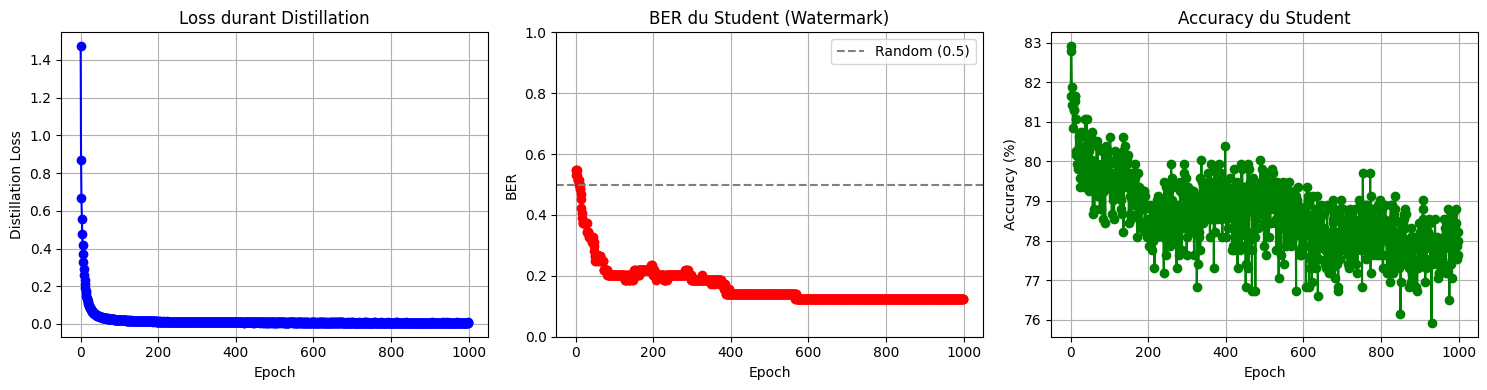


RESUME FINAL
BER Extrait : 0.00
BER Teacher (watermarke): 0.00
BER Student (apres distillation): 0.12
Accuracy Student: 78.0%

-> La marque Dither a survecu a la distillation (BER faible)


In [7]:
# --- Visualisation des Resultats ---

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(attack_history["loss"], 'b-o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Distillation Loss")
axes[0].set_title("Loss durant Distillation")
axes[0].grid(True)

# BER
axes[1].plot(attack_history["ber"], 'r-o')
axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Random (0.5)')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("BER")
axes[1].set_title("BER du Student (Watermark)")
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(True)

# Accuracy
axes[2].plot(attack_history["acc"], 'g-o')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy (%)")
axes[2].set_title("Accuracy du Student")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Resume final
print("\n" + "=" * 50)
print("RESUME FINAL")
print("=" * 50)
print(f"BER Teacher (watermarke): {dither.extract(dither.saved_keys['watermarked_model'])[0]:.2f}")
print(f"BER Student (apres distillation): {attack_history['ber'][-1]:.2f}")
print(f"Accuracy Student: {attack_history['acc'][-1]:.1f}%")

if attack_history['ber'][-1] > 0.4:
    print("\n-> La marque Dither n'a PAS survecu a la distillation (BER eleve)")
else:
    print("\n-> La marque Dither a survecu a la distillation (BER faible)")